## Preprocessing Functions

In [1]:
!pip install powerlaw
!pip install arch
!pip install yfinance

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 12.1 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2 style="text-align: center;">{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [4]:
"""
acf
This code from  ICascha/QuantGANs-replication
"""

import numpy as np
from sklearn.preprocessing import StandardScaler


def rolling_window(x, k, sparse=True):
    """compute rolling windows from timeseries

    Args:
        x ([2d array]): x contains the time series in the shape (timestep, sample).
        k ([int]): number of windows
        sparse (bool): Cut off the final windows containing NA. Defaults to True.

    Returns:
        [3d array]: array of rolling windows in the shape (window, timestep, sample).
    """
    out = np.full([k, *x.shape], np.nan)
    N = len(x)
    for i in range(k):
        out[i, :N-i] = x[i:]

    if not sparse:
        return out

    return out[:, :-(k-1)]

def acf(x, k, le=False):

    """
    Computes autocorrelation for every lag from 1 to k inclusive
    """

    arr = rolling_window(x, k, sparse=False)
    a = (arr[0] - np.nanmean(arr[0], axis=0))
    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

def cross_acf(x, y, k, le=False):

    arr = rolling_window(y, k, sparse=False)
    a = (x - x.mean(axis=0))

    if le:
        arr **=2
    b = (arr - np.nanmean(arr, axis=1, keepdims=True))

    return np.nansum((a * b), axis=1) / np.sqrt(np.nansum(a**2, axis=0) * np.nansum(b**2, axis=1))

In [5]:
"""
gaussianize
Utility code from Greg Ver Steeg.
Transform data so that it is approximately normally distributed
"""

from typing import Text, List, Union

import numpy as np
from scipy import special
from scipy.stats import kurtosis, norm, rankdata, boxcox
from scipy import optimize  # TODO: Explore efficacy of other opt. methods
import sklearn
from matplotlib import pylab as plt
from scipy import stats
import warnings
import os

np.seterr(all='warn')


# Tolerance for == 0.0 tolerance.
_EPS = 1e-6


def _update_x(x: Union[np.ndarray, List]) -> np.ndarray:
    x = np.asarray(x)
    if len(x.shape) == 1:
        x = x[:, np.newaxis]
    elif len(x.shape) != 2:
        raise ValueError("Data should be a 1-d list of samples to transform or a 2d array with samples as rows.")
    return x


class Gaussianize(sklearn.base.TransformerMixin):
    """
    Gaussianize data using various methods.

    Conventions
    ----------
    This class is a wrapper that follows sklearn naming/style (e.g. fit(X) to train).
    In this code, x is the input, y is the output. But in the functions outside the class, I follow
    Georg's convention that Y is the input and X is the output (Gaussianized) data.

    Parameters
    ----------

    strategy : str, default='lambert'. Possibilities are 'lambert'[1], 'brute'[2] and 'boxcox'[3].

    tol : float, default = 1e-4

    max_iter : int, default = 100
        Maximum number of iterations to search for correct parameters of Lambert transform.

    Attributes
    ----------
    coefs_ : list of tuples
        For each variable, we have transformation parameters.
        For Lambert, e.g., a tuple consisting of (mu, sigma, delta), corresponding to the parameters of the
        appropriate Lambert transform. Eq. 6 and 8 in the paper below.

    References
    ----------
    [1] Georg M Goerg. The Lambert Way to Gaussianize heavy tailed data with
                        the inverse of Tukey's h transformation as a special case
        Author generously provides code in R: https://cran.r-project.org/web/packages/LambertW/
    [2] Valero Laparra, Gustavo Camps-Valls, and Jesus Malo. Iterative Gaussianization: From ICA to Random Rotations
    [3] Box cox transformation and references: https://en.wikipedia.org/wiki/Power_transform
    """

    def __init__(self, strategy: Text = 'lambert',
                 tol: float = 1e-5,
                 max_iter: int = 100,
                 verbose: bool = False):
        self.tol = tol
        self.max_iter = max_iter
        self.strategy = strategy
        self.coefs_ = []  # Store tau for each transformed variable
        self.verbose = verbose

    def fit(self, x: np.ndarray, y=None):
        """Fit a Gaussianizing transformation to each variable/column in x."""
        # Initialize coefficients again with an empty list.  Otherwise
        # calling .fit() repeatedly will augment previous .coefs_ list.
        self.coefs_ = []
        x = _update_x(x)
        if self.verbose:
            print("Gaussianizing with strategy='%s'" % self.strategy)

        if self.strategy == "lambert":
            _get_coef = lambda vec: igmm(vec, self.tol, max_iter=self.max_iter)
        elif self.strategy == "brute":
            _get_coef = lambda vec: None   # TODO: In principle, we could store parameters to do a quasi-invert
        elif self.strategy == "boxcox":
            _get_coef = lambda vec: boxcox(vec)[1]
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

        for x_i in x.T:
            self.coefs_.append(_get_coef(x_i))

        return self

    def transform(self, x: np.ndarray) -> np.ndarray:
        """Transform new data using a previously learned Gaussianization model."""
        x = _update_x(x)
        if x.shape[1] != len(self.coefs_):
            raise ValueError("%d variables in test data, but %d variables were in training data." % (x.shape[1], len(self.coefs_)))

        if self.strategy == 'lambert':
            return np.array([w_t(x_i, tau_i) for x_i, tau_i in zip(x.T, self.coefs_)]).T
        elif self.strategy == 'brute':
            return np.array([norm.ppf((rankdata(x_i) - 0.5) / len(x_i)) for x_i in x.T]).T
        elif self.strategy == 'boxcox':
            return np.array([boxcox(x_i, lmbda=lmbda_i) for x_i, lmbda_i in zip(x.T, self.coefs_)]).T
        else:
            raise NotImplementedError("stategy='%s' not implemented." % self.strategy)

    def inverse_transform(self, y: np.ndarray) -> np.ndarray:
        """Recover original data from Gaussianized data."""
        if self.strategy == 'lambert':
            return np.array([inverse(y_i, tau_i) for y_i, tau_i in zip(y.T, self.coefs_)]).T
        elif self.strategy == 'boxcox':
            return np.array([(1. + lmbda_i * y_i) ** (1./lmbda_i) for y_i, lmbda_i in zip(y.T, self.coefs_)]).T
        else:
            raise NotImplementedError("Inversion not supported for gaussianization transform '%s'" % self.strategy)

    def qqplot(self, x: np.ndarray, prefix: Text = 'qq', output_dir: Text = "/tmp/"):
        """Show qq plots compared to normal before and after the transform."""
        x = _update_x(x)
        y = self.transform(x)
        n_dim = y.shape[1]
        for i in range(n_dim):
            stats.probplot(x[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_before.png' % i))
            plt.clf()
            stats.probplot(y[:, i], dist="norm", plot=plt)
            plt.savefig(os.path.join(output_dir, prefix + '_%d_after.png' % i))
            plt.clf()


def w_d(z, delta):
    # Eq. 9
    if delta < _EPS:
        return z
    return np.sign(z) * np.sqrt(np.real(special.lambertw(delta * z ** 2)) / delta)


def w_t(y, tau):
    # Eq. 8
    return tau[0] + tau[1] * w_d((y - tau[0]) / tau[1], tau[2])


def inverse(x, tau):
    # Eq. 6
    u = (x - tau[0]) / tau[1]
    return tau[0] + tau[1] * (u * np.exp(u * u * (tau[2] * 0.5)))


def igmm(y: np.ndarray, tol: float = 1e-6, max_iter: int = 100):
    # Infer mu, sigma, delta using IGMM in Alg.2, Appendix C
    if np.std(y) < _EPS:
        return np.mean(y), np.std(y).clip(_EPS), 0
    delta0 = delta_init(y)
    tau1 = (np.median(y), np.std(y) * (1. - 2. * delta0) ** 0.75, delta0)
    for k in range(max_iter):
        tau0 = tau1
        z = (y - tau1[0]) / tau1[1]
        delta1 = delta_gmm(z)
        x = tau0[0] + tau1[1] * w_d(z, delta1)
        mu1, sigma1 = np.mean(x), np.std(x)
        tau1 = (mu1, sigma1, delta1)

        if np.linalg.norm(np.array(tau1) - np.array(tau0)) < tol:
            break
        else:
            if k == max_iter - 1:
                warnings.warn("Warning: No convergence after %d iterations. Increase max_iter." % max_iter)
    return tau1


def delta_gmm(z):
    # Alg. 1, Appendix C
    delta0 = delta_init(z)

    def func(q):
        u = w_d(z, np.exp(q))
        if not np.all(np.isfinite(u)):
            return 0.
        else:
            k = kurtosis(u, fisher=True, bias=False)**2
            if not np.isfinite(k) or k > 1e10:
                return 1e10
            else:
                return k

    res = optimize.fmin(func, np.log(delta0), disp=0)
    return np.around(np.exp(res[-1]), 6)


def delta_init(z):
    gamma = kurtosis(z, fisher=False, bias=False)
    with np.errstate(all='ignore'):
        delta0 = np.clip(1. / 66 * (np.sqrt(66 * gamma - 162.) - 6.), 0.01, 0.48)
    if not np.isfinite(delta0):
        delta0 = 0.01
    return delta0


# if __name__ == '__main__':\

#     import sys
#     sys.argv = [sys.argv[0]]  # clear any extra arguments

#     # Command line interface
#     # Sample commands:
#     # python gaussianize.py test_data.csv
#     import csv
#     import sys, os
#     import traceback
#     from optparse import OptionParser, OptionGroup

#     parser = OptionParser(usage="usage: %prog [options] data_file.csv \n"
#                                 "It is assumed that the first row and first column of the data CSV file are labels.\n"
#                                 "Use options to indicate otherwise.")
#     group = OptionGroup(parser, "Input Data Format Options")
#     group.add_option("-c", "--no_column_names",
#                      action="store_true", dest="nc", default=False,
#                      help="We assume the top row is variable names for each column. "
#                           "This flag says that data starts on the first row and gives a "
#                           "default numbering scheme to the variables (1,2,3...).")
#     group.add_option("-r", "--no_row_names",
#                      action="store_true", dest="nr", default=False,
#                      help="We assume the first column is a label or index for each sample. "
#                           "This flag says that data starts on the first column.")
#     group.add_option("-d", "--delimiter",
#                      action="store", dest="delimiter", type="string", default=",",
#                      help="Separator between entries in the data, default is ','.")
#     parser.add_option_group(group)

#     group = OptionGroup(parser, "Transform Options")
#     group.add_option("-s", "--strategy",
#                      action="store", dest="strategy", type="string", default="lambert",
#                      help="Strategy.")
#     parser.add_option_group(group)

#     group = OptionGroup(parser, "Output Options")
#     group.add_option("-o", "--output",
#                      action="store", dest="output", type="string", default="gaussian_output.csv",
#                      help="Where to store gaussianized data.")
#     group.add_option("-q", "--qqplots",
#                      action="store_true", dest="q", default=False,
#                      help="Produce qq plots for each variable before and after transform.")
#     parser.add_option_group(group)

#     (options, args) = parser.parse_args()
#     if not len(args) == 1:
#         warnings.warn("Run with '-h' option for usage help.")
#         sys.exit()

#     #Load data from csv file
#     filename = args[0]
#     with open(filename, 'rU') as csvfile:
#         reader = csv.reader(csvfile, delimiter=" ")  #options.delimiter)
#         if options.nc:
#             variable_names = None
#         else:
#             variable_names = reader.next()[(1 - options.nr):]
#         sample_names = []
#         data = []
#         for row in reader:
#             if options.nr:
#                 sample_names = None
#             else:
#                 sample_names.append(row[0])
#             data.append(row[(1 - options.nr):])

#     print(len(data), data[0])
#     try:
#         for i in range(len(data)):
#             data[i] = map(float, data[i])
#         X = np.array(data, dtype=float)  # Data matrix in numpy format
#     except:
#         raise ValueError("Incorrect data format.\nCheck that you've correctly specified options "
#                          "such as continuous or not, \nand if there is a header row or column.\n"
#                          "Run 'python gaussianize.py -h' option for help with options.")
#         traceback.print_exc(file=sys.stdout)
#         sys.exit()

#     ks = []
#     for xi in X.T:
#         ks.append(kurtosis(xi))
#     print(np.mean(np.array(ks) > 1))
#     from matplotlib import pylab
#     pylab.hist(ks, bins=30)
#     pylab.xlabel('excess kurtosis')
#     pylab.savefig('excess_kurtoses_all.png')
#     pylab.clf()
#     pylab.hist([k for k in ks if k < 2], bins=30)
#     pylab.xlabel('excess kurtosis')
#     pylab.savefig('excess_kurtoses_near_zero.png')
#     print(np.argmax(ks))
#     pdict = {}
#     for k in np.argsort(- np.array(ks))[:50]:
#         pylab.clf()
#         p = np.argmax(X[:, k])
#         pdict[p] = pdict.get(p, 0) + 1
#         pylab.hist(X[:, k], bins=30)
#         pylab.xlabel(variable_names[k])
#         pylab.ylabel('Histogram of patients')
#         pylab.savefig('high_kurtosis/'+variable_names[k] + '.png')
#     print(pdict)  # 203, 140 appear three times.
#     sys.exit()
#     out = Gaussianize(strategy=options.strategy)
#     y = out.fit_transform(X)
#     with open(options.output, 'w') as csvfile:
#         writer = csv.writer(csvfile, delimiter=options.delimiter)
#         if not options.nc:
#             writer.writerow([""] * (1 - options.nr) + variable_names)
#         for i, row in enumerate(y):
#             if not options.nr:
#                 writer.writerow([sample_names[i]] + list(row))
#             else:
#                 writer.writerow(row)

#     if options.q:
#         print('Making qq plots')
#         prefix = options.output.split('.')[0]
#         if not os.path.exists(prefix+'_q'):
#             os.makedirs(prefix+'_q')
#         out.qqplot(X, prefix=prefix + '_q/q')

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
import os
# Disable TorchDynamo before importing torch modules
# os.environ["TORCHDYNAMO_DISABLE"] = "1"
import torch
import torch.nn as nn
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import weight_norm
from torch.nn.utils import spectral_norm
import torch.autograd
from tqdm import tqdm

## Preprocessing

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


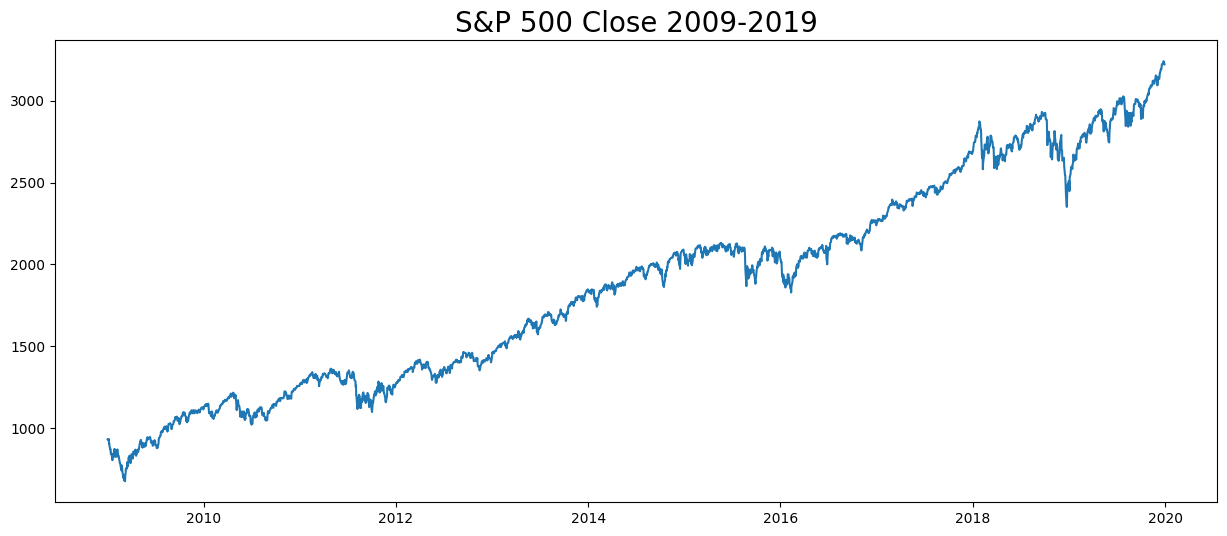

In [7]:
data = yf.download("^GSPC", start="2009-01-01", end="2019-12-31")
df = data['Close']
log_returns = np.log(df/df.shift(1))[1:].to_numpy().reshape(-1, 1)

fig = plt.figure(figsize=(15,6))
plt.title(f'S&P 500 Close 2009-2019', fontsize=20)
plt.plot(data.index, data['Close'] )
plt.show()

In [8]:
len(log_returns)

2766

In [9]:
standardScaler1 = StandardScaler()
standardScaler2 = StandardScaler()
gaussianize = Gaussianize()

# receptive field size
rfs = 127

# pre-processing pipeline
log_returns_preprocessed = standardScaler2.fit_transform(gaussianize.fit_transform(standardScaler1.fit_transform(log_returns)))

## Torch Causal TCN GAN (Architecture & Training)

In [31]:
# Architecture credits to PakAudrey: https://github.com/PakAndrey/QuantGANforRisk/blob/main/model/torch_tcn.py
class Chomp1d(nn.Module):
    def __init__(self, chomp_size):
        super(Chomp1d, self).__init__()
        self.chomp_size = chomp_size

    def forward(self, x):
        return x[:, :, :-self.chomp_size].contiguous()


class TemporalBlock(nn.Module):
    """Creates a temporal block.
    Args:
        n_inputs (int): number of inputs.
        n_outputs (int): size of fully connected layers.
        kernel_size (int): kernel size along temporal axis of convolution layers within the temporal block.
        dilation (int): dilation of convolution layers along temporal axis within the temporal block.
        padding (int): padding
        dropout (float): dropout rate
    Returns:
        tuple of output layers
    """
    def __init__(self, n_inputs, n_outputs, kernel_size, stride, dilation, padding, dropout=0.2):
        super(TemporalBlock, self).__init__()
        self.conv1 = spectral_norm(nn.Conv1d(n_inputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp1 = Chomp1d(padding)
        self.prelu1 = nn.PReLU()
        self.dropout1 = nn.Dropout(dropout)

        self.conv2 = spectral_norm(nn.Conv1d(n_outputs, n_outputs, kernel_size, stride=stride, padding=padding, dilation=dilation))
        self.chomp2 = Chomp1d(padding)
        self.prelu2 = nn.PReLU()
        self.dropout2 = nn.Dropout(dropout)

        if padding == 0:
            self.net = nn.Sequential(self.conv1, self.prelu1, self.dropout1, self.conv2, self.prelu2, self.dropout2)
        else:
            self.net = nn.Sequential(self.conv1, self.chomp1, self.prelu1, self.dropout1, self.conv2, self.chomp2, self.prelu2, self.dropout2)

        self.downsample = nn.Conv1d(n_inputs, n_outputs, 1) if n_inputs != n_outputs else None
        self.prelu = nn.PReLU()
        self.init_weights()

    def init_weights(self):
        self.conv1.weight.data.normal_(0, 0.5)
        self.conv2.weight.data.normal_(0, 0.5)
        if self.downsample is not None:
            self.downsample.weight.data.normal_(0, 0.5)

    def forward(self, x):
        out = self.net(x)
        res = x if self.downsample is None else self.downsample(x)
        return out, self.prelu(out + res)



class Generator(nn.Module):
    """Generator: 3 to 1 Causal temporal convolutional network with skip connections.
       This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """
    def __init__(self):
        super(Generator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(3, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i) for i in [1, 2, 4, 8, 16, 32]]])
        self.last = nn.Conv1d(80, 1, kernel_size=1, stride=1, dilation=1)

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))
        return x


class Discriminator(nn.Module):
    """Discrimnator: 1 to 1 Causal temporal convolutional network with skip connections.
       This network uses 1D convolutions in order to model multiple timeseries co-dependency.
    """
    def __init__(self, seq_len, conv_dropout=0.05):
        super(Discriminator, self).__init__()
        self.tcn = nn.ModuleList([TemporalBlock(1, 80, kernel_size=1, stride=1, dilation=1, padding=0),
                                 *[TemporalBlock(80, 80, kernel_size=2, stride=1, dilation=i, padding=i) for i in [1, 2, 4, 8, 16, 32]]])
        self.last = nn.Conv1d(80, 1, kernel_size=1, dilation=1)
        self.to_prob = nn.Sequential(nn.Linear(seq_len, 1), nn.Sigmoid())

    def forward(self, x):
        skip_layers = []
        for layer in self.tcn:
            skip, x = layer(x)
            skip_layers.append(skip)
        x = self.last(x + sum(skip_layers))  # Shape: (batch_size, 1, seq_len)
        # print("Shape after last conv:", x.shape)  # Debug: Should be (batch_size, 1, seq_len)
        x = x.squeeze(1)  # Shape: (batch_size, seq_len)
        # print("Shape after squeeze:", x.shape)  # Debug: Should be (batch_size, seq_len)
        x = self.to_prob(x)  # Shape: (batch_size, 1)
        x = x.squeeze()  # Shape: (batch_size,)
        # print("Shape after to_prob:", x.shape)  # Debug: Should be (batch_size,)
        return x





# Training Code
class GAN(nn.Module):
    def __init__(self, fixed_filters=64, d_lr=1e-4, g_lr=3e-5, device='cpu'):
        super().__init__()
        self.steps = 0
        self.device = device
        # Use 6 dilation levels
        dilations = [2**i for i in range(6)]

        self.generator = Generator().to(device)

        self.discriminator = Discriminator(rfs).to(device)

        # Use Adam optimizers
        self.opt_g = optim.Adam(self.generator.parameters(), eps=1e-8, lr=g_lr, betas=(.0, 0.9))
        self.opt_d = optim.Adam(self.discriminator.parameters(), eps=1e-8, lr=d_lr, betas=(.0, 0.9))

        # Define binary cross entropy loss with logits
        self.criterion = nn.BCEWithLogitsLoss()


    def train_step(self, real_data):
        # --- Discriminator update ---
        self.opt_d.zero_grad()
        # Forward pass through discriminator
        real_pred = self.discriminator(real_data)
        # Create target tensor of ones for real data
        real_target = torch.ones_like(real_pred)
        d_loss_real = self.criterion(real_pred, real_target)
        # print("real data", real_data.shape)

        # Generate fake data using noise
        # noise = torch.randn(real_data.size(0), 1, 253, 3).to(self.device)
        noise = torch.randn(real_data.size(0), 3, rfs).to(self.device)
        # noise = noise.permute(0,1,3,2)
        # print("noise ", noise.shape)
        fake_data = self.generator(noise).detach()
        fake_pred = self.discriminator(fake_data.detach())
        # Create target tensor of zeros for fake data
        fake_target = torch.zeros_like(fake_pred)
        d_loss_fake = self.criterion(fake_pred, fake_target)

        # Total discriminator loss
        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        self.opt_d.step()


        # --- Generator update (use a new forward pass) ---
        self.opt_g.zero_grad()
        # noise_gen = torch.randn(real_data.size(0), 1, 253, 3).to(self.device)
        noise_gen = torch.randn(real_data.size(0), 3, rfs).to(self.device)
        # noise_gen = noise_gen.permute(0,1,3,2)
        fake_data_gen = self.generator(noise_gen).detach()
        # For generator update, we want fake data to be classified as real
        gen_target = torch.ones_like(self.discriminator(fake_data_gen))
        g_loss = self.criterion(self.discriminator(fake_data_gen), gen_target)
        g_loss.backward()
        self.opt_g.step()

        if (self.steps) % 100 == 0:
            y = self.generator(self.fixed_noise).detach().cpu().numpy().squeeze()
            scores = []
            scores.append(np.linalg.norm(self.acf_real - acf(y.T, 250).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.abs_acf_real - acf(y.T**2, 250).mean(axis=1, keepdims=True)))
            scores.append(np.linalg.norm(self.le_real - acf(y.T, 250, le=True).mean(axis=1, keepdims=True)))
            print("\nacf: {:.4f}, acf_abs: {:.4f}, le: {:.4f}".format(*scores))

        self.steps += 1

        return {
            'd_loss': d_loss.item(),
            'g_loss': g_loss.item()
        }

# def weights_init(m):
#     if isinstance(m, nn.Conv2d):
#         nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
#     elif isinstance(m, nn.BatchNorm2d):
#         nn.init.constant_(m.weight, 1)
#         nn.init.constant_(m.bias, 0)



def initialize_weights(module):
    """Initialize weights like TensorFlow defaults."""
    if isinstance(module, nn.Conv1d):
        # Xavier/Glorot uniform initialization for Conv2D (like TF's glorot_uniform)
        init.xavier_uniform_(module.weight)
        if module.bias is not None:
            init.zeros_(module.bias)  # Bias initialized to 0 (like TF)

    elif isinstance(module, nn.BatchNorm1d):
        # BatchNorm: gamma=1, beta=0 (like TF)
        init.ones_(module.weight)     # gamma (scale)
        init.zeros_(module.bias)      # beta (shift)
        # Note: PyTorch already initializes running_mean=0, running_var=1 (same as TF)

    elif isinstance(module, nn.Linear):
        # Linear layers also use Xavier/Glorot in TF by default
        init.xavier_uniform_(module.weight)
        if module.bias is not None:
            init.zeros_(module.bias)

    elif isinstance(module, nn.PReLU):
        # PReLU: alpha=0.25 by default in TF, but PyTorch uses 0.25 by default too
        # Only needed if you want to enforce it explicitly
        init.constant_(module.weight, 0.25)

    # Note: SpectralNorm is applied as a wrapper, so we don't initialize it here.
    # Instead, ensure the base layer (Conv2D/Linear) is initialized correctly.


# Specify settings
file_name = 'SP500_daily'
generator_path = '/content/drive/MyDrive/Thesis/QuantGAN/'   # Replcae with your directory
nz = 3  # number of input features for the generator
batch_size = 64
n_batches = 1000
rfs = 127
# d_lr = 1e-6
# g_lr = 3e-5
# d_lr = 3e-5
# g_lr = 1e-4
d_lr = 0.0002
g_lr = 0.0002
device = torch.device("cpu")

gan = GAN(
    fixed_filters=100,
    d_lr=d_lr,
    g_lr=g_lr,
    device=device
)

gan.generator.apply(initialize_weights)
gan.discriminator.apply(initialize_weights)
gan.fixed_noise = torch.randn(128, 3, 3000)
gan.acf_real = acf(log_returns_preprocessed, 250)
gan.abs_acf_real = acf(log_returns_preprocessed**2, 250)
gan.le_real = acf(log_returns_preprocessed, 250, le=True)

def compute_window_weights(series_length, window_size):
    # First, compute how many windows each time step appears in.
    # For a series of length T, time step i (0-indexed) appears in:
    # count[i] = min(i+1, window_size, series_length - i)
    counts = np.array([min(i + 1, window_size, series_length - i) for i in range(series_length)])

    # Now compute a weight for each possible window starting index.
    # There are (series_length - window_size + 1) windows.
    window_weights = []
    for t in range(series_length - window_size + 1):
        # For window starting at t, get the counts for all time steps in that window
        window_counts = counts[t: t + window_size]
        # The idea is to favor windows where the average count is low
        # (i.e. under-sampled time steps get higher weight)
        weight = np.mean(1.0 / window_counts)
        window_weights.append(weight)
    window_weights = np.array(window_weights)
    # Normalize weights to sum to 1
    window_weights /= window_weights.sum()
    return window_weights


progress_bar = tqdm(range(n_batches))
for i in progress_bar:
    progress_bar.set_description(f"Batch {i}/{len(progress_bar)}")

    roll = rolling_window(log_returns_preprocessed, len(log_returns_preprocessed) - 127 + 1)
    window_weights = compute_window_weights(log_returns_preprocessed.shape[0], 127)
    idx = np.random.choice(roll.shape[0], 64)
    real_data = torch.from_numpy(roll[idx])
    real_data = real_data.permute(0,2,1)
    real_data = real_data.float()
    losses = gan.train_step(real_data)
    total_d_loss = losses['d_loss']
    total_g_loss = losses['g_loss']
    print(f'Batch {i+1} | D Loss: {total_d_loss:.4f} | G Loss: {total_g_loss:.4f}')





torch.save(gan.generator.state_dict(), f'{generator_path}torch_causal_tcn_{n_batches}.pth')  # Replcae with your directory

Batch 1/1000:   0%|          | 1/1000 [00:27<7:30:35, 27.06s/it]


acf: 0.3446, acf_abs: 1.3685, le: 0.9247
Batch 1 | D Loss: 1.5398 | G Loss: 0.4446


Batch 2/1000:   0%|          | 2/1000 [00:29<3:29:50, 12.62s/it]

Batch 2 | D Loss: 1.4639 | G Loss: 0.4501


Batch 3/1000:   0%|          | 3/1000 [00:31<2:09:08,  7.77s/it]

Batch 3 | D Loss: 1.4626 | G Loss: 0.4563


Batch 4/1000:   0%|          | 4/1000 [00:33<1:29:30,  5.39s/it]

Batch 4 | D Loss: 1.4529 | G Loss: 0.4564


Batch 5/1000:   0%|          | 5/1000 [00:35<1:07:36,  4.08s/it]

Batch 5 | D Loss: 1.4664 | G Loss: 0.4613


Batch 6/1000:   1%|          | 6/1000 [00:36<54:17,  3.28s/it]

Batch 6 | D Loss: 1.4640 | G Loss: 0.4702


Batch 7/1000:   1%|          | 7/1000 [00:38<45:43,  2.76s/it]

Batch 7 | D Loss: 1.4569 | G Loss: 0.4753


Batch 8/1000:   1%|          | 8/1000 [00:40<40:18,  2.44s/it]

Batch 8 | D Loss: 1.4532 | G Loss: 0.4654


Batch 9/1000:   1%|          | 9/1000 [00:42<40:20,  2.44s/it]

Batch 9 | D Loss: 1.4697 | G Loss: 0.4630


Batch 10/1000:   1%|          | 10/1000 [00:44<39:35,  2.40s/it]

Batch 10 | D Loss: 1.4395 | G Loss: 0.4702


Batch 11/1000:   1%|          | 11/1000 [00:46<36:16,  2.20s/it]

Batch 11 | D Loss: 1.4664 | G Loss: 0.4715


Batch 12/1000:   1%|          | 12/1000 [00:48<34:03,  2.07s/it]

Batch 12 | D Loss: 1.4573 | G Loss: 0.4700


Batch 13/1000:   1%|▏         | 13/1000 [00:50<32:40,  1.99s/it]

Batch 13 | D Loss: 1.4496 | G Loss: 0.4697


Batch 14/1000:   1%|▏         | 14/1000 [00:52<31:23,  1.91s/it]

Batch 14 | D Loss: 1.4568 | G Loss: 0.4770


Batch 15/1000:   2%|▏         | 15/1000 [00:53<30:49,  1.88s/it]

Batch 15 | D Loss: 1.4397 | G Loss: 0.4735


Batch 16/1000:   2%|▏         | 16/1000 [00:56<32:16,  1.97s/it]

Batch 16 | D Loss: 1.4470 | G Loss: 0.4805


Batch 17/1000:   2%|▏         | 17/1000 [00:58<35:49,  2.19s/it]

Batch 17 | D Loss: 1.4507 | G Loss: 0.4735


Batch 18/1000:   2%|▏         | 18/1000 [01:00<33:55,  2.07s/it]

Batch 18 | D Loss: 1.4419 | G Loss: 0.4772


Batch 19/1000:   2%|▏         | 19/1000 [01:02<32:57,  2.02s/it]

Batch 19 | D Loss: 1.4386 | G Loss: 0.4826


Batch 20/1000:   2%|▏         | 20/1000 [01:04<31:34,  1.93s/it]

Batch 20 | D Loss: 1.4547 | G Loss: 0.4822


Batch 21/1000:   2%|▏         | 21/1000 [01:05<30:47,  1.89s/it]

Batch 21 | D Loss: 1.4308 | G Loss: 0.4859


Batch 22/1000:   2%|▏         | 22/1000 [01:07<30:11,  1.85s/it]

Batch 22 | D Loss: 1.4468 | G Loss: 0.4852


Batch 23/1000:   2%|▏         | 23/1000 [01:09<31:43,  1.95s/it]

Batch 23 | D Loss: 1.4432 | G Loss: 0.4861


Batch 24/1000:   2%|▏         | 24/1000 [01:12<34:42,  2.13s/it]

Batch 24 | D Loss: 1.4359 | G Loss: 0.4767


Batch 25/1000:   2%|▎         | 25/1000 [01:14<33:43,  2.08s/it]

Batch 25 | D Loss: 1.4292 | G Loss: 0.4905


Batch 26/1000:   3%|▎         | 26/1000 [01:16<32:12,  1.98s/it]

Batch 26 | D Loss: 1.4237 | G Loss: 0.4898


Batch 27/1000:   3%|▎         | 27/1000 [01:17<31:26,  1.94s/it]

Batch 27 | D Loss: 1.4278 | G Loss: 0.4927


Batch 28/1000:   3%|▎         | 28/1000 [01:19<30:34,  1.89s/it]

Batch 28 | D Loss: 1.4422 | G Loss: 0.4897


Batch 29/1000:   3%|▎         | 29/1000 [01:21<29:53,  1.85s/it]

Batch 29 | D Loss: 1.4170 | G Loss: 0.4891


Batch 30/1000:   3%|▎         | 30/1000 [01:23<30:07,  1.86s/it]

Batch 30 | D Loss: 1.4363 | G Loss: 0.4914


Batch 31/1000:   3%|▎         | 31/1000 [01:25<33:32,  2.08s/it]

Batch 31 | D Loss: 1.4238 | G Loss: 0.4979


Batch 32/1000:   3%|▎         | 32/1000 [01:28<33:52,  2.10s/it]

Batch 32 | D Loss: 1.4287 | G Loss: 0.5055


Batch 33/1000:   3%|▎         | 33/1000 [01:30<35:13,  2.19s/it]

Batch 33 | D Loss: 1.4190 | G Loss: 0.4987


Batch 34/1000:   3%|▎         | 34/1000 [01:32<33:09,  2.06s/it]

Batch 34 | D Loss: 1.4214 | G Loss: 0.5007


Batch 35/1000:   4%|▎         | 35/1000 [01:33<31:28,  1.96s/it]

Batch 35 | D Loss: 1.4173 | G Loss: 0.5086


Batch 36/1000:   4%|▎         | 36/1000 [01:35<30:27,  1.90s/it]

Batch 36 | D Loss: 1.4396 | G Loss: 0.4965


Batch 37/1000:   4%|▎         | 37/1000 [01:37<30:28,  1.90s/it]

Batch 37 | D Loss: 1.4243 | G Loss: 0.5078


Batch 38/1000:   4%|▍         | 38/1000 [01:40<33:02,  2.06s/it]

Batch 38 | D Loss: 1.4105 | G Loss: 0.5125


Batch 39/1000:   4%|▍         | 39/1000 [01:42<33:23,  2.08s/it]

Batch 39 | D Loss: 1.4125 | G Loss: 0.5206


Batch 40/1000:   4%|▍         | 40/1000 [01:43<31:29,  1.97s/it]

Batch 40 | D Loss: 1.4250 | G Loss: 0.5138


Batch 41/1000:   4%|▍         | 41/1000 [01:45<30:08,  1.89s/it]

Batch 41 | D Loss: 1.4077 | G Loss: 0.5194


Batch 42/1000:   4%|▍         | 42/1000 [01:47<29:16,  1.83s/it]

Batch 42 | D Loss: 1.3906 | G Loss: 0.5301


Batch 43/1000:   4%|▍         | 43/1000 [01:49<28:40,  1.80s/it]

Batch 43 | D Loss: 1.3829 | G Loss: 0.5524


Batch 44/1000:   4%|▍         | 44/1000 [01:50<28:26,  1.78s/it]

Batch 44 | D Loss: 1.3819 | G Loss: 0.5471


Batch 45/1000:   4%|▍         | 45/1000 [01:53<30:56,  1.94s/it]

Batch 45 | D Loss: 1.3847 | G Loss: 0.5512


Batch 46/1000:   5%|▍         | 46/1000 [01:55<33:09,  2.09s/it]

Batch 46 | D Loss: 1.3812 | G Loss: 0.5511


Batch 47/1000:   5%|▍         | 47/1000 [01:57<31:28,  1.98s/it]

Batch 47 | D Loss: 1.3591 | G Loss: 0.5877


Batch 48/1000:   5%|▍         | 48/1000 [01:58<30:10,  1.90s/it]

Batch 48 | D Loss: 1.3392 | G Loss: 0.5966


Batch 49/1000:   5%|▍         | 49/1000 [02:00<29:35,  1.87s/it]

Batch 49 | D Loss: 1.3447 | G Loss: 0.6045


Batch 50/1000:   5%|▌         | 50/1000 [02:02<29:12,  1.84s/it]

Batch 50 | D Loss: 1.3464 | G Loss: 0.6209


Batch 51/1000:   5%|▌         | 51/1000 [02:04<28:36,  1.81s/it]

Batch 51 | D Loss: 1.3367 | G Loss: 0.6246


Batch 52/1000:   5%|▌         | 52/1000 [02:06<29:36,  1.87s/it]

Batch 52 | D Loss: 1.3058 | G Loss: 0.6247


Batch 53/1000:   5%|▌         | 53/1000 [02:08<32:19,  2.05s/it]

Batch 53 | D Loss: 1.3152 | G Loss: 0.6342


Batch 54/1000:   5%|▌         | 54/1000 [02:10<31:54,  2.02s/it]

Batch 54 | D Loss: 1.2890 | G Loss: 0.6373


Batch 55/1000:   6%|▌         | 55/1000 [02:12<30:47,  1.95s/it]

Batch 55 | D Loss: 1.3043 | G Loss: 0.6474


Batch 56/1000:   6%|▌         | 56/1000 [02:14<29:59,  1.91s/it]

Batch 56 | D Loss: 1.2761 | G Loss: 0.6398


Batch 57/1000:   6%|▌         | 57/1000 [02:16<29:50,  1.90s/it]

Batch 57 | D Loss: 1.3044 | G Loss: 0.6448


Batch 58/1000:   6%|▌         | 58/1000 [02:18<29:19,  1.87s/it]

Batch 58 | D Loss: 1.2898 | G Loss: 0.6531


Batch 59/1000:   6%|▌         | 59/1000 [02:19<29:35,  1.89s/it]

Batch 59 | D Loss: 1.2764 | G Loss: 0.6529


Batch 60/1000:   6%|▌         | 60/1000 [02:22<32:07,  2.05s/it]

Batch 60 | D Loss: 1.2925 | G Loss: 0.6503


Batch 61/1000:   6%|▌         | 61/1000 [02:24<32:31,  2.08s/it]

Batch 61 | D Loss: 1.2819 | G Loss: 0.6602


Batch 62/1000:   6%|▌         | 62/1000 [02:26<31:27,  2.01s/it]

Batch 62 | D Loss: 1.2695 | G Loss: 0.6535


Batch 63/1000:   6%|▋         | 63/1000 [02:28<30:26,  1.95s/it]

Batch 63 | D Loss: 1.2768 | G Loss: 0.6668


Batch 64/1000:   6%|▋         | 64/1000 [02:30<30:19,  1.94s/it]

Batch 64 | D Loss: 1.2427 | G Loss: 0.6631


Batch 65/1000:   6%|▋         | 65/1000 [02:31<29:31,  1.89s/it]

Batch 65 | D Loss: 1.2597 | G Loss: 0.6585


Batch 66/1000:   7%|▋         | 66/1000 [02:33<28:41,  1.84s/it]

Batch 66 | D Loss: 1.2651 | G Loss: 0.6687


Batch 67/1000:   7%|▋         | 67/1000 [02:36<31:38,  2.03s/it]

Batch 67 | D Loss: 1.2271 | G Loss: 0.6660


Batch 68/1000:   7%|▋         | 68/1000 [02:38<32:39,  2.10s/it]

Batch 68 | D Loss: 1.2015 | G Loss: 0.6558


Batch 69/1000:   7%|▋         | 69/1000 [02:40<31:05,  2.00s/it]

Batch 69 | D Loss: 1.2085 | G Loss: 0.6624


Batch 70/1000:   7%|▋         | 70/1000 [02:41<30:02,  1.94s/it]

Batch 70 | D Loss: 1.2342 | G Loss: 0.6652


Batch 71/1000:   7%|▋         | 71/1000 [02:43<28:55,  1.87s/it]

Batch 71 | D Loss: 1.1841 | G Loss: 0.6654


Batch 72/1000:   7%|▋         | 72/1000 [02:45<28:22,  1.83s/it]

Batch 72 | D Loss: 1.1626 | G Loss: 0.6660


Batch 73/1000:   7%|▋         | 73/1000 [02:47<27:55,  1.81s/it]

Batch 73 | D Loss: 1.1708 | G Loss: 0.6648


Batch 74/1000:   7%|▋         | 74/1000 [02:49<29:29,  1.91s/it]

Batch 74 | D Loss: 1.1323 | G Loss: 0.6758


Batch 75/1000:   8%|▊         | 75/1000 [02:51<32:44,  2.12s/it]

Batch 75 | D Loss: 1.1320 | G Loss: 0.6697


Batch 76/1000:   8%|▊         | 76/1000 [02:53<31:21,  2.04s/it]

Batch 76 | D Loss: 1.1059 | G Loss: 0.6795


Batch 77/1000:   8%|▊         | 77/1000 [02:55<30:09,  1.96s/it]

Batch 77 | D Loss: 1.0939 | G Loss: 0.6757


Batch 78/1000:   8%|▊         | 78/1000 [02:57<28:57,  1.88s/it]

Batch 78 | D Loss: 1.0889 | G Loss: 0.6732


Batch 79/1000:   8%|▊         | 79/1000 [02:58<28:19,  1.84s/it]

Batch 79 | D Loss: 1.0670 | G Loss: 0.6800


Batch 80/1000:   8%|▊         | 80/1000 [03:00<27:42,  1.81s/it]

Batch 80 | D Loss: 1.0624 | G Loss: 0.6797


Batch 81/1000:   8%|▊         | 81/1000 [03:02<28:36,  1.87s/it]

Batch 81 | D Loss: 1.0501 | G Loss: 0.6843


Batch 82/1000:   8%|▊         | 82/1000 [03:05<31:07,  2.03s/it]

Batch 82 | D Loss: 1.0477 | G Loss: 0.6851


Batch 83/1000:   8%|▊         | 83/1000 [03:07<30:58,  2.03s/it]

Batch 83 | D Loss: 1.0571 | G Loss: 0.6833


Batch 84/1000:   8%|▊         | 84/1000 [03:08<29:27,  1.93s/it]

Batch 84 | D Loss: 1.0381 | G Loss: 0.6873


Batch 85/1000:   8%|▊         | 85/1000 [03:10<28:30,  1.87s/it]

Batch 85 | D Loss: 1.0340 | G Loss: 0.6875


Batch 86/1000:   9%|▊         | 86/1000 [03:12<27:53,  1.83s/it]

Batch 86 | D Loss: 1.0318 | G Loss: 0.6867


Batch 87/1000:   9%|▊         | 87/1000 [03:13<27:05,  1.78s/it]

Batch 87 | D Loss: 1.0190 | G Loss: 0.6890


Batch 88/1000:   9%|▉         | 88/1000 [03:15<26:45,  1.76s/it]

Batch 88 | D Loss: 1.0211 | G Loss: 0.6901


Batch 89/1000:   9%|▉         | 89/1000 [03:17<28:51,  1.90s/it]

Batch 89 | D Loss: 1.0198 | G Loss: 0.6906


Batch 90/1000:   9%|▉         | 90/1000 [03:20<31:05,  2.05s/it]

Batch 90 | D Loss: 1.0222 | G Loss: 0.6903


Batch 91/1000:   9%|▉         | 91/1000 [03:21<29:27,  1.94s/it]

Batch 91 | D Loss: 1.0161 | G Loss: 0.6910


Batch 92/1000:   9%|▉         | 92/1000 [03:23<28:13,  1.87s/it]

Batch 92 | D Loss: 1.0131 | G Loss: 0.6903


Batch 93/1000:   9%|▉         | 93/1000 [03:25<27:19,  1.81s/it]

Batch 93 | D Loss: 1.0131 | G Loss: 0.6911


Batch 94/1000:   9%|▉         | 94/1000 [03:27<26:44,  1.77s/it]

Batch 94 | D Loss: 1.0117 | G Loss: 0.6917


Batch 95/1000:  10%|▉         | 95/1000 [03:28<26:13,  1.74s/it]

Batch 95 | D Loss: 1.0134 | G Loss: 0.6910


Batch 96/1000:  10%|▉         | 96/1000 [03:30<26:17,  1.75s/it]

Batch 96 | D Loss: 1.0129 | G Loss: 0.6913


Batch 97/1000:  10%|▉         | 97/1000 [03:32<29:24,  1.95s/it]

Batch 97 | D Loss: 1.0117 | G Loss: 0.6925


Batch 98/1000:  10%|▉         | 98/1000 [03:35<30:14,  2.01s/it]

Batch 98 | D Loss: 1.0102 | G Loss: 0.6922


Batch 99/1000:  10%|▉         | 99/1000 [03:36<28:51,  1.92s/it]

Batch 99 | D Loss: 1.0102 | G Loss: 0.6922


Batch 100/1000:  10%|█         | 100/1000 [03:38<27:52,  1.86s/it]

Batch 100 | D Loss: 1.0111 | G Loss: 0.6920


Batch 101/1000:  10%|█         | 101/1000 [04:04<2:16:49,  9.13s/it]


acf: 0.3491, acf_abs: 1.3778, le: 0.9274
Batch 101 | D Loss: 1.0087 | G Loss: 0.6922


Batch 102/1000:  10%|█         | 102/1000 [04:06<1:43:24,  6.91s/it]

Batch 102 | D Loss: 1.0088 | G Loss: 0.6926


Batch 103/1000:  10%|█         | 103/1000 [04:08<1:19:59,  5.35s/it]

Batch 103 | D Loss: 1.0086 | G Loss: 0.6927


Batch 104/1000:  10%|█         | 104/1000 [04:09<1:03:35,  4.26s/it]

Batch 104 | D Loss: 1.0079 | G Loss: 0.6926


Batch 105/1000:  10%|█         | 105/1000 [04:11<52:04,  3.49s/it]

Batch 105 | D Loss: 1.0084 | G Loss: 0.6929


Batch 106/1000:  11%|█         | 106/1000 [04:13<46:03,  3.09s/it]

Batch 106 | D Loss: 1.0085 | G Loss: 0.6926


Batch 107/1000:  11%|█         | 107/1000 [04:16<43:07,  2.90s/it]

Batch 107 | D Loss: 1.0086 | G Loss: 0.6921


Batch 108/1000:  11%|█         | 108/1000 [04:17<38:04,  2.56s/it]

Batch 108 | D Loss: 1.0081 | G Loss: 0.6928


Batch 109/1000:  11%|█         | 109/1000 [04:19<34:24,  2.32s/it]

Batch 109 | D Loss: 1.0077 | G Loss: 0.6925


Batch 110/1000:  11%|█         | 110/1000 [04:21<32:00,  2.16s/it]

Batch 110 | D Loss: 1.0074 | G Loss: 0.6929


Batch 111/1000:  11%|█         | 111/1000 [04:23<30:11,  2.04s/it]

Batch 111 | D Loss: 1.0076 | G Loss: 0.6925


Batch 112/1000:  11%|█         | 112/1000 [04:24<28:44,  1.94s/it]

Batch 112 | D Loss: 1.0085 | G Loss: 0.6929


Batch 113/1000:  11%|█▏        | 113/1000 [04:26<28:10,  1.91s/it]

Batch 113 | D Loss: 1.0071 | G Loss: 0.6929


Batch 114/1000:  11%|█▏        | 114/1000 [04:29<30:43,  2.08s/it]

Batch 114 | D Loss: 1.0071 | G Loss: 0.6928


Batch 115/1000:  12%|█▏        | 115/1000 [04:31<30:54,  2.10s/it]

Batch 115 | D Loss: 1.0070 | G Loss: 0.6930


Batch 116/1000:  12%|█▏        | 116/1000 [04:33<29:37,  2.01s/it]

Batch 116 | D Loss: 1.0070 | G Loss: 0.6929


Batch 117/1000:  12%|█▏        | 117/1000 [04:34<28:33,  1.94s/it]

Batch 117 | D Loss: 1.0075 | G Loss: 0.6930


Batch 118/1000:  12%|█▏        | 118/1000 [04:36<27:40,  1.88s/it]

Batch 118 | D Loss: 1.0069 | G Loss: 0.6930


Batch 119/1000:  12%|█▏        | 119/1000 [04:38<27:06,  1.85s/it]

Batch 119 | D Loss: 1.0068 | G Loss: 0.6930


Batch 120/1000:  12%|█▏        | 120/1000 [04:40<26:38,  1.82s/it]

Batch 120 | D Loss: 1.0068 | G Loss: 0.6930


Batch 121/1000:  12%|█▏        | 121/1000 [04:42<29:04,  1.98s/it]

Batch 121 | D Loss: 1.0072 | G Loss: 0.6930


Batch 122/1000:  12%|█▏        | 122/1000 [04:44<30:43,  2.10s/it]

Batch 122 | D Loss: 1.0068 | G Loss: 0.6930


Batch 123/1000:  12%|█▏        | 123/1000 [04:46<29:00,  1.98s/it]

Batch 123 | D Loss: 1.0069 | G Loss: 0.6930


Batch 124/1000:  12%|█▏        | 124/1000 [04:48<27:51,  1.91s/it]

Batch 124 | D Loss: 1.0068 | G Loss: 0.6931


Batch 125/1000:  12%|█▎        | 125/1000 [04:49<26:59,  1.85s/it]

Batch 125 | D Loss: 1.0067 | G Loss: 0.6931


Batch 126/1000:  13%|█▎        | 126/1000 [04:51<26:34,  1.82s/it]

Batch 126 | D Loss: 1.0068 | G Loss: 0.6931


Batch 127/1000:  13%|█▎        | 127/1000 [04:53<26:11,  1.80s/it]

Batch 127 | D Loss: 1.0066 | G Loss: 0.6931


Batch 128/1000:  13%|█▎        | 128/1000 [04:55<27:19,  1.88s/it]

Batch 128 | D Loss: 1.0068 | G Loss: 0.6931


Batch 129/1000:  13%|█▎        | 129/1000 [04:58<30:10,  2.08s/it]

Batch 129 | D Loss: 1.0066 | G Loss: 0.6931


Batch 130/1000:  13%|█▎        | 130/1000 [05:00<29:18,  2.02s/it]

Batch 130 | D Loss: 1.0070 | G Loss: 0.6931


Batch 131/1000:  13%|█▎        | 131/1000 [05:01<28:10,  1.95s/it]

Batch 131 | D Loss: 1.0066 | G Loss: 0.6930


Batch 132/1000:  13%|█▎        | 132/1000 [05:03<27:05,  1.87s/it]

Batch 132 | D Loss: 1.0066 | G Loss: 0.6931


Batch 133/1000:  13%|█▎        | 133/1000 [05:05<26:18,  1.82s/it]

Batch 133 | D Loss: 1.0065 | G Loss: 0.6931


Batch 134/1000:  13%|█▎        | 134/1000 [05:06<25:51,  1.79s/it]

Batch 134 | D Loss: 1.0066 | G Loss: 0.6931


Batch 135/1000:  14%|█▎        | 135/1000 [05:08<25:33,  1.77s/it]

Batch 135 | D Loss: 1.0067 | G Loss: 0.6931


Batch 136/1000:  14%|█▎        | 136/1000 [05:11<28:43,  1.99s/it]

Batch 136 | D Loss: 1.0065 | G Loss: 0.6931


Batch 137/1000:  14%|█▎        | 137/1000 [05:13<30:08,  2.10s/it]

Batch 137 | D Loss: 1.0067 | G Loss: 0.6931


Batch 138/1000:  14%|█▍        | 138/1000 [05:15<28:26,  1.98s/it]

Batch 138 | D Loss: 1.0065 | G Loss: 0.6931


Batch 139/1000:  14%|█▍        | 139/1000 [05:16<27:19,  1.90s/it]

Batch 139 | D Loss: 1.0065 | G Loss: 0.6931


Batch 140/1000:  14%|█▍        | 140/1000 [05:18<26:30,  1.85s/it]

Batch 140 | D Loss: 1.0065 | G Loss: 0.6931


Batch 141/1000:  14%|█▍        | 141/1000 [05:20<25:53,  1.81s/it]

Batch 141 | D Loss: 1.0065 | G Loss: 0.6931


Batch 142/1000:  14%|█▍        | 142/1000 [05:22<25:34,  1.79s/it]

Batch 142 | D Loss: 1.0065 | G Loss: 0.6931


Batch 143/1000:  14%|█▍        | 143/1000 [05:24<26:49,  1.88s/it]

Batch 143 | D Loss: 1.0065 | G Loss: 0.6931


Batch 144/1000:  14%|█▍        | 144/1000 [05:26<29:26,  2.06s/it]

Batch 144 | D Loss: 1.0065 | G Loss: 0.6931


Batch 145/1000:  14%|█▍        | 145/1000 [05:28<28:24,  1.99s/it]

Batch 145 | D Loss: 1.0065 | G Loss: 0.6931


Batch 146/1000:  15%|█▍        | 146/1000 [05:30<27:11,  1.91s/it]

Batch 146 | D Loss: 1.0065 | G Loss: 0.6931


Batch 147/1000:  15%|█▍        | 147/1000 [05:31<26:27,  1.86s/it]

Batch 147 | D Loss: 1.0065 | G Loss: 0.6931


Batch 148/1000:  15%|█▍        | 148/1000 [05:33<25:52,  1.82s/it]

Batch 148 | D Loss: 1.0065 | G Loss: 0.6931


Batch 149/1000:  15%|█▍        | 149/1000 [05:35<25:26,  1.79s/it]

Batch 149 | D Loss: 1.0065 | G Loss: 0.6931


Batch 150/1000:  15%|█▌        | 150/1000 [05:37<25:21,  1.79s/it]

Batch 150 | D Loss: 1.0064 | G Loss: 0.6931


Batch 151/1000:  15%|█▌        | 151/1000 [05:39<28:24,  2.01s/it]

Batch 151 | D Loss: 1.0065 | G Loss: 0.6931


Batch 152/1000:  15%|█▌        | 152/1000 [05:41<29:02,  2.06s/it]

Batch 152 | D Loss: 1.0064 | G Loss: 0.6931


Batch 153/1000:  15%|█▌        | 153/1000 [05:43<28:00,  1.98s/it]

Batch 153 | D Loss: 1.0064 | G Loss: 0.6931


Batch 154/1000:  15%|█▌        | 154/1000 [05:45<27:08,  1.93s/it]

Batch 154 | D Loss: 1.0064 | G Loss: 0.6931


Batch 155/1000:  16%|█▌        | 155/1000 [05:47<26:30,  1.88s/it]

Batch 155 | D Loss: 1.0065 | G Loss: 0.6931


Batch 156/1000:  16%|█▌        | 156/1000 [05:49<26:00,  1.85s/it]

Batch 156 | D Loss: 1.0064 | G Loss: 0.6931


Batch 157/1000:  16%|█▌        | 157/1000 [05:50<25:27,  1.81s/it]

Batch 157 | D Loss: 1.0065 | G Loss: 0.6931


Batch 158/1000:  16%|█▌        | 158/1000 [05:53<27:48,  1.98s/it]

Batch 158 | D Loss: 1.0064 | G Loss: 0.6931


Batch 159/1000:  16%|█▌        | 159/1000 [05:55<29:41,  2.12s/it]

Batch 159 | D Loss: 1.0064 | G Loss: 0.6931


Batch 160/1000:  16%|█▌        | 160/1000 [05:57<28:23,  2.03s/it]

Batch 160 | D Loss: 1.0064 | G Loss: 0.6931


Batch 161/1000:  16%|█▌        | 161/1000 [05:59<26:59,  1.93s/it]

Batch 161 | D Loss: 1.0064 | G Loss: 0.6931


Batch 162/1000:  16%|█▌        | 162/1000 [06:00<26:03,  1.87s/it]

Batch 162 | D Loss: 1.0064 | G Loss: 0.6931


Batch 163/1000:  16%|█▋        | 163/1000 [06:02<25:16,  1.81s/it]

Batch 163 | D Loss: 1.0064 | G Loss: 0.6931


Batch 164/1000:  16%|█▋        | 164/1000 [06:04<24:47,  1.78s/it]

Batch 164 | D Loss: 1.0064 | G Loss: 0.6931


Batch 165/1000:  16%|█▋        | 165/1000 [06:06<25:48,  1.85s/it]

Batch 165 | D Loss: 1.0064 | G Loss: 0.6931


Batch 166/1000:  17%|█▋        | 166/1000 [06:08<28:26,  2.05s/it]

Batch 166 | D Loss: 1.0064 | G Loss: 0.6931


Batch 167/1000:  17%|█▋        | 167/1000 [06:10<28:20,  2.04s/it]

Batch 167 | D Loss: 1.0064 | G Loss: 0.6931


Batch 168/1000:  17%|█▋        | 168/1000 [06:12<26:46,  1.93s/it]

Batch 168 | D Loss: 1.0065 | G Loss: 0.6931


Batch 169/1000:  17%|█▋        | 169/1000 [06:14<25:52,  1.87s/it]

Batch 169 | D Loss: 1.0064 | G Loss: 0.6931


Batch 170/1000:  17%|█▋        | 170/1000 [06:15<25:30,  1.84s/it]

Batch 170 | D Loss: 1.0064 | G Loss: 0.6931


Batch 171/1000:  17%|█▋        | 171/1000 [06:17<25:22,  1.84s/it]

Batch 171 | D Loss: 1.0064 | G Loss: 0.6931


Batch 172/1000:  17%|█▋        | 172/1000 [06:19<24:53,  1.80s/it]

Batch 172 | D Loss: 1.0064 | G Loss: 0.6931


Batch 173/1000:  17%|█▋        | 173/1000 [06:21<27:30,  2.00s/it]

Batch 173 | D Loss: 1.0064 | G Loss: 0.6931


Batch 174/1000:  17%|█▋        | 174/1000 [06:24<28:27,  2.07s/it]

Batch 174 | D Loss: 1.0064 | G Loss: 0.6931


Batch 175/1000:  18%|█▊        | 175/1000 [06:25<26:44,  1.94s/it]

Batch 175 | D Loss: 1.0064 | G Loss: 0.6931


Batch 176/1000:  18%|█▊        | 176/1000 [06:27<25:34,  1.86s/it]

Batch 176 | D Loss: 1.0064 | G Loss: 0.6931


Batch 177/1000:  18%|█▊        | 177/1000 [06:29<24:47,  1.81s/it]

Batch 177 | D Loss: 1.0064 | G Loss: 0.6931


Batch 178/1000:  18%|█▊        | 178/1000 [06:30<24:25,  1.78s/it]

Batch 178 | D Loss: 1.0064 | G Loss: 0.6931


Batch 179/1000:  18%|█▊        | 179/1000 [06:32<24:04,  1.76s/it]

Batch 179 | D Loss: 1.0064 | G Loss: 0.6931


Batch 180/1000:  18%|█▊        | 180/1000 [06:34<24:48,  1.82s/it]

Batch 180 | D Loss: 1.0064 | G Loss: 0.6931


Batch 181/1000:  18%|█▊        | 181/1000 [06:36<27:09,  1.99s/it]

Batch 181 | D Loss: 1.0064 | G Loss: 0.6931


Batch 182/1000:  18%|█▊        | 182/1000 [06:38<26:55,  1.98s/it]

Batch 182 | D Loss: 1.0064 | G Loss: 0.6931


Batch 183/1000:  18%|█▊        | 183/1000 [06:40<25:36,  1.88s/it]

Batch 183 | D Loss: 1.0064 | G Loss: 0.6931


Batch 184/1000:  18%|█▊        | 184/1000 [06:42<24:47,  1.82s/it]

Batch 184 | D Loss: 1.0064 | G Loss: 0.6931


Batch 185/1000:  18%|█▊        | 185/1000 [06:43<24:13,  1.78s/it]

Batch 185 | D Loss: 1.0064 | G Loss: 0.6931


Batch 186/1000:  19%|█▊        | 186/1000 [06:45<23:49,  1.76s/it]

Batch 186 | D Loss: 1.0064 | G Loss: 0.6931


Batch 187/1000:  19%|█▊        | 187/1000 [06:47<23:31,  1.74s/it]

Batch 187 | D Loss: 1.0064 | G Loss: 0.6931


Batch 188/1000:  19%|█▉        | 188/1000 [06:49<25:26,  1.88s/it]

Batch 188 | D Loss: 1.0064 | G Loss: 0.6931


Batch 189/1000:  19%|█▉        | 189/1000 [06:51<27:45,  2.05s/it]

Batch 189 | D Loss: 1.0064 | G Loss: 0.6931


Batch 190/1000:  19%|█▉        | 190/1000 [06:53<26:10,  1.94s/it]

Batch 190 | D Loss: 1.0064 | G Loss: 0.6931


Batch 191/1000:  19%|█▉        | 191/1000 [06:55<25:03,  1.86s/it]

Batch 191 | D Loss: 1.0064 | G Loss: 0.6931


Batch 192/1000:  19%|█▉        | 192/1000 [06:57<24:19,  1.81s/it]

Batch 192 | D Loss: 1.0064 | G Loss: 0.6931


Batch 193/1000:  19%|█▉        | 193/1000 [06:58<23:54,  1.78s/it]

Batch 193 | D Loss: 1.0064 | G Loss: 0.6931


Batch 194/1000:  19%|█▉        | 194/1000 [07:00<23:27,  1.75s/it]

Batch 194 | D Loss: 1.0064 | G Loss: 0.6931


Batch 195/1000:  20%|█▉        | 195/1000 [07:02<23:40,  1.76s/it]

Batch 195 | D Loss: 1.0064 | G Loss: 0.6931


Batch 196/1000:  20%|█▉        | 196/1000 [07:04<26:26,  1.97s/it]

Batch 196 | D Loss: 1.0064 | G Loss: 0.6931


Batch 197/1000:  20%|█▉        | 197/1000 [07:06<27:02,  2.02s/it]

Batch 197 | D Loss: 1.0064 | G Loss: 0.6931


Batch 198/1000:  20%|█▉        | 198/1000 [07:08<25:46,  1.93s/it]

Batch 198 | D Loss: 1.0064 | G Loss: 0.6931


Batch 199/1000:  20%|█▉        | 199/1000 [07:10<24:55,  1.87s/it]

Batch 199 | D Loss: 1.0064 | G Loss: 0.6931


Batch 200/1000:  20%|██        | 200/1000 [07:11<24:20,  1.83s/it]

Batch 200 | D Loss: 1.0064 | G Loss: 0.6931


Batch 201/1000:  20%|██        | 201/1000 [07:37<2:00:38,  9.06s/it]


acf: 0.3502, acf_abs: 1.3774, le: 0.9269
Batch 201 | D Loss: 1.0064 | G Loss: 0.6931


Batch 202/1000:  20%|██        | 202/1000 [07:39<1:31:05,  6.85s/it]

Batch 202 | D Loss: 1.0064 | G Loss: 0.6931


Batch 203/1000:  20%|██        | 203/1000 [07:41<1:10:28,  5.31s/it]

Batch 203 | D Loss: 1.0064 | G Loss: 0.6931


Batch 204/1000:  20%|██        | 204/1000 [07:42<56:04,  4.23s/it]

Batch 204 | D Loss: 1.0064 | G Loss: 0.6931


Batch 205/1000:  20%|██        | 205/1000 [07:45<47:27,  3.58s/it]

Batch 205 | D Loss: 1.0064 | G Loss: 0.6931


Batch 206/1000:  21%|██        | 206/1000 [07:47<42:55,  3.24s/it]

Batch 206 | D Loss: 1.0064 | G Loss: 0.6931


Batch 207/1000:  21%|██        | 207/1000 [07:49<37:10,  2.81s/it]

Batch 207 | D Loss: 1.0064 | G Loss: 0.6931


Batch 208/1000:  21%|██        | 208/1000 [07:51<32:46,  2.48s/it]

Batch 208 | D Loss: 1.0064 | G Loss: 0.6931


Batch 209/1000:  21%|██        | 209/1000 [07:52<29:33,  2.24s/it]

Batch 209 | D Loss: 1.0064 | G Loss: 0.6931


Batch 210/1000:  21%|██        | 210/1000 [07:54<27:21,  2.08s/it]

Batch 210 | D Loss: 1.0064 | G Loss: 0.6931


Batch 211/1000:  21%|██        | 211/1000 [07:56<25:45,  1.96s/it]

Batch 211 | D Loss: 1.0064 | G Loss: 0.6931


Batch 212/1000:  21%|██        | 212/1000 [07:57<24:44,  1.88s/it]

Batch 212 | D Loss: 1.0064 | G Loss: 0.6931


Batch 213/1000:  21%|██▏       | 213/1000 [08:00<26:48,  2.04s/it]

Batch 213 | D Loss: 1.0064 | G Loss: 0.6931


Batch 214/1000:  21%|██▏       | 214/1000 [08:02<27:35,  2.11s/it]

Batch 214 | D Loss: 1.0064 | G Loss: 0.6931


Batch 215/1000:  22%|██▏       | 215/1000 [08:04<25:53,  1.98s/it]

Batch 215 | D Loss: 1.0064 | G Loss: 0.6931


Batch 216/1000:  22%|██▏       | 216/1000 [08:05<24:43,  1.89s/it]

Batch 216 | D Loss: 1.0064 | G Loss: 0.6931


Batch 217/1000:  22%|██▏       | 217/1000 [08:07<23:51,  1.83s/it]

Batch 217 | D Loss: 1.0064 | G Loss: 0.6931


Batch 218/1000:  22%|██▏       | 218/1000 [08:09<23:14,  1.78s/it]

Batch 218 | D Loss: 1.0064 | G Loss: 0.6931


Batch 219/1000:  22%|██▏       | 219/1000 [08:10<22:55,  1.76s/it]

Batch 219 | D Loss: 1.0064 | G Loss: 0.6931


Batch 220/1000:  22%|██▏       | 220/1000 [08:12<23:46,  1.83s/it]

Batch 220 | D Loss: 1.0064 | G Loss: 0.6931


Batch 221/1000:  22%|██▏       | 221/1000 [08:15<26:07,  2.01s/it]

Batch 221 | D Loss: 1.0064 | G Loss: 0.6931


Batch 222/1000:  22%|██▏       | 222/1000 [08:17<25:59,  2.00s/it]

Batch 222 | D Loss: 1.0064 | G Loss: 0.6931


Batch 223/1000:  22%|██▏       | 223/1000 [08:19<24:46,  1.91s/it]

Batch 223 | D Loss: 1.0064 | G Loss: 0.6931


Batch 224/1000:  22%|██▏       | 224/1000 [08:20<23:48,  1.84s/it]

Batch 224 | D Loss: 1.0064 | G Loss: 0.6931


Batch 225/1000:  22%|██▎       | 225/1000 [08:22<23:11,  1.80s/it]

Batch 225 | D Loss: 1.0064 | G Loss: 0.6931


Batch 226/1000:  23%|██▎       | 226/1000 [08:24<22:45,  1.76s/it]

Batch 226 | D Loss: 1.0064 | G Loss: 0.6931


Batch 227/1000:  23%|██▎       | 227/1000 [08:25<22:27,  1.74s/it]

Batch 227 | D Loss: 1.0064 | G Loss: 0.6931


Batch 228/1000:  23%|██▎       | 228/1000 [08:28<24:27,  1.90s/it]

Batch 228 | D Loss: 1.0064 | G Loss: 0.6931


Batch 229/1000:  23%|██▎       | 229/1000 [08:30<26:16,  2.04s/it]

Batch 229 | D Loss: 1.0064 | G Loss: 0.6931


Batch 230/1000:  23%|██▎       | 230/1000 [08:32<24:53,  1.94s/it]

Batch 230 | D Loss: 1.0064 | G Loss: 0.6931


Batch 231/1000:  23%|██▎       | 231/1000 [08:33<23:59,  1.87s/it]

Batch 231 | D Loss: 1.0064 | G Loss: 0.6931


Batch 232/1000:  23%|██▎       | 232/1000 [08:35<23:21,  1.83s/it]

Batch 232 | D Loss: 1.0064 | G Loss: 0.6931


Batch 233/1000:  23%|██▎       | 233/1000 [08:37<22:49,  1.78s/it]

Batch 233 | D Loss: 1.0064 | G Loss: 0.6931


Batch 234/1000:  23%|██▎       | 234/1000 [08:38<22:24,  1.76s/it]

Batch 234 | D Loss: 1.0064 | G Loss: 0.6931


Batch 235/1000:  24%|██▎       | 235/1000 [08:40<22:36,  1.77s/it]

Batch 235 | D Loss: 1.0064 | G Loss: 0.6931


Batch 236/1000:  24%|██▎       | 236/1000 [08:43<24:54,  1.96s/it]

Batch 236 | D Loss: 1.0064 | G Loss: 0.6931


Batch 237/1000:  24%|██▎       | 237/1000 [08:45<25:23,  2.00s/it]

Batch 237 | D Loss: 1.0064 | G Loss: 0.6931


Batch 238/1000:  24%|██▍       | 238/1000 [08:46<24:02,  1.89s/it]

Batch 238 | D Loss: 1.0064 | G Loss: 0.6931


Batch 239/1000:  24%|██▍       | 239/1000 [08:48<23:08,  1.82s/it]

Batch 239 | D Loss: 1.0064 | G Loss: 0.6931


Batch 240/1000:  24%|██▍       | 240/1000 [08:50<22:40,  1.79s/it]

Batch 240 | D Loss: 1.0064 | G Loss: 0.6931


Batch 241/1000:  24%|██▍       | 241/1000 [08:51<22:15,  1.76s/it]

Batch 241 | D Loss: 1.0064 | G Loss: 0.6931


Batch 242/1000:  24%|██▍       | 242/1000 [08:53<21:54,  1.73s/it]

Batch 242 | D Loss: 1.0064 | G Loss: 0.6931


Batch 243/1000:  24%|██▍       | 243/1000 [08:55<23:04,  1.83s/it]

Batch 243 | D Loss: 1.0064 | G Loss: 0.6931


Batch 244/1000:  24%|██▍       | 244/1000 [08:58<25:19,  2.01s/it]

Batch 244 | D Loss: 1.0064 | G Loss: 0.6931


Batch 245/1000:  24%|██▍       | 245/1000 [08:59<24:42,  1.96s/it]

Batch 245 | D Loss: 1.0064 | G Loss: 0.6931


Batch 246/1000:  25%|██▍       | 246/1000 [09:01<23:34,  1.88s/it]

Batch 246 | D Loss: 1.0064 | G Loss: 0.6931


Batch 247/1000:  25%|██▍       | 247/1000 [09:03<22:46,  1.81s/it]

Batch 247 | D Loss: 1.0064 | G Loss: 0.6931


Batch 248/1000:  25%|██▍       | 248/1000 [09:04<22:11,  1.77s/it]

Batch 248 | D Loss: 1.0064 | G Loss: 0.6931


Batch 249/1000:  25%|██▍       | 249/1000 [09:06<21:42,  1.73s/it]

Batch 249 | D Loss: 1.0064 | G Loss: 0.6931


Batch 250/1000:  25%|██▌       | 250/1000 [09:08<21:28,  1.72s/it]

Batch 250 | D Loss: 1.0064 | G Loss: 0.6931


Batch 251/1000:  25%|██▌       | 251/1000 [09:10<23:34,  1.89s/it]

Batch 251 | D Loss: 1.0064 | G Loss: 0.6931


Batch 252/1000:  25%|██▌       | 252/1000 [09:12<25:10,  2.02s/it]

Batch 252 | D Loss: 1.0064 | G Loss: 0.6931


Batch 253/1000:  25%|██▌       | 253/1000 [09:14<23:58,  1.93s/it]

Batch 253 | D Loss: 1.0064 | G Loss: 0.6931


Batch 254/1000:  25%|██▌       | 254/1000 [09:16<23:03,  1.85s/it]

Batch 254 | D Loss: 1.0064 | G Loss: 0.6931


Batch 255/1000:  26%|██▌       | 255/1000 [09:18<22:28,  1.81s/it]

Batch 255 | D Loss: 1.0064 | G Loss: 0.6931


Batch 256/1000:  26%|██▌       | 256/1000 [09:19<21:56,  1.77s/it]

Batch 256 | D Loss: 1.0064 | G Loss: 0.6931


Batch 257/1000:  26%|██▌       | 257/1000 [09:21<21:32,  1.74s/it]

Batch 257 | D Loss: 1.0064 | G Loss: 0.6931


Batch 258/1000:  26%|██▌       | 258/1000 [09:23<21:52,  1.77s/it]

Batch 258 | D Loss: 1.0064 | G Loss: 0.6931


Batch 259/1000:  26%|██▌       | 259/1000 [09:25<24:14,  1.96s/it]

Batch 259 | D Loss: 1.0064 | G Loss: 0.6931


Batch 260/1000:  26%|██▌       | 260/1000 [09:27<24:27,  1.98s/it]

Batch 260 | D Loss: 1.0064 | G Loss: 0.6931


Batch 261/1000:  26%|██▌       | 261/1000 [09:29<23:18,  1.89s/it]

Batch 261 | D Loss: 1.0064 | G Loss: 0.6931


Batch 262/1000:  26%|██▌       | 262/1000 [09:30<22:29,  1.83s/it]

Batch 262 | D Loss: 1.0064 | G Loss: 0.6931


Batch 263/1000:  26%|██▋       | 263/1000 [09:32<21:54,  1.78s/it]

Batch 263 | D Loss: 1.0064 | G Loss: 0.6931


Batch 264/1000:  26%|██▋       | 264/1000 [09:34<21:32,  1.76s/it]

Batch 264 | D Loss: 1.0064 | G Loss: 0.6931


Batch 265/1000:  26%|██▋       | 265/1000 [09:36<21:13,  1.73s/it]

Batch 265 | D Loss: 1.0064 | G Loss: 0.6931


Batch 266/1000:  27%|██▋       | 266/1000 [09:38<22:29,  1.84s/it]

Batch 266 | D Loss: 1.0064 | G Loss: 0.6931


Batch 267/1000:  27%|██▋       | 267/1000 [09:40<24:43,  2.02s/it]

Batch 267 | D Loss: 1.0064 | G Loss: 0.6931


Batch 268/1000:  27%|██▋       | 268/1000 [09:42<23:53,  1.96s/it]

Batch 268 | D Loss: 1.0064 | G Loss: 0.6931


Batch 269/1000:  27%|██▋       | 269/1000 [09:44<22:57,  1.88s/it]

Batch 269 | D Loss: 1.0064 | G Loss: 0.6931


Batch 270/1000:  27%|██▋       | 270/1000 [09:45<22:12,  1.83s/it]

Batch 270 | D Loss: 1.0064 | G Loss: 0.6931


Batch 271/1000:  27%|██▋       | 271/1000 [09:47<21:37,  1.78s/it]

Batch 271 | D Loss: 1.0064 | G Loss: 0.6931


Batch 272/1000:  27%|██▋       | 272/1000 [09:49<21:14,  1.75s/it]

Batch 272 | D Loss: 1.0064 | G Loss: 0.6931


Batch 273/1000:  27%|██▋       | 273/1000 [09:50<21:06,  1.74s/it]

Batch 273 | D Loss: 1.0064 | G Loss: 0.6931


Batch 274/1000:  27%|██▋       | 274/1000 [09:53<23:44,  1.96s/it]

Batch 274 | D Loss: 1.0064 | G Loss: 0.6931


Batch 275/1000:  28%|██▊       | 275/1000 [09:55<24:53,  2.06s/it]

Batch 275 | D Loss: 1.0064 | G Loss: 0.6931


Batch 276/1000:  28%|██▊       | 276/1000 [09:57<23:51,  1.98s/it]

Batch 276 | D Loss: 1.0064 | G Loss: 0.6931


Batch 277/1000:  28%|██▊       | 277/1000 [09:59<22:57,  1.91s/it]

Batch 277 | D Loss: 1.0064 | G Loss: 0.6931


Batch 278/1000:  28%|██▊       | 278/1000 [10:00<22:18,  1.85s/it]

Batch 278 | D Loss: 1.0064 | G Loss: 0.6931


Batch 279/1000:  28%|██▊       | 279/1000 [10:02<21:58,  1.83s/it]

Batch 279 | D Loss: 1.0064 | G Loss: 0.6931


Batch 280/1000:  28%|██▊       | 280/1000 [10:04<21:42,  1.81s/it]

Batch 280 | D Loss: 1.0064 | G Loss: 0.6931


Batch 281/1000:  28%|██▊       | 281/1000 [10:06<23:13,  1.94s/it]

Batch 281 | D Loss: 1.0064 | G Loss: 0.6931


Batch 282/1000:  28%|██▊       | 282/1000 [10:09<25:17,  2.11s/it]

Batch 282 | D Loss: 1.0064 | G Loss: 0.6931


Batch 283/1000:  28%|██▊       | 283/1000 [10:10<23:57,  2.00s/it]

Batch 283 | D Loss: 1.0064 | G Loss: 0.6931


Batch 284/1000:  28%|██▊       | 284/1000 [10:12<23:03,  1.93s/it]

Batch 284 | D Loss: 1.0064 | G Loss: 0.6931


Batch 285/1000:  28%|██▊       | 285/1000 [10:14<22:25,  1.88s/it]

Batch 285 | D Loss: 1.0064 | G Loss: 0.6931


Batch 286/1000:  29%|██▊       | 286/1000 [10:16<21:49,  1.83s/it]

Batch 286 | D Loss: 1.0064 | G Loss: 0.6931


Batch 287/1000:  29%|██▊       | 287/1000 [10:17<21:19,  1.79s/it]

Batch 287 | D Loss: 1.0064 | G Loss: 0.6931


Batch 288/1000:  29%|██▉       | 288/1000 [10:19<21:40,  1.83s/it]

Batch 288 | D Loss: 1.0064 | G Loss: 0.6931


Batch 289/1000:  29%|██▉       | 289/1000 [10:22<23:57,  2.02s/it]

Batch 289 | D Loss: 1.0064 | G Loss: 0.6931


Batch 290/1000:  29%|██▉       | 290/1000 [10:24<24:03,  2.03s/it]

Batch 290 | D Loss: 1.0064 | G Loss: 0.6931


Batch 291/1000:  29%|██▉       | 291/1000 [10:26<22:56,  1.94s/it]

Batch 291 | D Loss: 1.0064 | G Loss: 0.6931


Batch 292/1000:  29%|██▉       | 292/1000 [10:27<22:06,  1.87s/it]

Batch 292 | D Loss: 1.0064 | G Loss: 0.6931


Batch 293/1000:  29%|██▉       | 293/1000 [10:29<21:34,  1.83s/it]

Batch 293 | D Loss: 1.0064 | G Loss: 0.6931


Batch 294/1000:  29%|██▉       | 294/1000 [10:31<21:14,  1.80s/it]

Batch 294 | D Loss: 1.0064 | G Loss: 0.6931


Batch 295/1000:  30%|██▉       | 295/1000 [10:32<21:01,  1.79s/it]

Batch 295 | D Loss: 1.0064 | G Loss: 0.6931


Batch 296/1000:  30%|██▉       | 296/1000 [10:35<22:58,  1.96s/it]

Batch 296 | D Loss: 1.0064 | G Loss: 0.6931


Batch 297/1000:  30%|██▉       | 297/1000 [10:37<24:25,  2.08s/it]

Batch 297 | D Loss: 1.0064 | G Loss: 0.6931


Batch 298/1000:  30%|██▉       | 298/1000 [10:39<23:01,  1.97s/it]

Batch 298 | D Loss: 1.0064 | G Loss: 0.6931


Batch 299/1000:  30%|██▉       | 299/1000 [10:41<22:06,  1.89s/it]

Batch 299 | D Loss: 1.0064 | G Loss: 0.6931


Batch 300/1000:  30%|███       | 300/1000 [10:42<21:25,  1.84s/it]

Batch 300 | D Loss: 1.0064 | G Loss: 0.6931


Batch 301/1000:  30%|███       | 301/1000 [11:09<1:47:13,  9.20s/it]


acf: 0.3488, acf_abs: 1.3746, le: 0.9270
Batch 301 | D Loss: 1.0064 | G Loss: 0.6931


Batch 302/1000:  30%|███       | 302/1000 [11:11<1:21:07,  6.97s/it]

Batch 302 | D Loss: 1.0064 | G Loss: 0.6931


Batch 303/1000:  30%|███       | 303/1000 [11:12<1:02:49,  5.41s/it]

Batch 303 | D Loss: 1.0064 | G Loss: 0.6931


Batch 304/1000:  30%|███       | 304/1000 [11:14<50:11,  4.33s/it]

Batch 304 | D Loss: 1.0064 | G Loss: 0.6931


Batch 305/1000:  30%|███       | 305/1000 [11:16<43:06,  3.72s/it]

Batch 305 | D Loss: 1.0064 | G Loss: 0.6931


Batch 306/1000:  31%|███       | 306/1000 [11:19<38:43,  3.35s/it]

Batch 306 | D Loss: 1.0064 | G Loss: 0.6931


Batch 307/1000:  31%|███       | 307/1000 [11:21<33:00,  2.86s/it]

Batch 307 | D Loss: 1.0064 | G Loss: 0.6931


Batch 308/1000:  31%|███       | 308/1000 [11:22<28:58,  2.51s/it]

Batch 308 | D Loss: 1.0064 | G Loss: 0.6931


Batch 309/1000:  31%|███       | 309/1000 [11:24<26:18,  2.28s/it]

Batch 309 | D Loss: 1.0064 | G Loss: 0.6931


Batch 310/1000:  31%|███       | 310/1000 [11:26<24:33,  2.14s/it]

Batch 310 | D Loss: 1.0064 | G Loss: 0.6931


Batch 311/1000:  31%|███       | 311/1000 [11:28<23:28,  2.04s/it]

Batch 311 | D Loss: 1.0064 | G Loss: 0.6931


Batch 312/1000:  31%|███       | 312/1000 [11:30<23:30,  2.05s/it]

Batch 312 | D Loss: 1.0064 | G Loss: 0.6931


Batch 313/1000:  31%|███▏      | 313/1000 [11:32<25:00,  2.18s/it]

Batch 313 | D Loss: 1.0064 | G Loss: 0.6931


Batch 314/1000:  31%|███▏      | 314/1000 [11:34<24:05,  2.11s/it]

Batch 314 | D Loss: 1.0064 | G Loss: 0.6931


Batch 315/1000:  32%|███▏      | 315/1000 [11:36<22:55,  2.01s/it]

Batch 315 | D Loss: 1.0064 | G Loss: 0.6931


Batch 316/1000:  32%|███▏      | 316/1000 [11:38<22:04,  1.94s/it]

Batch 316 | D Loss: 1.0064 | G Loss: 0.6931


Batch 317/1000:  32%|███▏      | 317/1000 [11:39<21:20,  1.87s/it]

Batch 317 | D Loss: 1.0064 | G Loss: 0.6931


Batch 318/1000:  32%|███▏      | 318/1000 [11:41<20:50,  1.83s/it]

Batch 318 | D Loss: 1.0064 | G Loss: 0.6931


Batch 319/1000:  32%|███▏      | 319/1000 [11:43<20:21,  1.79s/it]

Batch 319 | D Loss: 1.0064 | G Loss: 0.6931


Batch 320/1000:  32%|███▏      | 320/1000 [11:45<22:34,  1.99s/it]

Batch 320 | D Loss: 1.0064 | G Loss: 0.6931


Batch 321/1000:  32%|███▏      | 321/1000 [11:48<23:42,  2.10s/it]

Batch 321 | D Loss: 1.0064 | G Loss: 0.6931


Batch 322/1000:  32%|███▏      | 322/1000 [11:49<22:33,  2.00s/it]

Batch 322 | D Loss: 1.0064 | G Loss: 0.6931


Batch 323/1000:  32%|███▏      | 323/1000 [11:51<21:33,  1.91s/it]

Batch 323 | D Loss: 1.0064 | G Loss: 0.6931


Batch 324/1000:  32%|███▏      | 324/1000 [11:53<20:52,  1.85s/it]

Batch 324 | D Loss: 1.0064 | G Loss: 0.6931


Batch 325/1000:  32%|███▎      | 325/1000 [11:55<20:25,  1.82s/it]

Batch 325 | D Loss: 1.0064 | G Loss: 0.6931


Batch 326/1000:  33%|███▎      | 326/1000 [11:56<19:49,  1.77s/it]

Batch 326 | D Loss: 1.0064 | G Loss: 0.6931


Batch 327/1000:  33%|███▎      | 327/1000 [11:58<20:41,  1.84s/it]

Batch 327 | D Loss: 1.0064 | G Loss: 0.6931


Batch 328/1000:  33%|███▎      | 328/1000 [12:01<22:39,  2.02s/it]

Batch 328 | D Loss: 1.0064 | G Loss: 0.6931


Batch 329/1000:  33%|███▎      | 329/1000 [12:03<22:06,  1.98s/it]

Batch 329 | D Loss: 1.0064 | G Loss: 0.6931


Batch 330/1000:  33%|███▎      | 330/1000 [12:04<21:07,  1.89s/it]

Batch 330 | D Loss: 1.0064 | G Loss: 0.6931


Batch 331/1000:  33%|███▎      | 331/1000 [12:06<20:21,  1.83s/it]

Batch 331 | D Loss: 1.0064 | G Loss: 0.6931


Batch 332/1000:  33%|███▎      | 332/1000 [12:08<19:54,  1.79s/it]

Batch 332 | D Loss: 1.0064 | G Loss: 0.6931


Batch 333/1000:  33%|███▎      | 333/1000 [12:09<19:39,  1.77s/it]

Batch 333 | D Loss: 1.0064 | G Loss: 0.6931


Batch 334/1000:  33%|███▎      | 334/1000 [12:11<19:22,  1.75s/it]

Batch 334 | D Loss: 1.0064 | G Loss: 0.6931


Batch 335/1000:  34%|███▎      | 335/1000 [12:13<21:14,  1.92s/it]

Batch 335 | D Loss: 1.0064 | G Loss: 0.6931


Batch 336/1000:  34%|███▎      | 336/1000 [12:16<22:38,  2.05s/it]

Batch 336 | D Loss: 1.0064 | G Loss: 0.6931


Batch 337/1000:  34%|███▎      | 337/1000 [12:17<21:34,  1.95s/it]

Batch 337 | D Loss: 1.0064 | G Loss: 0.6931


Batch 338/1000:  34%|███▍      | 338/1000 [12:19<20:34,  1.87s/it]

Batch 338 | D Loss: 1.0064 | G Loss: 0.6931


Batch 339/1000:  34%|███▍      | 339/1000 [12:21<19:57,  1.81s/it]

Batch 339 | D Loss: 1.0064 | G Loss: 0.6931


Batch 340/1000:  34%|███▍      | 340/1000 [12:22<19:26,  1.77s/it]

Batch 340 | D Loss: 1.0064 | G Loss: 0.6931


Batch 341/1000:  34%|███▍      | 341/1000 [12:24<19:17,  1.76s/it]

Batch 341 | D Loss: 1.0064 | G Loss: 0.6931


Batch 342/1000:  34%|███▍      | 342/1000 [12:26<19:33,  1.78s/it]

Batch 342 | D Loss: 1.0064 | G Loss: 0.6931


Batch 343/1000:  34%|███▍      | 343/1000 [12:28<21:36,  1.97s/it]

Batch 343 | D Loss: 1.0064 | G Loss: 0.6931


Batch 344/1000:  34%|███▍      | 344/1000 [12:30<21:53,  2.00s/it]

Batch 344 | D Loss: 1.0064 | G Loss: 0.6931


Batch 345/1000:  34%|███▍      | 345/1000 [12:32<20:51,  1.91s/it]

Batch 345 | D Loss: 1.0064 | G Loss: 0.6931


Batch 346/1000:  35%|███▍      | 346/1000 [12:34<20:06,  1.85s/it]

Batch 346 | D Loss: 1.0064 | G Loss: 0.6931


Batch 347/1000:  35%|███▍      | 347/1000 [12:36<19:35,  1.80s/it]

Batch 347 | D Loss: 1.0064 | G Loss: 0.6931


Batch 348/1000:  35%|███▍      | 348/1000 [12:37<19:07,  1.76s/it]

Batch 348 | D Loss: 1.0064 | G Loss: 0.6931


Batch 349/1000:  35%|███▍      | 349/1000 [12:39<18:44,  1.73s/it]

Batch 349 | D Loss: 1.0064 | G Loss: 0.6931


Batch 350/1000:  35%|███▌      | 350/1000 [12:41<19:59,  1.85s/it]

Batch 350 | D Loss: 1.0064 | G Loss: 0.6931


Batch 351/1000:  35%|███▌      | 351/1000 [12:43<21:53,  2.02s/it]

Batch 351 | D Loss: 1.0064 | G Loss: 0.6931


Batch 352/1000:  35%|███▌      | 352/1000 [12:45<21:15,  1.97s/it]

Batch 352 | D Loss: 1.0064 | G Loss: 0.6931


Batch 353/1000:  35%|███▌      | 353/1000 [12:47<20:29,  1.90s/it]

Batch 353 | D Loss: 1.0064 | G Loss: 0.6931


Batch 354/1000:  35%|███▌      | 354/1000 [12:49<19:53,  1.85s/it]

Batch 354 | D Loss: 1.0064 | G Loss: 0.6931


Batch 355/1000:  36%|███▌      | 355/1000 [12:50<19:27,  1.81s/it]

Batch 355 | D Loss: 1.0064 | G Loss: 0.6931


Batch 356/1000:  36%|███▌      | 356/1000 [12:52<19:11,  1.79s/it]

Batch 356 | D Loss: 1.0064 | G Loss: 0.6931


Batch 357/1000:  36%|███▌      | 357/1000 [12:54<19:18,  1.80s/it]

Batch 357 | D Loss: 1.0064 | G Loss: 0.6931


Batch 358/1000:  36%|███▌      | 358/1000 [12:57<21:29,  2.01s/it]

Batch 358 | D Loss: 1.0064 | G Loss: 0.6931


Batch 359/1000:  36%|███▌      | 359/1000 [12:59<21:57,  2.06s/it]

Batch 359 | D Loss: 1.0064 | G Loss: 0.6931


Batch 360/1000:  36%|███▌      | 360/1000 [13:00<21:00,  1.97s/it]

Batch 360 | D Loss: 1.0064 | G Loss: 0.6931


Batch 361/1000:  36%|███▌      | 361/1000 [13:02<20:08,  1.89s/it]

Batch 361 | D Loss: 1.0064 | G Loss: 0.6931


Batch 362/1000:  36%|███▌      | 362/1000 [13:04<19:36,  1.84s/it]

Batch 362 | D Loss: 1.0064 | G Loss: 0.6931


Batch 363/1000:  36%|███▋      | 363/1000 [13:06<19:18,  1.82s/it]

Batch 363 | D Loss: 1.0064 | G Loss: 0.6931


Batch 364/1000:  36%|███▋      | 364/1000 [13:07<18:59,  1.79s/it]

Batch 364 | D Loss: 1.0064 | G Loss: 0.6931


Batch 365/1000:  36%|███▋      | 365/1000 [13:10<20:26,  1.93s/it]

Batch 365 | D Loss: 1.0064 | G Loss: 0.6931


Batch 366/1000:  37%|███▋      | 366/1000 [13:12<21:55,  2.07s/it]

Batch 366 | D Loss: 1.0064 | G Loss: 0.6931


Batch 367/1000:  37%|███▋      | 367/1000 [13:14<20:47,  1.97s/it]

Batch 367 | D Loss: 1.0064 | G Loss: 0.6931


Batch 368/1000:  37%|███▋      | 368/1000 [13:16<19:53,  1.89s/it]

Batch 368 | D Loss: 1.0064 | G Loss: 0.6931


Batch 369/1000:  37%|███▋      | 369/1000 [13:17<19:12,  1.83s/it]

Batch 369 | D Loss: 1.0064 | G Loss: 0.6931


Batch 370/1000:  37%|███▋      | 370/1000 [13:19<18:48,  1.79s/it]

Batch 370 | D Loss: 1.0064 | G Loss: 0.6931


Batch 371/1000:  37%|███▋      | 371/1000 [13:21<18:29,  1.76s/it]

Batch 371 | D Loss: 1.0064 | G Loss: 0.6931


Batch 372/1000:  37%|███▋      | 372/1000 [13:22<18:40,  1.78s/it]

Batch 372 | D Loss: 1.0064 | G Loss: 0.6931


Batch 373/1000:  37%|███▋      | 373/1000 [13:25<20:40,  1.98s/it]

Batch 373 | D Loss: 1.0064 | G Loss: 0.6931


Batch 374/1000:  37%|███▋      | 374/1000 [13:27<20:57,  2.01s/it]

Batch 374 | D Loss: 1.0064 | G Loss: 0.6931


Batch 375/1000:  38%|███▊      | 375/1000 [13:29<20:00,  1.92s/it]

Batch 375 | D Loss: 1.0064 | G Loss: 0.6931


Batch 376/1000:  38%|███▊      | 376/1000 [13:30<19:15,  1.85s/it]

Batch 376 | D Loss: 1.0064 | G Loss: 0.6931


Batch 377/1000:  38%|███▊      | 377/1000 [13:32<18:44,  1.81s/it]

Batch 377 | D Loss: 1.0064 | G Loss: 0.6931


Batch 378/1000:  38%|███▊      | 378/1000 [13:34<18:22,  1.77s/it]

Batch 378 | D Loss: 1.0064 | G Loss: 0.6931


Batch 379/1000:  38%|███▊      | 379/1000 [13:35<18:02,  1.74s/it]

Batch 379 | D Loss: 1.0064 | G Loss: 0.6931


Batch 380/1000:  38%|███▊      | 380/1000 [13:38<19:20,  1.87s/it]

Batch 380 | D Loss: 1.0064 | G Loss: 0.6931


Batch 381/1000:  38%|███▊      | 381/1000 [13:40<21:08,  2.05s/it]

Batch 381 | D Loss: 1.0064 | G Loss: 0.6931


Batch 382/1000:  38%|███▊      | 382/1000 [13:42<20:06,  1.95s/it]

Batch 382 | D Loss: 1.0064 | G Loss: 0.6931


Batch 383/1000:  38%|███▊      | 383/1000 [13:44<19:22,  1.88s/it]

Batch 383 | D Loss: 1.0064 | G Loss: 0.6931


Batch 384/1000:  38%|███▊      | 384/1000 [13:45<18:53,  1.84s/it]

Batch 384 | D Loss: 1.0064 | G Loss: 0.6931


Batch 385/1000:  38%|███▊      | 385/1000 [13:47<18:19,  1.79s/it]

Batch 385 | D Loss: 1.0064 | G Loss: 0.6931


Batch 386/1000:  39%|███▊      | 386/1000 [13:49<18:02,  1.76s/it]

Batch 386 | D Loss: 1.0064 | G Loss: 0.6931


Batch 387/1000:  39%|███▊      | 387/1000 [13:50<18:13,  1.78s/it]

Batch 387 | D Loss: 1.0064 | G Loss: 0.6931


Batch 388/1000:  39%|███▉      | 388/1000 [13:53<20:15,  1.99s/it]

Batch 388 | D Loss: 1.0064 | G Loss: 0.6931


Batch 389/1000:  39%|███▉      | 389/1000 [13:55<20:46,  2.04s/it]

Batch 389 | D Loss: 1.0064 | G Loss: 0.6931


Batch 390/1000:  39%|███▉      | 390/1000 [13:57<19:47,  1.95s/it]

Batch 390 | D Loss: 1.0064 | G Loss: 0.6931


Batch 391/1000:  39%|███▉      | 391/1000 [13:58<19:00,  1.87s/it]

Batch 391 | D Loss: 1.0064 | G Loss: 0.6931


Batch 392/1000:  39%|███▉      | 392/1000 [14:00<18:30,  1.83s/it]

Batch 392 | D Loss: 1.0064 | G Loss: 0.6931


Batch 393/1000:  39%|███▉      | 393/1000 [14:02<18:19,  1.81s/it]

Batch 393 | D Loss: 1.0064 | G Loss: 0.6931


Batch 394/1000:  39%|███▉      | 394/1000 [14:04<18:09,  1.80s/it]

Batch 394 | D Loss: 1.0064 | G Loss: 0.6931


Batch 395/1000:  40%|███▉      | 395/1000 [14:06<19:36,  1.95s/it]

Batch 395 | D Loss: 1.0064 | G Loss: 0.6931


Batch 396/1000:  40%|███▉      | 396/1000 [14:09<21:14,  2.11s/it]

Batch 396 | D Loss: 1.0064 | G Loss: 0.6931


Batch 397/1000:  40%|███▉      | 397/1000 [14:10<20:06,  2.00s/it]

Batch 397 | D Loss: 1.0064 | G Loss: 0.6931


Batch 398/1000:  40%|███▉      | 398/1000 [14:12<19:19,  1.93s/it]

Batch 398 | D Loss: 1.0064 | G Loss: 0.6931


Batch 399/1000:  40%|███▉      | 399/1000 [14:14<18:48,  1.88s/it]

Batch 399 | D Loss: 1.0064 | G Loss: 0.6931


Batch 400/1000:  40%|████      | 400/1000 [14:16<18:43,  1.87s/it]

Batch 400 | D Loss: 1.0064 | G Loss: 0.6931


Batch 401/1000:  40%|████      | 401/1000 [14:42<1:32:32,  9.27s/it]


acf: 0.3494, acf_abs: 1.3758, le: 0.9267
Batch 401 | D Loss: 1.0064 | G Loss: 0.6931


Batch 402/1000:  40%|████      | 402/1000 [14:44<1:09:45,  7.00s/it]

Batch 402 | D Loss: 1.0064 | G Loss: 0.6931


Batch 403/1000:  40%|████      | 403/1000 [14:46<53:56,  5.42s/it]

Batch 403 | D Loss: 1.0064 | G Loss: 0.6931


Batch 404/1000:  40%|████      | 404/1000 [14:48<43:59,  4.43s/it]

Batch 404 | D Loss: 1.0064 | G Loss: 0.6931


Batch 405/1000:  40%|████      | 405/1000 [14:50<38:02,  3.84s/it]

Batch 405 | D Loss: 1.0064 | G Loss: 0.6931


Batch 406/1000:  41%|████      | 406/1000 [14:52<31:51,  3.22s/it]

Batch 406 | D Loss: 1.0064 | G Loss: 0.6931


Batch 407/1000:  41%|████      | 407/1000 [14:54<27:17,  2.76s/it]

Batch 407 | D Loss: 1.0064 | G Loss: 0.6931


Batch 408/1000:  41%|████      | 408/1000 [14:55<24:08,  2.45s/it]

Batch 408 | D Loss: 1.0064 | G Loss: 0.6931


Batch 409/1000:  41%|████      | 409/1000 [14:57<21:52,  2.22s/it]

Batch 409 | D Loss: 1.0064 | G Loss: 0.6931


Batch 410/1000:  41%|████      | 410/1000 [14:59<20:15,  2.06s/it]

Batch 410 | D Loss: 1.0064 | G Loss: 0.6931


Batch 411/1000:  41%|████      | 411/1000 [15:00<19:15,  1.96s/it]

Batch 411 | D Loss: 1.0064 | G Loss: 0.6931


Batch 412/1000:  41%|████      | 412/1000 [15:03<20:41,  2.11s/it]

Batch 412 | D Loss: 1.0064 | G Loss: 0.6931


Batch 413/1000:  41%|████▏     | 413/1000 [15:05<20:47,  2.13s/it]

Batch 413 | D Loss: 1.0064 | G Loss: 0.6931


Batch 414/1000:  41%|████▏     | 414/1000 [15:07<19:28,  1.99s/it]

Batch 414 | D Loss: 1.0064 | G Loss: 0.6931


Batch 415/1000:  42%|████▏     | 415/1000 [15:08<18:31,  1.90s/it]

Batch 415 | D Loss: 1.0064 | G Loss: 0.6931


Batch 416/1000:  42%|████▏     | 416/1000 [15:10<17:51,  1.84s/it]

Batch 416 | D Loss: 1.0064 | G Loss: 0.6931


Batch 417/1000:  42%|████▏     | 417/1000 [15:12<17:25,  1.79s/it]

Batch 417 | D Loss: 1.0064 | G Loss: 0.6931


Batch 418/1000:  42%|████▏     | 418/1000 [15:14<17:01,  1.75s/it]

Batch 418 | D Loss: 1.0064 | G Loss: 0.6931


Batch 419/1000:  42%|████▏     | 419/1000 [15:16<17:55,  1.85s/it]

Batch 419 | D Loss: 1.0064 | G Loss: 0.6931


Batch 420/1000:  42%|████▏     | 420/1000 [15:18<19:33,  2.02s/it]

Batch 420 | D Loss: 1.0064 | G Loss: 0.6931


Batch 421/1000:  42%|████▏     | 421/1000 [15:20<19:03,  1.98s/it]

Batch 421 | D Loss: 1.0064 | G Loss: 0.6931


Batch 422/1000:  42%|████▏     | 422/1000 [15:22<18:14,  1.89s/it]

Batch 422 | D Loss: 1.0064 | G Loss: 0.6931


Batch 423/1000:  42%|████▏     | 423/1000 [15:23<17:36,  1.83s/it]

Batch 423 | D Loss: 1.0064 | G Loss: 0.6931


Batch 424/1000:  42%|████▏     | 424/1000 [15:25<17:13,  1.79s/it]

Batch 424 | D Loss: 1.0064 | G Loss: 0.6931


Batch 425/1000:  42%|████▎     | 425/1000 [15:27<16:56,  1.77s/it]

Batch 425 | D Loss: 1.0064 | G Loss: 0.6931


Batch 426/1000:  43%|████▎     | 426/1000 [15:28<16:44,  1.75s/it]

Batch 426 | D Loss: 1.0064 | G Loss: 0.6931


Batch 427/1000:  43%|████▎     | 427/1000 [15:31<18:33,  1.94s/it]

Batch 427 | D Loss: 1.0064 | G Loss: 0.6931


Batch 428/1000:  43%|████▎     | 428/1000 [15:33<19:31,  2.05s/it]

Batch 428 | D Loss: 1.0064 | G Loss: 0.6931


Batch 429/1000:  43%|████▎     | 429/1000 [15:35<18:29,  1.94s/it]

Batch 429 | D Loss: 1.0064 | G Loss: 0.6931


Batch 430/1000:  43%|████▎     | 430/1000 [15:36<17:41,  1.86s/it]

Batch 430 | D Loss: 1.0064 | G Loss: 0.6931


Batch 431/1000:  43%|████▎     | 431/1000 [15:38<17:13,  1.82s/it]

Batch 431 | D Loss: 1.0064 | G Loss: 0.6931


Batch 432/1000:  43%|████▎     | 432/1000 [15:40<16:49,  1.78s/it]

Batch 432 | D Loss: 1.0064 | G Loss: 0.6931


Batch 433/1000:  43%|████▎     | 433/1000 [15:42<16:33,  1.75s/it]

Batch 433 | D Loss: 1.0064 | G Loss: 0.6931


Batch 434/1000:  43%|████▎     | 434/1000 [15:43<16:59,  1.80s/it]

Batch 434 | D Loss: 1.0064 | G Loss: 0.6931


Batch 435/1000:  44%|████▎     | 435/1000 [15:46<18:45,  1.99s/it]

Batch 435 | D Loss: 1.0064 | G Loss: 0.6931


Batch 436/1000:  44%|████▎     | 436/1000 [15:48<18:45,  1.99s/it]

Batch 436 | D Loss: 1.0064 | G Loss: 0.6931


Batch 437/1000:  44%|████▎     | 437/1000 [15:50<17:51,  1.90s/it]

Batch 437 | D Loss: 1.0064 | G Loss: 0.6931


Batch 438/1000:  44%|████▍     | 438/1000 [15:51<17:13,  1.84s/it]

Batch 438 | D Loss: 1.0064 | G Loss: 0.6931


Batch 439/1000:  44%|████▍     | 439/1000 [15:53<16:44,  1.79s/it]

Batch 439 | D Loss: 1.0064 | G Loss: 0.6931


Batch 440/1000:  44%|████▍     | 440/1000 [15:55<16:26,  1.76s/it]

Batch 440 | D Loss: 1.0064 | G Loss: 0.6931


Batch 441/1000:  44%|████▍     | 441/1000 [15:56<16:13,  1.74s/it]

Batch 441 | D Loss: 1.0064 | G Loss: 0.6931


Batch 442/1000:  44%|████▍     | 442/1000 [15:59<17:29,  1.88s/it]

Batch 442 | D Loss: 1.0064 | G Loss: 0.6931


Batch 443/1000:  44%|████▍     | 443/1000 [16:01<19:06,  2.06s/it]

Batch 443 | D Loss: 1.0064 | G Loss: 0.6931


Batch 444/1000:  44%|████▍     | 444/1000 [16:03<17:59,  1.94s/it]

Batch 444 | D Loss: 1.0064 | G Loss: 0.6931


Batch 445/1000:  44%|████▍     | 445/1000 [16:04<17:15,  1.87s/it]

Batch 445 | D Loss: 1.0064 | G Loss: 0.6931


Batch 446/1000:  45%|████▍     | 446/1000 [16:06<16:37,  1.80s/it]

Batch 446 | D Loss: 1.0064 | G Loss: 0.6931


Batch 447/1000:  45%|████▍     | 447/1000 [16:08<16:19,  1.77s/it]

Batch 447 | D Loss: 1.0064 | G Loss: 0.6931


Batch 448/1000:  45%|████▍     | 448/1000 [16:09<16:13,  1.76s/it]

Batch 448 | D Loss: 1.0064 | G Loss: 0.6931


Batch 449/1000:  45%|████▍     | 449/1000 [16:11<16:33,  1.80s/it]

Batch 449 | D Loss: 1.0064 | G Loss: 0.6931


Batch 450/1000:  45%|████▌     | 450/1000 [16:14<18:25,  2.01s/it]

Batch 450 | D Loss: 1.0064 | G Loss: 0.6931


Batch 451/1000:  45%|████▌     | 451/1000 [16:16<18:52,  2.06s/it]

Batch 451 | D Loss: 1.0064 | G Loss: 0.6931


Batch 452/1000:  45%|████▌     | 452/1000 [16:18<18:05,  1.98s/it]

Batch 452 | D Loss: 1.0064 | G Loss: 0.6931


Batch 453/1000:  45%|████▌     | 453/1000 [16:20<17:24,  1.91s/it]

Batch 453 | D Loss: 1.0064 | G Loss: 0.6931


Batch 454/1000:  45%|████▌     | 454/1000 [16:21<16:56,  1.86s/it]

Batch 454 | D Loss: 1.0064 | G Loss: 0.6931


Batch 455/1000:  46%|████▌     | 455/1000 [16:23<16:41,  1.84s/it]

Batch 455 | D Loss: 1.0064 | G Loss: 0.6931


Batch 456/1000:  46%|████▌     | 456/1000 [16:25<16:31,  1.82s/it]

Batch 456 | D Loss: 1.0064 | G Loss: 0.6931


Batch 457/1000:  46%|████▌     | 457/1000 [16:27<18:05,  2.00s/it]

Batch 457 | D Loss: 1.0064 | G Loss: 0.6931


Batch 458/1000:  46%|████▌     | 458/1000 [16:30<18:58,  2.10s/it]

Batch 458 | D Loss: 1.0064 | G Loss: 0.6931


Batch 459/1000:  46%|████▌     | 459/1000 [16:31<17:56,  1.99s/it]

Batch 459 | D Loss: 1.0064 | G Loss: 0.6931


Batch 460/1000:  46%|████▌     | 460/1000 [16:33<17:09,  1.91s/it]

Batch 460 | D Loss: 1.0064 | G Loss: 0.6931


Batch 461/1000:  46%|████▌     | 461/1000 [16:35<16:36,  1.85s/it]

Batch 461 | D Loss: 1.0064 | G Loss: 0.6931


Batch 462/1000:  46%|████▌     | 462/1000 [16:37<16:12,  1.81s/it]

Batch 462 | D Loss: 1.0064 | G Loss: 0.6931


Batch 463/1000:  46%|████▋     | 463/1000 [16:38<15:51,  1.77s/it]

Batch 463 | D Loss: 1.0064 | G Loss: 0.6931


Batch 464/1000:  46%|████▋     | 464/1000 [16:40<16:25,  1.84s/it]

Batch 464 | D Loss: 1.0064 | G Loss: 0.6931


Batch 465/1000:  46%|████▋     | 465/1000 [16:43<18:00,  2.02s/it]

Batch 465 | D Loss: 1.0064 | G Loss: 0.6931


Batch 466/1000:  47%|████▋     | 466/1000 [16:45<17:45,  2.00s/it]

Batch 466 | D Loss: 1.0064 | G Loss: 0.6931


Batch 467/1000:  47%|████▋     | 467/1000 [16:46<16:54,  1.90s/it]

Batch 467 | D Loss: 1.0064 | G Loss: 0.6931


Batch 468/1000:  47%|████▋     | 468/1000 [16:48<16:17,  1.84s/it]

Batch 468 | D Loss: 1.0064 | G Loss: 0.6931


Batch 469/1000:  47%|████▋     | 469/1000 [16:50<15:51,  1.79s/it]

Batch 469 | D Loss: 1.0064 | G Loss: 0.6931


Batch 470/1000:  47%|████▋     | 470/1000 [16:51<15:37,  1.77s/it]

Batch 470 | D Loss: 1.0064 | G Loss: 0.6931


Batch 471/1000:  47%|████▋     | 471/1000 [16:53<15:25,  1.75s/it]

Batch 471 | D Loss: 1.0064 | G Loss: 0.6931


Batch 472/1000:  47%|████▋     | 472/1000 [16:55<16:54,  1.92s/it]

Batch 472 | D Loss: 1.0064 | G Loss: 0.6931


Batch 473/1000:  47%|████▋     | 473/1000 [16:58<17:55,  2.04s/it]

Batch 473 | D Loss: 1.0064 | G Loss: 0.6931


Batch 474/1000:  47%|████▋     | 474/1000 [16:59<16:56,  1.93s/it]

Batch 474 | D Loss: 1.0064 | G Loss: 0.6931


Batch 475/1000:  48%|████▊     | 475/1000 [17:01<16:19,  1.86s/it]

Batch 475 | D Loss: 1.0064 | G Loss: 0.6931


Batch 476/1000:  48%|████▊     | 476/1000 [17:03<15:49,  1.81s/it]

Batch 476 | D Loss: 1.0064 | G Loss: 0.6931


Batch 477/1000:  48%|████▊     | 477/1000 [17:04<15:25,  1.77s/it]

Batch 477 | D Loss: 1.0064 | G Loss: 0.6931


Batch 478/1000:  48%|████▊     | 478/1000 [17:06<15:08,  1.74s/it]

Batch 478 | D Loss: 1.0064 | G Loss: 0.6931


Batch 479/1000:  48%|████▊     | 479/1000 [17:08<15:22,  1.77s/it]

Batch 479 | D Loss: 1.0064 | G Loss: 0.6931


Batch 480/1000:  48%|████▊     | 480/1000 [17:10<17:11,  1.98s/it]

Batch 480 | D Loss: 1.0064 | G Loss: 0.6931


Batch 481/1000:  48%|████▊     | 481/1000 [17:13<17:27,  2.02s/it]

Batch 481 | D Loss: 1.0064 | G Loss: 0.6931


Batch 482/1000:  48%|████▊     | 482/1000 [17:14<16:35,  1.92s/it]

Batch 482 | D Loss: 1.0064 | G Loss: 0.6931


Batch 483/1000:  48%|████▊     | 483/1000 [17:16<16:01,  1.86s/it]

Batch 483 | D Loss: 1.0064 | G Loss: 0.6931


Batch 484/1000:  48%|████▊     | 484/1000 [17:18<15:37,  1.82s/it]

Batch 484 | D Loss: 1.0064 | G Loss: 0.6931


Batch 485/1000:  48%|████▊     | 485/1000 [17:19<15:15,  1.78s/it]

Batch 485 | D Loss: 1.0064 | G Loss: 0.6931


Batch 486/1000:  49%|████▊     | 486/1000 [17:21<14:59,  1.75s/it]

Batch 486 | D Loss: 1.0064 | G Loss: 0.6931


Batch 487/1000:  49%|████▊     | 487/1000 [17:23<16:14,  1.90s/it]

Batch 487 | D Loss: 1.0064 | G Loss: 0.6931


Batch 488/1000:  49%|████▉     | 488/1000 [17:26<17:30,  2.05s/it]

Batch 488 | D Loss: 1.0064 | G Loss: 0.6931


Batch 489/1000:  49%|████▉     | 489/1000 [17:27<16:33,  1.94s/it]

Batch 489 | D Loss: 1.0064 | G Loss: 0.6931


Batch 490/1000:  49%|████▉     | 490/1000 [17:29<15:48,  1.86s/it]

Batch 490 | D Loss: 1.0064 | G Loss: 0.6931


Batch 491/1000:  49%|████▉     | 491/1000 [17:31<15:22,  1.81s/it]

Batch 491 | D Loss: 1.0064 | G Loss: 0.6931


Batch 492/1000:  49%|████▉     | 492/1000 [17:32<15:03,  1.78s/it]

Batch 492 | D Loss: 1.0064 | G Loss: 0.6931


Batch 493/1000:  49%|████▉     | 493/1000 [17:34<14:51,  1.76s/it]

Batch 493 | D Loss: 1.0064 | G Loss: 0.6931


Batch 494/1000:  49%|████▉     | 494/1000 [17:36<15:07,  1.79s/it]

Batch 494 | D Loss: 1.0064 | G Loss: 0.6931


Batch 495/1000:  50%|████▉     | 495/1000 [17:39<16:51,  2.00s/it]

Batch 495 | D Loss: 1.0064 | G Loss: 0.6931


Batch 496/1000:  50%|████▉     | 496/1000 [17:41<17:06,  2.04s/it]

Batch 496 | D Loss: 1.0064 | G Loss: 0.6931


Batch 497/1000:  50%|████▉     | 497/1000 [17:42<16:14,  1.94s/it]

Batch 497 | D Loss: 1.0064 | G Loss: 0.6931


Batch 498/1000:  50%|████▉     | 498/1000 [17:44<15:35,  1.86s/it]

Batch 498 | D Loss: 1.0064 | G Loss: 0.6931


Batch 499/1000:  50%|████▉     | 499/1000 [17:46<15:24,  1.85s/it]

Batch 499 | D Loss: 1.0064 | G Loss: 0.6931


Batch 500/1000:  50%|█████     | 500/1000 [17:48<15:11,  1.82s/it]

Batch 500 | D Loss: 1.0064 | G Loss: 0.6931


Batch 501/1000:  50%|█████     | 501/1000 [18:14<1:17:01,  9.26s/it]


acf: 0.3506, acf_abs: 1.3751, le: 0.9269
Batch 501 | D Loss: 1.0064 | G Loss: 0.6931


Batch 502/1000:  50%|█████     | 502/1000 [18:16<58:12,  7.01s/it]

Batch 502 | D Loss: 1.0064 | G Loss: 0.6931


Batch 503/1000:  50%|█████     | 503/1000 [18:18<45:08,  5.45s/it]

Batch 503 | D Loss: 1.0064 | G Loss: 0.6931


Batch 504/1000:  50%|█████     | 504/1000 [18:20<37:31,  4.54s/it]

Batch 504 | D Loss: 1.0064 | G Loss: 0.6931


Batch 505/1000:  50%|█████     | 505/1000 [18:22<31:26,  3.81s/it]

Batch 505 | D Loss: 1.0064 | G Loss: 0.6931


Batch 506/1000:  51%|█████     | 506/1000 [18:24<26:09,  3.18s/it]

Batch 506 | D Loss: 1.0064 | G Loss: 0.6931


Batch 507/1000:  51%|█████     | 507/1000 [18:26<22:25,  2.73s/it]

Batch 507 | D Loss: 1.0064 | G Loss: 0.6931


Batch 508/1000:  51%|█████     | 508/1000 [18:27<19:50,  2.42s/it]

Batch 508 | D Loss: 1.0064 | G Loss: 0.6931


Batch 509/1000:  51%|█████     | 509/1000 [18:29<17:55,  2.19s/it]

Batch 509 | D Loss: 1.0064 | G Loss: 0.6931


Batch 510/1000:  51%|█████     | 510/1000 [18:31<16:39,  2.04s/it]

Batch 510 | D Loss: 1.0064 | G Loss: 0.6931


Batch 511/1000:  51%|█████     | 511/1000 [18:33<16:51,  2.07s/it]

Batch 511 | D Loss: 1.0064 | G Loss: 0.6931


Batch 512/1000:  51%|█████     | 512/1000 [18:35<17:48,  2.19s/it]

Batch 512 | D Loss: 1.0064 | G Loss: 0.6931


Batch 513/1000:  51%|█████▏    | 513/1000 [18:37<16:44,  2.06s/it]

Batch 513 | D Loss: 1.0064 | G Loss: 0.6931


Batch 514/1000:  51%|█████▏    | 514/1000 [18:39<15:47,  1.95s/it]

Batch 514 | D Loss: 1.0064 | G Loss: 0.6931


Batch 515/1000:  52%|█████▏    | 515/1000 [18:41<15:06,  1.87s/it]

Batch 515 | D Loss: 1.0064 | G Loss: 0.6931


Batch 516/1000:  52%|█████▏    | 516/1000 [18:42<14:39,  1.82s/it]

Batch 516 | D Loss: 1.0064 | G Loss: 0.6931


Batch 517/1000:  52%|█████▏    | 517/1000 [18:44<14:19,  1.78s/it]

Batch 517 | D Loss: 1.0064 | G Loss: 0.6931


Batch 518/1000:  52%|█████▏    | 518/1000 [18:46<14:14,  1.77s/it]

Batch 518 | D Loss: 1.0064 | G Loss: 0.6931


Batch 519/1000:  52%|█████▏    | 519/1000 [18:48<15:50,  1.98s/it]

Batch 519 | D Loss: 1.0064 | G Loss: 0.6931


Batch 520/1000:  52%|█████▏    | 520/1000 [18:50<16:23,  2.05s/it]

Batch 520 | D Loss: 1.0064 | G Loss: 0.6931


Batch 521/1000:  52%|█████▏    | 521/1000 [18:52<15:35,  1.95s/it]

Batch 521 | D Loss: 1.0064 | G Loss: 0.6931


Batch 522/1000:  52%|█████▏    | 522/1000 [18:54<15:07,  1.90s/it]

Batch 522 | D Loss: 1.0064 | G Loss: 0.6931


Batch 523/1000:  52%|█████▏    | 523/1000 [18:56<14:36,  1.84s/it]

Batch 523 | D Loss: 1.0064 | G Loss: 0.6931


Batch 524/1000:  52%|█████▏    | 524/1000 [18:57<14:14,  1.80s/it]

Batch 524 | D Loss: 1.0064 | G Loss: 0.6931


Batch 525/1000:  52%|█████▎    | 525/1000 [18:59<13:58,  1.77s/it]

Batch 525 | D Loss: 1.0064 | G Loss: 0.6931


Batch 526/1000:  53%|█████▎    | 526/1000 [19:01<14:47,  1.87s/it]

Batch 526 | D Loss: 1.0064 | G Loss: 0.6931


Batch 527/1000:  53%|█████▎    | 527/1000 [19:03<16:03,  2.04s/it]

Batch 527 | D Loss: 1.0064 | G Loss: 0.6931


Batch 528/1000:  53%|█████▎    | 528/1000 [19:05<15:25,  1.96s/it]

Batch 528 | D Loss: 1.0064 | G Loss: 0.6931


Batch 529/1000:  53%|█████▎    | 529/1000 [19:07<14:47,  1.88s/it]

Batch 529 | D Loss: 1.0064 | G Loss: 0.6931


Batch 530/1000:  53%|█████▎    | 530/1000 [19:09<14:22,  1.83s/it]

Batch 530 | D Loss: 1.0064 | G Loss: 0.6931


Batch 531/1000:  53%|█████▎    | 531/1000 [19:10<14:03,  1.80s/it]

Batch 531 | D Loss: 1.0064 | G Loss: 0.6931


Batch 532/1000:  53%|█████▎    | 532/1000 [19:12<13:47,  1.77s/it]

Batch 532 | D Loss: 1.0064 | G Loss: 0.6931


Batch 533/1000:  53%|█████▎    | 533/1000 [19:14<13:33,  1.74s/it]

Batch 533 | D Loss: 1.0064 | G Loss: 0.6931


Batch 534/1000:  53%|█████▎    | 534/1000 [19:16<15:08,  1.95s/it]

Batch 534 | D Loss: 1.0064 | G Loss: 0.6931


Batch 535/1000:  54%|█████▎    | 535/1000 [19:18<15:49,  2.04s/it]

Batch 535 | D Loss: 1.0064 | G Loss: 0.6931


Batch 536/1000:  54%|█████▎    | 536/1000 [19:20<14:56,  1.93s/it]

Batch 536 | D Loss: 1.0064 | G Loss: 0.6931


Batch 537/1000:  54%|█████▎    | 537/1000 [19:22<14:20,  1.86s/it]

Batch 537 | D Loss: 1.0064 | G Loss: 0.6931


Batch 538/1000:  54%|█████▍    | 538/1000 [19:23<13:56,  1.81s/it]

Batch 538 | D Loss: 1.0064 | G Loss: 0.6931


Batch 539/1000:  54%|█████▍    | 539/1000 [19:25<13:34,  1.77s/it]

Batch 539 | D Loss: 1.0064 | G Loss: 0.6931


Batch 540/1000:  54%|█████▍    | 540/1000 [19:27<13:22,  1.74s/it]

Batch 540 | D Loss: 1.0064 | G Loss: 0.6931


Batch 541/1000:  54%|█████▍    | 541/1000 [19:29<13:48,  1.81s/it]

Batch 541 | D Loss: 1.0064 | G Loss: 0.6931


Batch 542/1000:  54%|█████▍    | 542/1000 [19:31<15:13,  1.99s/it]

Batch 542 | D Loss: 1.0064 | G Loss: 0.6931


Batch 543/1000:  54%|█████▍    | 543/1000 [19:33<15:08,  1.99s/it]

Batch 543 | D Loss: 1.0064 | G Loss: 0.6931


Batch 544/1000:  54%|█████▍    | 544/1000 [19:35<14:26,  1.90s/it]

Batch 544 | D Loss: 1.0064 | G Loss: 0.6931


Batch 545/1000:  55%|█████▍    | 545/1000 [19:37<13:58,  1.84s/it]

Batch 545 | D Loss: 1.0064 | G Loss: 0.6931


Batch 546/1000:  55%|█████▍    | 546/1000 [19:38<13:35,  1.80s/it]

Batch 546 | D Loss: 1.0064 | G Loss: 0.6931


Batch 547/1000:  55%|█████▍    | 547/1000 [19:40<13:19,  1.77s/it]

Batch 547 | D Loss: 1.0064 | G Loss: 0.6931


Batch 548/1000:  55%|█████▍    | 548/1000 [19:42<13:06,  1.74s/it]

Batch 548 | D Loss: 1.0064 | G Loss: 0.6931


Batch 549/1000:  55%|█████▍    | 549/1000 [19:44<14:11,  1.89s/it]

Batch 549 | D Loss: 1.0064 | G Loss: 0.6931


Batch 550/1000:  55%|█████▌    | 550/1000 [19:46<15:21,  2.05s/it]

Batch 550 | D Loss: 1.0064 | G Loss: 0.6931


Batch 551/1000:  55%|█████▌    | 551/1000 [19:48<14:30,  1.94s/it]

Batch 551 | D Loss: 1.0064 | G Loss: 0.6931


Batch 552/1000:  55%|█████▌    | 552/1000 [19:50<13:55,  1.87s/it]

Batch 552 | D Loss: 1.0064 | G Loss: 0.6931


Batch 553/1000:  55%|█████▌    | 553/1000 [19:51<13:33,  1.82s/it]

Batch 553 | D Loss: 1.0064 | G Loss: 0.6931


Batch 554/1000:  55%|█████▌    | 554/1000 [19:53<13:19,  1.79s/it]

Batch 554 | D Loss: 1.0064 | G Loss: 0.6931


Batch 555/1000:  56%|█████▌    | 555/1000 [19:55<13:06,  1.77s/it]

Batch 555 | D Loss: 1.0064 | G Loss: 0.6931


Batch 556/1000:  56%|█████▌    | 556/1000 [19:57<13:11,  1.78s/it]

Batch 556 | D Loss: 1.0064 | G Loss: 0.6931


Batch 557/1000:  56%|█████▌    | 557/1000 [19:59<14:34,  1.97s/it]

Batch 557 | D Loss: 1.0064 | G Loss: 0.6931


Batch 558/1000:  56%|█████▌    | 558/1000 [20:01<14:47,  2.01s/it]

Batch 558 | D Loss: 1.0064 | G Loss: 0.6931


Batch 559/1000:  56%|█████▌    | 559/1000 [20:03<14:07,  1.92s/it]

Batch 559 | D Loss: 1.0064 | G Loss: 0.6931


Batch 560/1000:  56%|█████▌    | 560/1000 [20:05<13:37,  1.86s/it]

Batch 560 | D Loss: 1.0064 | G Loss: 0.6931


Batch 561/1000:  56%|█████▌    | 561/1000 [20:06<13:14,  1.81s/it]

Batch 561 | D Loss: 1.0064 | G Loss: 0.6931


Batch 562/1000:  56%|█████▌    | 562/1000 [20:08<12:55,  1.77s/it]

Batch 562 | D Loss: 1.0064 | G Loss: 0.6931


Batch 563/1000:  56%|█████▋    | 563/1000 [20:10<12:46,  1.75s/it]

Batch 563 | D Loss: 1.0064 | G Loss: 0.6931


Batch 564/1000:  56%|█████▋    | 564/1000 [20:12<13:41,  1.88s/it]

Batch 564 | D Loss: 1.0064 | G Loss: 0.6931


Batch 565/1000:  56%|█████▋    | 565/1000 [20:14<14:57,  2.06s/it]

Batch 565 | D Loss: 1.0064 | G Loss: 0.6931


Batch 566/1000:  57%|█████▋    | 566/1000 [20:16<14:15,  1.97s/it]

Batch 566 | D Loss: 1.0064 | G Loss: 0.6931


Batch 567/1000:  57%|█████▋    | 567/1000 [20:18<13:38,  1.89s/it]

Batch 567 | D Loss: 1.0064 | G Loss: 0.6931


Batch 568/1000:  57%|█████▋    | 568/1000 [20:20<13:11,  1.83s/it]

Batch 568 | D Loss: 1.0064 | G Loss: 0.6931


Batch 569/1000:  57%|█████▋    | 569/1000 [20:21<12:51,  1.79s/it]

Batch 569 | D Loss: 1.0064 | G Loss: 0.6931


Batch 570/1000:  57%|█████▋    | 570/1000 [20:23<12:38,  1.76s/it]

Batch 570 | D Loss: 1.0064 | G Loss: 0.6931


Batch 571/1000:  57%|█████▋    | 571/1000 [20:25<12:34,  1.76s/it]

Batch 571 | D Loss: 1.0064 | G Loss: 0.6931


Batch 572/1000:  57%|█████▋    | 572/1000 [20:27<13:58,  1.96s/it]

Batch 572 | D Loss: 1.0064 | G Loss: 0.6931


Batch 573/1000:  57%|█████▋    | 573/1000 [20:29<14:20,  2.01s/it]

Batch 573 | D Loss: 1.0064 | G Loss: 0.6931


Batch 574/1000:  57%|█████▋    | 574/1000 [20:31<13:39,  1.92s/it]

Batch 574 | D Loss: 1.0064 | G Loss: 0.6931


Batch 575/1000:  57%|█████▊    | 575/1000 [20:33<13:14,  1.87s/it]

Batch 575 | D Loss: 1.0064 | G Loss: 0.6931


Batch 576/1000:  58%|█████▊    | 576/1000 [20:34<12:56,  1.83s/it]

Batch 576 | D Loss: 1.0064 | G Loss: 0.6931


Batch 577/1000:  58%|█████▊    | 577/1000 [20:36<12:38,  1.79s/it]

Batch 577 | D Loss: 1.0064 | G Loss: 0.6931


Batch 578/1000:  58%|█████▊    | 578/1000 [20:38<12:25,  1.77s/it]

Batch 578 | D Loss: 1.0064 | G Loss: 0.6931


Batch 579/1000:  58%|█████▊    | 579/1000 [20:40<13:14,  1.89s/it]

Batch 579 | D Loss: 1.0064 | G Loss: 0.6931


Batch 580/1000:  58%|█████▊    | 580/1000 [20:42<14:24,  2.06s/it]

Batch 580 | D Loss: 1.0064 | G Loss: 0.6931


Batch 581/1000:  58%|█████▊    | 581/1000 [20:44<13:43,  1.97s/it]

Batch 581 | D Loss: 1.0064 | G Loss: 0.6931


Batch 582/1000:  58%|█████▊    | 582/1000 [20:46<13:11,  1.89s/it]

Batch 582 | D Loss: 1.0064 | G Loss: 0.6931


Batch 583/1000:  58%|█████▊    | 583/1000 [20:48<12:43,  1.83s/it]

Batch 583 | D Loss: 1.0064 | G Loss: 0.6931


Batch 584/1000:  58%|█████▊    | 584/1000 [20:49<12:22,  1.79s/it]

Batch 584 | D Loss: 1.0064 | G Loss: 0.6931


Batch 585/1000:  58%|█████▊    | 585/1000 [20:51<12:15,  1.77s/it]

Batch 585 | D Loss: 1.0064 | G Loss: 0.6931


Batch 586/1000:  59%|█████▊    | 586/1000 [20:53<12:13,  1.77s/it]

Batch 586 | D Loss: 1.0064 | G Loss: 0.6931


Batch 587/1000:  59%|█████▊    | 587/1000 [20:55<13:38,  1.98s/it]

Batch 587 | D Loss: 1.0064 | G Loss: 0.6931


Batch 588/1000:  59%|█████▉    | 588/1000 [20:57<13:59,  2.04s/it]

Batch 588 | D Loss: 1.0064 | G Loss: 0.6931


Batch 589/1000:  59%|█████▉    | 589/1000 [20:59<13:13,  1.93s/it]

Batch 589 | D Loss: 1.0064 | G Loss: 0.6931


Batch 590/1000:  59%|█████▉    | 590/1000 [21:01<12:42,  1.86s/it]

Batch 590 | D Loss: 1.0064 | G Loss: 0.6931


Batch 591/1000:  59%|█████▉    | 591/1000 [21:03<12:19,  1.81s/it]

Batch 591 | D Loss: 1.0064 | G Loss: 0.6931


Batch 592/1000:  59%|█████▉    | 592/1000 [21:04<12:01,  1.77s/it]

Batch 592 | D Loss: 1.0064 | G Loss: 0.6931


Batch 593/1000:  59%|█████▉    | 593/1000 [21:06<11:52,  1.75s/it]

Batch 593 | D Loss: 1.0064 | G Loss: 0.6931


Batch 594/1000:  59%|█████▉    | 594/1000 [21:08<12:34,  1.86s/it]

Batch 594 | D Loss: 1.0064 | G Loss: 0.6931


Batch 595/1000:  60%|█████▉    | 595/1000 [21:10<13:46,  2.04s/it]

Batch 595 | D Loss: 1.0064 | G Loss: 0.6931


Batch 596/1000:  60%|█████▉    | 596/1000 [21:12<13:11,  1.96s/it]

Batch 596 | D Loss: 1.0064 | G Loss: 0.6931


Batch 597/1000:  60%|█████▉    | 597/1000 [21:14<12:38,  1.88s/it]

Batch 597 | D Loss: 1.0064 | G Loss: 0.6931


Batch 598/1000:  60%|█████▉    | 598/1000 [21:16<12:17,  1.83s/it]

Batch 598 | D Loss: 1.0064 | G Loss: 0.6931


Batch 599/1000:  60%|█████▉    | 599/1000 [21:17<11:58,  1.79s/it]

Batch 599 | D Loss: 1.0064 | G Loss: 0.6931


Batch 600/1000:  60%|██████    | 600/1000 [21:19<11:49,  1.77s/it]

Batch 600 | D Loss: 1.0064 | G Loss: 0.6931


Batch 601/1000:  60%|██████    | 601/1000 [21:46<1:01:19,  9.22s/it]


acf: 0.3499, acf_abs: 1.3746, le: 0.9262
Batch 601 | D Loss: 1.0064 | G Loss: 0.6931


Batch 602/1000:  60%|██████    | 602/1000 [21:47<46:21,  6.99s/it]

Batch 602 | D Loss: 1.0064 | G Loss: 0.6931


Batch 603/1000:  60%|██████    | 603/1000 [21:50<36:29,  5.52s/it]

Batch 603 | D Loss: 1.0064 | G Loss: 0.6931


Batch 604/1000:  60%|██████    | 604/1000 [21:52<30:36,  4.64s/it]

Batch 604 | D Loss: 1.0064 | G Loss: 0.6931


Batch 605/1000:  60%|██████    | 605/1000 [21:54<25:12,  3.83s/it]

Batch 605 | D Loss: 1.0064 | G Loss: 0.6931


Batch 606/1000:  61%|██████    | 606/1000 [21:56<21:09,  3.22s/it]

Batch 606 | D Loss: 1.0064 | G Loss: 0.6931


Batch 607/1000:  61%|██████    | 607/1000 [21:58<18:15,  2.79s/it]

Batch 607 | D Loss: 1.0064 | G Loss: 0.6931


Batch 608/1000:  61%|██████    | 608/1000 [21:59<16:12,  2.48s/it]

Batch 608 | D Loss: 1.0064 | G Loss: 0.6931


Batch 609/1000:  61%|██████    | 609/1000 [22:01<14:44,  2.26s/it]

Batch 609 | D Loss: 1.0064 | G Loss: 0.6931


Batch 610/1000:  61%|██████    | 610/1000 [22:03<13:51,  2.13s/it]

Batch 610 | D Loss: 1.0064 | G Loss: 0.6931


Batch 611/1000:  61%|██████    | 611/1000 [22:05<14:25,  2.23s/it]

Batch 611 | D Loss: 1.0064 | G Loss: 0.6931


Batch 612/1000:  61%|██████    | 612/1000 [22:08<14:17,  2.21s/it]

Batch 612 | D Loss: 1.0064 | G Loss: 0.6931


Batch 613/1000:  61%|██████▏   | 613/1000 [22:09<13:17,  2.06s/it]

Batch 613 | D Loss: 1.0064 | G Loss: 0.6931


Batch 614/1000:  61%|██████▏   | 614/1000 [22:11<12:35,  1.96s/it]

Batch 614 | D Loss: 1.0064 | G Loss: 0.6931


Batch 615/1000:  62%|██████▏   | 615/1000 [22:13<12:04,  1.88s/it]

Batch 615 | D Loss: 1.0064 | G Loss: 0.6931


Batch 616/1000:  62%|██████▏   | 616/1000 [22:14<11:41,  1.83s/it]

Batch 616 | D Loss: 1.0064 | G Loss: 0.6931


Batch 617/1000:  62%|██████▏   | 617/1000 [22:16<11:28,  1.80s/it]

Batch 617 | D Loss: 1.0064 | G Loss: 0.6931


Batch 618/1000:  62%|██████▏   | 618/1000 [22:18<12:13,  1.92s/it]

Batch 618 | D Loss: 1.0064 | G Loss: 0.6931


Batch 619/1000:  62%|██████▏   | 619/1000 [22:21<13:16,  2.09s/it]

Batch 619 | D Loss: 1.0064 | G Loss: 0.6931


Batch 620/1000:  62%|██████▏   | 620/1000 [22:23<12:32,  1.98s/it]

Batch 620 | D Loss: 1.0064 | G Loss: 0.6931


Batch 621/1000:  62%|██████▏   | 621/1000 [22:24<12:01,  1.90s/it]

Batch 621 | D Loss: 1.0064 | G Loss: 0.6931


Batch 622/1000:  62%|██████▏   | 622/1000 [22:26<11:38,  1.85s/it]

Batch 622 | D Loss: 1.0064 | G Loss: 0.6931


Batch 623/1000:  62%|██████▏   | 623/1000 [22:28<11:20,  1.81s/it]

Batch 623 | D Loss: 1.0064 | G Loss: 0.6931


Batch 624/1000:  62%|██████▏   | 624/1000 [22:29<11:09,  1.78s/it]

Batch 624 | D Loss: 1.0064 | G Loss: 0.6931


Batch 625/1000:  62%|██████▎   | 625/1000 [22:31<11:19,  1.81s/it]

Batch 625 | D Loss: 1.0064 | G Loss: 0.6931


Batch 626/1000:  63%|██████▎   | 626/1000 [22:34<12:26,  2.00s/it]

Batch 626 | D Loss: 1.0064 | G Loss: 0.6931


Batch 627/1000:  63%|██████▎   | 627/1000 [22:36<12:35,  2.03s/it]

Batch 627 | D Loss: 1.0064 | G Loss: 0.6931


Batch 628/1000:  63%|██████▎   | 628/1000 [22:38<11:56,  1.93s/it]

Batch 628 | D Loss: 1.0064 | G Loss: 0.6931


Batch 629/1000:  63%|██████▎   | 629/1000 [22:39<11:30,  1.86s/it]

Batch 629 | D Loss: 1.0064 | G Loss: 0.6931


Batch 630/1000:  63%|██████▎   | 630/1000 [22:41<11:12,  1.82s/it]

Batch 630 | D Loss: 1.0064 | G Loss: 0.6931


Batch 631/1000:  63%|██████▎   | 631/1000 [22:43<10:59,  1.79s/it]

Batch 631 | D Loss: 1.0064 | G Loss: 0.6931


Batch 632/1000:  63%|██████▎   | 632/1000 [22:44<10:49,  1.77s/it]

Batch 632 | D Loss: 1.0064 | G Loss: 0.6931


Batch 633/1000:  63%|██████▎   | 633/1000 [22:47<11:29,  1.88s/it]

Batch 633 | D Loss: 1.0064 | G Loss: 0.6931


Batch 634/1000:  63%|██████▎   | 634/1000 [22:49<12:32,  2.06s/it]

Batch 634 | D Loss: 1.0064 | G Loss: 0.6931


Batch 635/1000:  64%|██████▎   | 635/1000 [22:51<12:03,  1.98s/it]

Batch 635 | D Loss: 1.0064 | G Loss: 0.6931


Batch 636/1000:  64%|██████▎   | 636/1000 [22:53<11:32,  1.90s/it]

Batch 636 | D Loss: 1.0064 | G Loss: 0.6931


Batch 637/1000:  64%|██████▎   | 637/1000 [22:54<11:06,  1.84s/it]

Batch 637 | D Loss: 1.0064 | G Loss: 0.6931


Batch 638/1000:  64%|██████▍   | 638/1000 [22:56<10:56,  1.81s/it]

Batch 638 | D Loss: 1.0064 | G Loss: 0.6931


Batch 639/1000:  64%|██████▍   | 639/1000 [22:58<10:48,  1.80s/it]

Batch 639 | D Loss: 1.0064 | G Loss: 0.6931


Batch 640/1000:  64%|██████▍   | 640/1000 [23:00<10:50,  1.81s/it]

Batch 640 | D Loss: 1.0064 | G Loss: 0.6931


Batch 641/1000:  64%|██████▍   | 641/1000 [23:02<11:59,  2.00s/it]

Batch 641 | D Loss: 1.0064 | G Loss: 0.6931


Batch 642/1000:  64%|██████▍   | 642/1000 [23:04<12:13,  2.05s/it]

Batch 642 | D Loss: 1.0064 | G Loss: 0.6931


Batch 643/1000:  64%|██████▍   | 643/1000 [23:06<11:37,  1.95s/it]

Batch 643 | D Loss: 1.0064 | G Loss: 0.6931


Batch 644/1000:  64%|██████▍   | 644/1000 [23:08<11:14,  1.89s/it]

Batch 644 | D Loss: 1.0064 | G Loss: 0.6931


Batch 645/1000:  64%|██████▍   | 645/1000 [23:09<11:00,  1.86s/it]

Batch 645 | D Loss: 1.0064 | G Loss: 0.6931


Batch 646/1000:  65%|██████▍   | 646/1000 [23:11<10:52,  1.84s/it]

Batch 646 | D Loss: 1.0064 | G Loss: 0.6931


Batch 647/1000:  65%|██████▍   | 647/1000 [23:13<10:46,  1.83s/it]

Batch 647 | D Loss: 1.0064 | G Loss: 0.6931


Batch 648/1000:  65%|██████▍   | 648/1000 [23:16<11:51,  2.02s/it]

Batch 648 | D Loss: 1.0064 | G Loss: 0.6931


Batch 649/1000:  65%|██████▍   | 649/1000 [23:18<12:22,  2.12s/it]

Batch 649 | D Loss: 1.0064 | G Loss: 0.6931


Batch 650/1000:  65%|██████▌   | 650/1000 [23:20<11:48,  2.02s/it]

Batch 650 | D Loss: 1.0064 | G Loss: 0.6931


Batch 651/1000:  65%|██████▌   | 651/1000 [23:22<11:25,  1.97s/it]

Batch 651 | D Loss: 1.0064 | G Loss: 0.6931


Batch 652/1000:  65%|██████▌   | 652/1000 [23:23<11:09,  1.92s/it]

Batch 652 | D Loss: 1.0064 | G Loss: 0.6931


Batch 653/1000:  65%|██████▌   | 653/1000 [23:25<10:52,  1.88s/it]

Batch 653 | D Loss: 1.0064 | G Loss: 0.6931


Batch 654/1000:  65%|██████▌   | 654/1000 [23:27<10:34,  1.83s/it]

Batch 654 | D Loss: 1.0064 | G Loss: 0.6931


Batch 655/1000:  66%|██████▌   | 655/1000 [23:29<11:12,  1.95s/it]

Batch 655 | D Loss: 1.0064 | G Loss: 0.6931


Batch 656/1000:  66%|██████▌   | 656/1000 [23:32<12:15,  2.14s/it]

Batch 656 | D Loss: 1.0064 | G Loss: 0.6931


Batch 657/1000:  66%|██████▌   | 657/1000 [23:33<11:35,  2.03s/it]

Batch 657 | D Loss: 1.0064 | G Loss: 0.6931


Batch 658/1000:  66%|██████▌   | 658/1000 [23:35<11:04,  1.94s/it]

Batch 658 | D Loss: 1.0064 | G Loss: 0.6931


Batch 659/1000:  66%|██████▌   | 659/1000 [23:37<10:42,  1.88s/it]

Batch 659 | D Loss: 1.0064 | G Loss: 0.6931


Batch 660/1000:  66%|██████▌   | 660/1000 [23:39<10:27,  1.85s/it]

Batch 660 | D Loss: 1.0064 | G Loss: 0.6931


Batch 661/1000:  66%|██████▌   | 661/1000 [23:40<10:11,  1.80s/it]

Batch 661 | D Loss: 1.0064 | G Loss: 0.6931


Batch 662/1000:  66%|██████▌   | 662/1000 [23:42<10:25,  1.85s/it]

Batch 662 | D Loss: 1.0064 | G Loss: 0.6931


Batch 663/1000:  66%|██████▋   | 663/1000 [23:45<11:38,  2.07s/it]

Batch 663 | D Loss: 1.0064 | G Loss: 0.6931


Batch 664/1000:  66%|██████▋   | 664/1000 [23:47<11:34,  2.07s/it]

Batch 664 | D Loss: 1.0064 | G Loss: 0.6931


Batch 665/1000:  66%|██████▋   | 665/1000 [23:49<10:59,  1.97s/it]

Batch 665 | D Loss: 1.0064 | G Loss: 0.6931


Batch 666/1000:  67%|██████▋   | 666/1000 [23:50<10:36,  1.91s/it]

Batch 666 | D Loss: 1.0064 | G Loss: 0.6931


Batch 667/1000:  67%|██████▋   | 667/1000 [23:52<10:14,  1.85s/it]

Batch 667 | D Loss: 1.0064 | G Loss: 0.6931


Batch 668/1000:  67%|██████▋   | 668/1000 [23:54<10:00,  1.81s/it]

Batch 668 | D Loss: 1.0064 | G Loss: 0.6931


Batch 669/1000:  67%|██████▋   | 669/1000 [23:56<09:51,  1.79s/it]

Batch 669 | D Loss: 1.0064 | G Loss: 0.6931


Batch 670/1000:  67%|██████▋   | 670/1000 [23:58<10:50,  1.97s/it]

Batch 670 | D Loss: 1.0064 | G Loss: 0.6931


Batch 671/1000:  67%|██████▋   | 671/1000 [24:00<11:19,  2.07s/it]

Batch 671 | D Loss: 1.0064 | G Loss: 0.6931


Batch 672/1000:  67%|██████▋   | 672/1000 [24:02<10:40,  1.95s/it]

Batch 672 | D Loss: 1.0064 | G Loss: 0.6931


Batch 673/1000:  67%|██████▋   | 673/1000 [24:04<10:14,  1.88s/it]

Batch 673 | D Loss: 1.0064 | G Loss: 0.6931


Batch 674/1000:  67%|██████▋   | 674/1000 [24:05<09:54,  1.82s/it]

Batch 674 | D Loss: 1.0064 | G Loss: 0.6931


Batch 675/1000:  68%|██████▊   | 675/1000 [24:07<09:40,  1.79s/it]

Batch 675 | D Loss: 1.0064 | G Loss: 0.6931


Batch 676/1000:  68%|██████▊   | 676/1000 [24:09<09:29,  1.76s/it]

Batch 676 | D Loss: 1.0064 | G Loss: 0.6931


Batch 677/1000:  68%|██████▊   | 677/1000 [24:11<09:51,  1.83s/it]

Batch 677 | D Loss: 1.0064 | G Loss: 0.6931


Batch 678/1000:  68%|██████▊   | 678/1000 [24:13<10:54,  2.03s/it]

Batch 678 | D Loss: 1.0064 | G Loss: 0.6931


Batch 679/1000:  68%|██████▊   | 679/1000 [24:15<10:43,  2.00s/it]

Batch 679 | D Loss: 1.0064 | G Loss: 0.6931


Batch 680/1000:  68%|██████▊   | 680/1000 [24:17<10:15,  1.92s/it]

Batch 680 | D Loss: 1.0064 | G Loss: 0.6931


Batch 681/1000:  68%|██████▊   | 681/1000 [24:19<09:53,  1.86s/it]

Batch 681 | D Loss: 1.0064 | G Loss: 0.6931


Batch 682/1000:  68%|██████▊   | 682/1000 [24:20<09:36,  1.81s/it]

Batch 682 | D Loss: 1.0064 | G Loss: 0.6931


Batch 683/1000:  68%|██████▊   | 683/1000 [24:22<09:24,  1.78s/it]

Batch 683 | D Loss: 1.0064 | G Loss: 0.6931


Batch 684/1000:  68%|██████▊   | 684/1000 [24:24<09:13,  1.75s/it]

Batch 684 | D Loss: 1.0064 | G Loss: 0.6931


Batch 685/1000:  68%|██████▊   | 685/1000 [24:26<10:10,  1.94s/it]

Batch 685 | D Loss: 1.0064 | G Loss: 0.6931


Batch 686/1000:  69%|██████▊   | 686/1000 [24:28<10:42,  2.05s/it]

Batch 686 | D Loss: 1.0064 | G Loss: 0.6931


Batch 687/1000:  69%|██████▊   | 687/1000 [24:30<10:10,  1.95s/it]

Batch 687 | D Loss: 1.0064 | G Loss: 0.6931


Batch 688/1000:  69%|██████▉   | 688/1000 [24:32<09:52,  1.90s/it]

Batch 688 | D Loss: 1.0064 | G Loss: 0.6931


Batch 689/1000:  69%|██████▉   | 689/1000 [24:34<09:35,  1.85s/it]

Batch 689 | D Loss: 1.0064 | G Loss: 0.6931


Batch 690/1000:  69%|██████▉   | 690/1000 [24:35<09:21,  1.81s/it]

Batch 690 | D Loss: 1.0064 | G Loss: 0.6931


Batch 691/1000:  69%|██████▉   | 691/1000 [24:37<09:07,  1.77s/it]

Batch 691 | D Loss: 1.0064 | G Loss: 0.6931


Batch 692/1000:  69%|██████▉   | 692/1000 [24:39<09:29,  1.85s/it]

Batch 692 | D Loss: 1.0064 | G Loss: 0.6931


Batch 693/1000:  69%|██████▉   | 693/1000 [24:42<10:23,  2.03s/it]

Batch 693 | D Loss: 1.0064 | G Loss: 0.6931


Batch 694/1000:  69%|██████▉   | 694/1000 [24:44<10:17,  2.02s/it]

Batch 694 | D Loss: 1.0064 | G Loss: 0.6931


Batch 695/1000:  70%|██████▉   | 695/1000 [24:45<09:55,  1.95s/it]

Batch 695 | D Loss: 1.0064 | G Loss: 0.6931


Batch 696/1000:  70%|██████▉   | 696/1000 [24:47<09:42,  1.92s/it]

Batch 696 | D Loss: 1.0064 | G Loss: 0.6931


Batch 697/1000:  70%|██████▉   | 697/1000 [24:49<09:30,  1.88s/it]

Batch 697 | D Loss: 1.0064 | G Loss: 0.6931


Batch 698/1000:  70%|██████▉   | 698/1000 [24:51<09:20,  1.85s/it]

Batch 698 | D Loss: 1.0064 | G Loss: 0.6931


Batch 699/1000:  70%|██████▉   | 699/1000 [24:53<09:14,  1.84s/it]

Batch 699 | D Loss: 1.0064 | G Loss: 0.6931


Batch 700/1000:  70%|███████   | 700/1000 [24:55<10:10,  2.03s/it]

Batch 700 | D Loss: 1.0064 | G Loss: 0.6931


Batch 701/1000:  70%|███████   | 701/1000 [25:21<46:12,  9.27s/it]


acf: 0.3509, acf_abs: 1.3761, le: 0.9273
Batch 701 | D Loss: 1.0064 | G Loss: 0.6931


Batch 702/1000:  70%|███████   | 702/1000 [25:24<35:55,  7.23s/it]

Batch 702 | D Loss: 1.0064 | G Loss: 0.6931


Batch 703/1000:  70%|███████   | 703/1000 [25:26<27:56,  5.65s/it]

Batch 703 | D Loss: 1.0064 | G Loss: 0.6931


Batch 704/1000:  70%|███████   | 704/1000 [25:27<22:02,  4.47s/it]

Batch 704 | D Loss: 1.0064 | G Loss: 0.6931


Batch 705/1000:  70%|███████   | 705/1000 [25:29<17:53,  3.64s/it]

Batch 705 | D Loss: 1.0064 | G Loss: 0.6931


Batch 706/1000:  71%|███████   | 706/1000 [25:31<14:59,  3.06s/it]

Batch 706 | D Loss: 1.0064 | G Loss: 0.6931


Batch 707/1000:  71%|███████   | 707/1000 [25:33<12:59,  2.66s/it]

Batch 707 | D Loss: 1.0064 | G Loss: 0.6931


Batch 708/1000:  71%|███████   | 708/1000 [25:34<11:34,  2.38s/it]

Batch 708 | D Loss: 1.0064 | G Loss: 0.6931


Batch 709/1000:  71%|███████   | 709/1000 [25:37<11:33,  2.38s/it]

Batch 709 | D Loss: 1.0064 | G Loss: 0.6931


Batch 710/1000:  71%|███████   | 710/1000 [25:39<11:24,  2.36s/it]

Batch 710 | D Loss: 1.0064 | G Loss: 0.6931


Batch 711/1000:  71%|███████   | 711/1000 [25:41<10:26,  2.17s/it]

Batch 711 | D Loss: 1.0064 | G Loss: 0.6931


Batch 712/1000:  71%|███████   | 712/1000 [25:42<09:46,  2.04s/it]

Batch 712 | D Loss: 1.0064 | G Loss: 0.6931


Batch 713/1000:  71%|███████▏  | 713/1000 [25:44<09:18,  1.94s/it]

Batch 713 | D Loss: 1.0064 | G Loss: 0.6931


Batch 714/1000:  71%|███████▏  | 714/1000 [25:46<08:58,  1.88s/it]

Batch 714 | D Loss: 1.0064 | G Loss: 0.6931


Batch 715/1000:  72%|███████▏  | 715/1000 [25:48<08:44,  1.84s/it]

Batch 715 | D Loss: 1.0064 | G Loss: 0.6931


Batch 716/1000:  72%|███████▏  | 716/1000 [25:50<09:02,  1.91s/it]

Batch 716 | D Loss: 1.0064 | G Loss: 0.6931


Batch 717/1000:  72%|███████▏  | 717/1000 [25:52<09:51,  2.09s/it]

Batch 717 | D Loss: 1.0064 | G Loss: 0.6931


Batch 718/1000:  72%|███████▏  | 718/1000 [25:54<09:32,  2.03s/it]

Batch 718 | D Loss: 1.0064 | G Loss: 0.6931


Batch 719/1000:  72%|███████▏  | 719/1000 [25:56<09:06,  1.94s/it]

Batch 719 | D Loss: 1.0064 | G Loss: 0.6931


Batch 720/1000:  72%|███████▏  | 720/1000 [25:58<08:48,  1.89s/it]

Batch 720 | D Loss: 1.0064 | G Loss: 0.6931


Batch 721/1000:  72%|███████▏  | 721/1000 [25:59<08:37,  1.86s/it]

Batch 721 | D Loss: 1.0064 | G Loss: 0.6931


Batch 722/1000:  72%|███████▏  | 722/1000 [26:01<08:27,  1.83s/it]

Batch 722 | D Loss: 1.0064 | G Loss: 0.6931


Batch 723/1000:  72%|███████▏  | 723/1000 [26:03<08:21,  1.81s/it]

Batch 723 | D Loss: 1.0064 | G Loss: 0.6931


Batch 724/1000:  72%|███████▏  | 724/1000 [26:05<09:13,  2.01s/it]

Batch 724 | D Loss: 1.0064 | G Loss: 0.6931


Batch 725/1000:  72%|███████▎  | 725/1000 [26:08<09:22,  2.05s/it]

Batch 725 | D Loss: 1.0064 | G Loss: 0.6931


Batch 726/1000:  73%|███████▎  | 726/1000 [26:09<08:51,  1.94s/it]

Batch 726 | D Loss: 1.0064 | G Loss: 0.6931


Batch 727/1000:  73%|███████▎  | 727/1000 [26:11<08:30,  1.87s/it]

Batch 727 | D Loss: 1.0064 | G Loss: 0.6931


Batch 728/1000:  73%|███████▎  | 728/1000 [26:13<08:16,  1.82s/it]

Batch 728 | D Loss: 1.0064 | G Loss: 0.6931


Batch 729/1000:  73%|███████▎  | 729/1000 [26:14<08:03,  1.78s/it]

Batch 729 | D Loss: 1.0064 | G Loss: 0.6931


Batch 730/1000:  73%|███████▎  | 730/1000 [26:16<07:55,  1.76s/it]

Batch 730 | D Loss: 1.0064 | G Loss: 0.6931


Batch 731/1000:  73%|███████▎  | 731/1000 [26:18<08:25,  1.88s/it]

Batch 731 | D Loss: 1.0064 | G Loss: 0.6931


Batch 732/1000:  73%|███████▎  | 732/1000 [26:21<09:15,  2.07s/it]

Batch 732 | D Loss: 1.0064 | G Loss: 0.6931


Batch 733/1000:  73%|███████▎  | 733/1000 [26:23<08:57,  2.01s/it]

Batch 733 | D Loss: 1.0064 | G Loss: 0.6931


Batch 734/1000:  73%|███████▎  | 734/1000 [26:24<08:39,  1.95s/it]

Batch 734 | D Loss: 1.0064 | G Loss: 0.6931


Batch 735/1000:  74%|███████▎  | 735/1000 [26:26<08:25,  1.91s/it]

Batch 735 | D Loss: 1.0064 | G Loss: 0.6931


Batch 736/1000:  74%|███████▎  | 736/1000 [26:28<08:12,  1.87s/it]

Batch 736 | D Loss: 1.0064 | G Loss: 0.6931


Batch 737/1000:  74%|███████▎  | 737/1000 [26:30<08:02,  1.83s/it]

Batch 737 | D Loss: 1.0064 | G Loss: 0.6931


Batch 738/1000:  74%|███████▍  | 738/1000 [26:32<08:10,  1.87s/it]

Batch 738 | D Loss: 1.0064 | G Loss: 0.6931


Batch 739/1000:  74%|███████▍  | 739/1000 [26:34<08:55,  2.05s/it]

Batch 739 | D Loss: 1.0064 | G Loss: 0.6931


Batch 740/1000:  74%|███████▍  | 740/1000 [26:36<08:57,  2.07s/it]

Batch 740 | D Loss: 1.0064 | G Loss: 0.6931


Batch 741/1000:  74%|███████▍  | 741/1000 [26:38<08:35,  1.99s/it]

Batch 741 | D Loss: 1.0064 | G Loss: 0.6931


Batch 742/1000:  74%|███████▍  | 742/1000 [26:40<08:20,  1.94s/it]

Batch 742 | D Loss: 1.0064 | G Loss: 0.6931


Batch 743/1000:  74%|███████▍  | 743/1000 [26:42<08:02,  1.88s/it]

Batch 743 | D Loss: 1.0064 | G Loss: 0.6931


Batch 744/1000:  74%|███████▍  | 744/1000 [26:43<07:48,  1.83s/it]

Batch 744 | D Loss: 1.0064 | G Loss: 0.6931


Batch 745/1000:  74%|███████▍  | 745/1000 [26:45<07:37,  1.80s/it]

Batch 745 | D Loss: 1.0064 | G Loss: 0.6931


Batch 746/1000:  75%|███████▍  | 746/1000 [26:48<08:29,  2.01s/it]

Batch 746 | D Loss: 1.0064 | G Loss: 0.6931


Batch 747/1000:  75%|███████▍  | 747/1000 [26:50<08:50,  2.10s/it]

Batch 747 | D Loss: 1.0064 | G Loss: 0.6931


Batch 748/1000:  75%|███████▍  | 748/1000 [26:52<08:24,  2.00s/it]

Batch 748 | D Loss: 1.0064 | G Loss: 0.6931


Batch 749/1000:  75%|███████▍  | 749/1000 [26:53<08:05,  1.93s/it]

Batch 749 | D Loss: 1.0064 | G Loss: 0.6931


Batch 750/1000:  75%|███████▌  | 750/1000 [26:55<07:46,  1.87s/it]

Batch 750 | D Loss: 1.0064 | G Loss: 0.6931


Batch 751/1000:  75%|███████▌  | 751/1000 [26:57<07:34,  1.82s/it]

Batch 751 | D Loss: 1.0064 | G Loss: 0.6931


Batch 752/1000:  75%|███████▌  | 752/1000 [26:59<07:30,  1.82s/it]

Batch 752 | D Loss: 1.0064 | G Loss: 0.6931


Batch 753/1000:  75%|███████▌  | 753/1000 [27:01<08:01,  1.95s/it]

Batch 753 | D Loss: 1.0064 | G Loss: 0.6931


Batch 754/1000:  75%|███████▌  | 754/1000 [27:03<08:39,  2.11s/it]

Batch 754 | D Loss: 1.0064 | G Loss: 0.6931


Batch 755/1000:  76%|███████▌  | 755/1000 [27:05<08:10,  2.00s/it]

Batch 755 | D Loss: 1.0064 | G Loss: 0.6931


Batch 756/1000:  76%|███████▌  | 756/1000 [27:07<07:46,  1.91s/it]

Batch 756 | D Loss: 1.0064 | G Loss: 0.6931


Batch 757/1000:  76%|███████▌  | 757/1000 [27:09<07:25,  1.83s/it]

Batch 757 | D Loss: 1.0064 | G Loss: 0.6931


Batch 758/1000:  76%|███████▌  | 758/1000 [27:10<07:14,  1.79s/it]

Batch 758 | D Loss: 1.0064 | G Loss: 0.6931


Batch 759/1000:  76%|███████▌  | 759/1000 [27:12<07:03,  1.76s/it]

Batch 759 | D Loss: 1.0064 | G Loss: 0.6931


Batch 760/1000:  76%|███████▌  | 760/1000 [27:14<07:01,  1.76s/it]

Batch 760 | D Loss: 1.0064 | G Loss: 0.6931


Batch 761/1000:  76%|███████▌  | 761/1000 [27:16<07:47,  1.96s/it]

Batch 761 | D Loss: 1.0064 | G Loss: 0.6931


Batch 762/1000:  76%|███████▌  | 762/1000 [27:18<08:05,  2.04s/it]

Batch 762 | D Loss: 1.0064 | G Loss: 0.6931


Batch 763/1000:  76%|███████▋  | 763/1000 [27:20<07:36,  1.93s/it]

Batch 763 | D Loss: 1.0064 | G Loss: 0.6931


Batch 764/1000:  76%|███████▋  | 764/1000 [27:22<07:18,  1.86s/it]

Batch 764 | D Loss: 1.0064 | G Loss: 0.6931


Batch 765/1000:  76%|███████▋  | 765/1000 [27:23<07:04,  1.81s/it]

Batch 765 | D Loss: 1.0064 | G Loss: 0.6931


Batch 766/1000:  77%|███████▋  | 766/1000 [27:25<06:55,  1.78s/it]

Batch 766 | D Loss: 1.0064 | G Loss: 0.6931


Batch 767/1000:  77%|███████▋  | 767/1000 [27:27<06:47,  1.75s/it]

Batch 767 | D Loss: 1.0064 | G Loss: 0.6931


Batch 768/1000:  77%|███████▋  | 768/1000 [27:29<07:01,  1.82s/it]

Batch 768 | D Loss: 1.0064 | G Loss: 0.6931


Batch 769/1000:  77%|███████▋  | 769/1000 [27:31<07:41,  2.00s/it]

Batch 769 | D Loss: 1.0064 | G Loss: 0.6931


Batch 770/1000:  77%|███████▋  | 770/1000 [27:33<07:37,  1.99s/it]

Batch 770 | D Loss: 1.0064 | G Loss: 0.6931


Batch 771/1000:  77%|███████▋  | 771/1000 [27:35<07:14,  1.90s/it]

Batch 771 | D Loss: 1.0064 | G Loss: 0.6931


Batch 772/1000:  77%|███████▋  | 772/1000 [27:36<06:58,  1.84s/it]

Batch 772 | D Loss: 1.0064 | G Loss: 0.6931


Batch 773/1000:  77%|███████▋  | 773/1000 [27:38<06:47,  1.79s/it]

Batch 773 | D Loss: 1.0064 | G Loss: 0.6931


Batch 774/1000:  77%|███████▋  | 774/1000 [27:40<06:37,  1.76s/it]

Batch 774 | D Loss: 1.0064 | G Loss: 0.6931


Batch 775/1000:  78%|███████▊  | 775/1000 [27:42<06:30,  1.74s/it]

Batch 775 | D Loss: 1.0064 | G Loss: 0.6931


Batch 776/1000:  78%|███████▊  | 776/1000 [27:44<07:06,  1.90s/it]

Batch 776 | D Loss: 1.0064 | G Loss: 0.6931


Batch 777/1000:  78%|███████▊  | 777/1000 [27:46<07:37,  2.05s/it]

Batch 777 | D Loss: 1.0064 | G Loss: 0.6931


Batch 778/1000:  78%|███████▊  | 778/1000 [27:48<07:14,  1.96s/it]

Batch 778 | D Loss: 1.0064 | G Loss: 0.6931


Batch 779/1000:  78%|███████▊  | 779/1000 [27:50<06:57,  1.89s/it]

Batch 779 | D Loss: 1.0064 | G Loss: 0.6931


Batch 780/1000:  78%|███████▊  | 780/1000 [27:51<06:42,  1.83s/it]

Batch 780 | D Loss: 1.0064 | G Loss: 0.6931


Batch 781/1000:  78%|███████▊  | 781/1000 [27:53<06:30,  1.78s/it]

Batch 781 | D Loss: 1.0064 | G Loss: 0.6931


Batch 782/1000:  78%|███████▊  | 782/1000 [27:55<06:22,  1.75s/it]

Batch 782 | D Loss: 1.0064 | G Loss: 0.6931


Batch 783/1000:  78%|███████▊  | 783/1000 [27:57<06:26,  1.78s/it]

Batch 783 | D Loss: 1.0064 | G Loss: 0.6931


Batch 784/1000:  78%|███████▊  | 784/1000 [27:59<07:07,  1.98s/it]

Batch 784 | D Loss: 1.0064 | G Loss: 0.6931


Batch 785/1000:  78%|███████▊  | 785/1000 [28:01<07:11,  2.00s/it]

Batch 785 | D Loss: 1.0064 | G Loss: 0.6931


Batch 786/1000:  79%|███████▊  | 786/1000 [28:03<06:48,  1.91s/it]

Batch 786 | D Loss: 1.0064 | G Loss: 0.6931


Batch 787/1000:  79%|███████▊  | 787/1000 [28:04<06:32,  1.84s/it]

Batch 787 | D Loss: 1.0064 | G Loss: 0.6931


Batch 788/1000:  79%|███████▉  | 788/1000 [28:06<06:19,  1.79s/it]

Batch 788 | D Loss: 1.0064 | G Loss: 0.6931


Batch 789/1000:  79%|███████▉  | 789/1000 [28:08<06:10,  1.76s/it]

Batch 789 | D Loss: 1.0064 | G Loss: 0.6931


Batch 790/1000:  79%|███████▉  | 790/1000 [28:10<06:04,  1.74s/it]

Batch 790 | D Loss: 1.0064 | G Loss: 0.6931


Batch 791/1000:  79%|███████▉  | 791/1000 [28:12<06:26,  1.85s/it]

Batch 791 | D Loss: 1.0064 | G Loss: 0.6931


Batch 792/1000:  79%|███████▉  | 792/1000 [28:14<07:07,  2.06s/it]

Batch 792 | D Loss: 1.0064 | G Loss: 0.6931


Batch 793/1000:  79%|███████▉  | 793/1000 [28:16<06:53,  2.00s/it]

Batch 793 | D Loss: 1.0064 | G Loss: 0.6931


Batch 794/1000:  79%|███████▉  | 794/1000 [28:18<06:39,  1.94s/it]

Batch 794 | D Loss: 1.0064 | G Loss: 0.6931


Batch 795/1000:  80%|███████▉  | 795/1000 [28:20<06:24,  1.88s/it]

Batch 795 | D Loss: 1.0064 | G Loss: 0.6931


Batch 796/1000:  80%|███████▉  | 796/1000 [28:21<06:13,  1.83s/it]

Batch 796 | D Loss: 1.0064 | G Loss: 0.6931


Batch 797/1000:  80%|███████▉  | 797/1000 [28:23<06:07,  1.81s/it]

Batch 797 | D Loss: 1.0064 | G Loss: 0.6931


Batch 798/1000:  80%|███████▉  | 798/1000 [28:25<06:16,  1.87s/it]

Batch 798 | D Loss: 1.0064 | G Loss: 0.6931


Batch 799/1000:  80%|███████▉  | 799/1000 [28:28<06:56,  2.07s/it]

Batch 799 | D Loss: 1.0064 | G Loss: 0.6931


Batch 800/1000:  80%|████████  | 800/1000 [28:30<06:53,  2.07s/it]

Batch 800 | D Loss: 1.0064 | G Loss: 0.6931


Batch 801/1000:  80%|████████  | 801/1000 [28:56<30:52,  9.31s/it]


acf: 0.3479, acf_abs: 1.3763, le: 0.9259
Batch 801 | D Loss: 1.0064 | G Loss: 0.6931


Batch 802/1000:  80%|████████  | 802/1000 [28:58<23:20,  7.07s/it]

Batch 802 | D Loss: 1.0064 | G Loss: 0.6931


Batch 803/1000:  80%|████████  | 803/1000 [28:59<17:56,  5.47s/it]

Batch 803 | D Loss: 1.0064 | G Loss: 0.6931


Batch 804/1000:  80%|████████  | 804/1000 [29:01<14:10,  4.34s/it]

Batch 804 | D Loss: 1.0064 | G Loss: 0.6931


Batch 805/1000:  80%|████████  | 805/1000 [29:03<11:32,  3.55s/it]

Batch 805 | D Loss: 1.0064 | G Loss: 0.6931


Batch 806/1000:  81%|████████  | 806/1000 [29:05<09:43,  3.01s/it]

Batch 806 | D Loss: 1.0064 | G Loss: 0.6931


Batch 807/1000:  81%|████████  | 807/1000 [29:06<08:27,  2.63s/it]

Batch 807 | D Loss: 1.0064 | G Loss: 0.6931


Batch 808/1000:  81%|████████  | 808/1000 [29:09<08:13,  2.57s/it]

Batch 808 | D Loss: 1.0064 | G Loss: 0.6931


Batch 809/1000:  81%|████████  | 809/1000 [29:11<07:49,  2.46s/it]

Batch 809 | D Loss: 1.0064 | G Loss: 0.6931


Batch 810/1000:  81%|████████  | 810/1000 [29:13<07:05,  2.24s/it]

Batch 810 | D Loss: 1.0064 | G Loss: 0.6931


Batch 811/1000:  81%|████████  | 811/1000 [29:14<06:32,  2.08s/it]

Batch 811 | D Loss: 1.0064 | G Loss: 0.6931


Batch 812/1000:  81%|████████  | 812/1000 [29:16<06:07,  1.96s/it]

Batch 812 | D Loss: 1.0064 | G Loss: 0.6931


Batch 813/1000:  81%|████████▏ | 813/1000 [29:18<05:53,  1.89s/it]

Batch 813 | D Loss: 1.0064 | G Loss: 0.6931


Batch 814/1000:  81%|████████▏ | 814/1000 [29:19<05:41,  1.84s/it]

Batch 814 | D Loss: 1.0064 | G Loss: 0.6931


Batch 815/1000:  82%|████████▏ | 815/1000 [29:22<05:53,  1.91s/it]

Batch 815 | D Loss: 1.0064 | G Loss: 0.6931


Batch 816/1000:  82%|████████▏ | 816/1000 [29:24<06:23,  2.08s/it]

Batch 816 | D Loss: 1.0064 | G Loss: 0.6931


Batch 817/1000:  82%|████████▏ | 817/1000 [29:26<06:06,  2.00s/it]

Batch 817 | D Loss: 1.0064 | G Loss: 0.6931


Batch 818/1000:  82%|████████▏ | 818/1000 [29:28<05:48,  1.91s/it]

Batch 818 | D Loss: 1.0064 | G Loss: 0.6931


Batch 819/1000:  82%|████████▏ | 819/1000 [29:29<05:37,  1.86s/it]

Batch 819 | D Loss: 1.0064 | G Loss: 0.6931


Batch 820/1000:  82%|████████▏ | 820/1000 [29:31<05:27,  1.82s/it]

Batch 820 | D Loss: 1.0064 | G Loss: 0.6931


Batch 821/1000:  82%|████████▏ | 821/1000 [29:33<05:19,  1.78s/it]

Batch 821 | D Loss: 1.0064 | G Loss: 0.6931


Batch 822/1000:  82%|████████▏ | 822/1000 [29:34<05:13,  1.76s/it]

Batch 822 | D Loss: 1.0064 | G Loss: 0.6931


Batch 823/1000:  82%|████████▏ | 823/1000 [29:37<05:51,  1.98s/it]

Batch 823 | D Loss: 1.0064 | G Loss: 0.6931


Batch 824/1000:  82%|████████▏ | 824/1000 [29:39<06:00,  2.05s/it]

Batch 824 | D Loss: 1.0064 | G Loss: 0.6931


Batch 825/1000:  82%|████████▎ | 825/1000 [29:41<05:39,  1.94s/it]

Batch 825 | D Loss: 1.0064 | G Loss: 0.6931


Batch 826/1000:  83%|████████▎ | 826/1000 [29:43<05:25,  1.87s/it]

Batch 826 | D Loss: 1.0064 | G Loss: 0.6931


Batch 827/1000:  83%|████████▎ | 827/1000 [29:44<05:15,  1.82s/it]

Batch 827 | D Loss: 1.0064 | G Loss: 0.6931


Batch 828/1000:  83%|████████▎ | 828/1000 [29:46<05:09,  1.80s/it]

Batch 828 | D Loss: 1.0064 | G Loss: 0.6931


Batch 829/1000:  83%|████████▎ | 829/1000 [29:48<05:07,  1.80s/it]

Batch 829 | D Loss: 1.0064 | G Loss: 0.6931


Batch 830/1000:  83%|████████▎ | 830/1000 [29:50<05:25,  1.91s/it]

Batch 830 | D Loss: 1.0064 | G Loss: 0.6931


Batch 831/1000:  83%|████████▎ | 831/1000 [29:53<05:56,  2.11s/it]

Batch 831 | D Loss: 1.0064 | G Loss: 0.6931


Batch 832/1000:  83%|████████▎ | 832/1000 [29:54<05:39,  2.02s/it]

Batch 832 | D Loss: 1.0064 | G Loss: 0.6931


Batch 833/1000:  83%|████████▎ | 833/1000 [29:56<05:22,  1.93s/it]

Batch 833 | D Loss: 1.0064 | G Loss: 0.6931


Batch 834/1000:  83%|████████▎ | 834/1000 [29:58<05:14,  1.90s/it]

Batch 834 | D Loss: 1.0064 | G Loss: 0.6931


Batch 835/1000:  84%|████████▎ | 835/1000 [30:00<05:07,  1.86s/it]

Batch 835 | D Loss: 1.0064 | G Loss: 0.6931


Batch 836/1000:  84%|████████▎ | 836/1000 [30:02<05:05,  1.86s/it]

Batch 836 | D Loss: 1.0064 | G Loss: 0.6931


Batch 837/1000:  84%|████████▎ | 837/1000 [30:04<05:13,  1.92s/it]

Batch 837 | D Loss: 1.0064 | G Loss: 0.6931


Batch 838/1000:  84%|████████▍ | 838/1000 [30:06<05:35,  2.07s/it]

Batch 838 | D Loss: 1.0064 | G Loss: 0.6931


Batch 839/1000:  84%|████████▍ | 839/1000 [30:08<05:29,  2.05s/it]

Batch 839 | D Loss: 1.0064 | G Loss: 0.6931


Batch 840/1000:  84%|████████▍ | 840/1000 [30:10<05:12,  1.96s/it]

Batch 840 | D Loss: 1.0064 | G Loss: 0.6931


Batch 841/1000:  84%|████████▍ | 841/1000 [30:11<05:00,  1.89s/it]

Batch 841 | D Loss: 1.0064 | G Loss: 0.6931


Batch 842/1000:  84%|████████▍ | 842/1000 [30:13<04:51,  1.84s/it]

Batch 842 | D Loss: 1.0064 | G Loss: 0.6931


Batch 843/1000:  84%|████████▍ | 843/1000 [30:15<04:45,  1.82s/it]

Batch 843 | D Loss: 1.0064 | G Loss: 0.6931


Batch 844/1000:  84%|████████▍ | 844/1000 [30:17<04:41,  1.80s/it]

Batch 844 | D Loss: 1.0064 | G Loss: 0.6931


Batch 845/1000:  84%|████████▍ | 845/1000 [30:19<05:07,  1.98s/it]

Batch 845 | D Loss: 1.0064 | G Loss: 0.6931


Batch 846/1000:  85%|████████▍ | 846/1000 [30:21<05:19,  2.08s/it]

Batch 846 | D Loss: 1.0064 | G Loss: 0.6931


Batch 847/1000:  85%|████████▍ | 847/1000 [30:23<05:00,  1.97s/it]

Batch 847 | D Loss: 1.0064 | G Loss: 0.6931


Batch 848/1000:  85%|████████▍ | 848/1000 [30:25<04:51,  1.92s/it]

Batch 848 | D Loss: 1.0064 | G Loss: 0.6931


Batch 849/1000:  85%|████████▍ | 849/1000 [30:27<04:43,  1.88s/it]

Batch 849 | D Loss: 1.0064 | G Loss: 0.6931


Batch 850/1000:  85%|████████▌ | 850/1000 [30:29<04:35,  1.84s/it]

Batch 850 | D Loss: 1.0064 | G Loss: 0.6931


Batch 851/1000:  85%|████████▌ | 851/1000 [30:30<04:27,  1.80s/it]

Batch 851 | D Loss: 1.0064 | G Loss: 0.6931


Batch 852/1000:  85%|████████▌ | 852/1000 [30:32<04:38,  1.88s/it]

Batch 852 | D Loss: 1.0064 | G Loss: 0.6931


Batch 853/1000:  85%|████████▌ | 853/1000 [30:35<05:01,  2.05s/it]

Batch 853 | D Loss: 1.0064 | G Loss: 0.6931


Batch 854/1000:  85%|████████▌ | 854/1000 [30:37<04:50,  1.99s/it]

Batch 854 | D Loss: 1.0064 | G Loss: 0.6931


Batch 855/1000:  86%|████████▌ | 855/1000 [30:38<04:36,  1.90s/it]

Batch 855 | D Loss: 1.0064 | G Loss: 0.6931


Batch 856/1000:  86%|████████▌ | 856/1000 [30:40<04:24,  1.84s/it]

Batch 856 | D Loss: 1.0064 | G Loss: 0.6931


Batch 857/1000:  86%|████████▌ | 857/1000 [30:42<04:15,  1.79s/it]

Batch 857 | D Loss: 1.0064 | G Loss: 0.6931


Batch 858/1000:  86%|████████▌ | 858/1000 [30:43<04:10,  1.76s/it]

Batch 858 | D Loss: 1.0064 | G Loss: 0.6931


Batch 859/1000:  86%|████████▌ | 859/1000 [30:45<04:04,  1.73s/it]

Batch 859 | D Loss: 1.0064 | G Loss: 0.6931


Batch 860/1000:  86%|████████▌ | 860/1000 [30:47<04:27,  1.91s/it]

Batch 860 | D Loss: 1.0064 | G Loss: 0.6931


Batch 861/1000:  86%|████████▌ | 861/1000 [30:50<04:43,  2.04s/it]

Batch 861 | D Loss: 1.0064 | G Loss: 0.6931


Batch 862/1000:  86%|████████▌ | 862/1000 [30:51<04:28,  1.95s/it]

Batch 862 | D Loss: 1.0064 | G Loss: 0.6931


Batch 863/1000:  86%|████████▋ | 863/1000 [30:53<04:16,  1.87s/it]

Batch 863 | D Loss: 1.0064 | G Loss: 0.6931


Batch 864/1000:  86%|████████▋ | 864/1000 [30:55<04:07,  1.82s/it]

Batch 864 | D Loss: 1.0064 | G Loss: 0.6931


Batch 865/1000:  86%|████████▋ | 865/1000 [30:56<04:00,  1.78s/it]

Batch 865 | D Loss: 1.0064 | G Loss: 0.6931


Batch 866/1000:  87%|████████▋ | 866/1000 [30:58<03:55,  1.76s/it]

Batch 866 | D Loss: 1.0064 | G Loss: 0.6931


Batch 867/1000:  87%|████████▋ | 867/1000 [31:00<03:59,  1.80s/it]

Batch 867 | D Loss: 1.0064 | G Loss: 0.6931


Batch 868/1000:  87%|████████▋ | 868/1000 [31:03<04:24,  2.00s/it]

Batch 868 | D Loss: 1.0064 | G Loss: 0.6931


Batch 869/1000:  87%|████████▋ | 869/1000 [31:05<04:23,  2.01s/it]

Batch 869 | D Loss: 1.0064 | G Loss: 0.6931


Batch 870/1000:  87%|████████▋ | 870/1000 [31:06<04:08,  1.91s/it]

Batch 870 | D Loss: 1.0064 | G Loss: 0.6931


Batch 871/1000:  87%|████████▋ | 871/1000 [31:08<03:58,  1.85s/it]

Batch 871 | D Loss: 1.0064 | G Loss: 0.6931


Batch 872/1000:  87%|████████▋ | 872/1000 [31:10<03:51,  1.81s/it]

Batch 872 | D Loss: 1.0064 | G Loss: 0.6931


Batch 873/1000:  87%|████████▋ | 873/1000 [31:11<03:47,  1.79s/it]

Batch 873 | D Loss: 1.0064 | G Loss: 0.6931


Batch 874/1000:  87%|████████▋ | 874/1000 [31:13<03:42,  1.77s/it]

Batch 874 | D Loss: 1.0064 | G Loss: 0.6931


Batch 875/1000:  88%|████████▊ | 875/1000 [31:15<03:59,  1.91s/it]

Batch 875 | D Loss: 1.0064 | G Loss: 0.6931


Batch 876/1000:  88%|████████▊ | 876/1000 [31:18<04:16,  2.07s/it]

Batch 876 | D Loss: 1.0064 | G Loss: 0.6931


Batch 877/1000:  88%|████████▊ | 877/1000 [31:19<04:00,  1.96s/it]

Batch 877 | D Loss: 1.0064 | G Loss: 0.6931


Batch 878/1000:  88%|████████▊ | 878/1000 [31:21<03:48,  1.88s/it]

Batch 878 | D Loss: 1.0064 | G Loss: 0.6931


Batch 879/1000:  88%|████████▊ | 879/1000 [31:23<03:41,  1.83s/it]

Batch 879 | D Loss: 1.0064 | G Loss: 0.6931


Batch 880/1000:  88%|████████▊ | 880/1000 [31:25<03:35,  1.80s/it]

Batch 880 | D Loss: 1.0064 | G Loss: 0.6931


Batch 881/1000:  88%|████████▊ | 881/1000 [31:26<03:29,  1.76s/it]

Batch 881 | D Loss: 1.0064 | G Loss: 0.6931


Batch 882/1000:  88%|████████▊ | 882/1000 [31:28<03:28,  1.77s/it]

Batch 882 | D Loss: 1.0064 | G Loss: 0.6931


Batch 883/1000:  88%|████████▊ | 883/1000 [31:31<03:50,  1.97s/it]

Batch 883 | D Loss: 1.0064 | G Loss: 0.6931


Batch 884/1000:  88%|████████▊ | 884/1000 [31:33<03:54,  2.02s/it]

Batch 884 | D Loss: 1.0064 | G Loss: 0.6931


Batch 885/1000:  88%|████████▊ | 885/1000 [31:34<03:40,  1.92s/it]

Batch 885 | D Loss: 1.0064 | G Loss: 0.6931


Batch 886/1000:  89%|████████▊ | 886/1000 [31:36<03:30,  1.85s/it]

Batch 886 | D Loss: 1.0064 | G Loss: 0.6931


Batch 887/1000:  89%|████████▊ | 887/1000 [31:38<03:23,  1.80s/it]

Batch 887 | D Loss: 1.0064 | G Loss: 0.6931


Batch 888/1000:  89%|████████▉ | 888/1000 [31:39<03:18,  1.78s/it]

Batch 888 | D Loss: 1.0064 | G Loss: 0.6931


Batch 889/1000:  89%|████████▉ | 889/1000 [31:41<03:13,  1.75s/it]

Batch 889 | D Loss: 1.0064 | G Loss: 0.6931


Batch 890/1000:  89%|████████▉ | 890/1000 [31:43<03:23,  1.85s/it]

Batch 890 | D Loss: 1.0064 | G Loss: 0.6931


Batch 891/1000:  89%|████████▉ | 891/1000 [31:46<03:42,  2.04s/it]

Batch 891 | D Loss: 1.0064 | G Loss: 0.6931


Batch 892/1000:  89%|████████▉ | 892/1000 [31:48<03:32,  1.97s/it]

Batch 892 | D Loss: 1.0064 | G Loss: 0.6931


Batch 893/1000:  89%|████████▉ | 893/1000 [31:49<03:23,  1.90s/it]

Batch 893 | D Loss: 1.0064 | G Loss: 0.6931


Batch 894/1000:  89%|████████▉ | 894/1000 [31:51<03:16,  1.85s/it]

Batch 894 | D Loss: 1.0064 | G Loss: 0.6931


Batch 895/1000:  90%|████████▉ | 895/1000 [31:53<03:09,  1.81s/it]

Batch 895 | D Loss: 1.0064 | G Loss: 0.6931


Batch 896/1000:  90%|████████▉ | 896/1000 [31:54<03:05,  1.78s/it]

Batch 896 | D Loss: 1.0064 | G Loss: 0.6931


Batch 897/1000:  90%|████████▉ | 897/1000 [31:56<03:00,  1.76s/it]

Batch 897 | D Loss: 1.0064 | G Loss: 0.6931


Batch 898/1000:  90%|████████▉ | 898/1000 [31:59<03:20,  1.97s/it]

Batch 898 | D Loss: 1.0064 | G Loss: 0.6931


Batch 899/1000:  90%|████████▉ | 899/1000 [32:01<03:26,  2.04s/it]

Batch 899 | D Loss: 1.0064 | G Loss: 0.6931


Batch 900/1000:  90%|█████████ | 900/1000 [32:02<03:14,  1.94s/it]

Batch 900 | D Loss: 1.0064 | G Loss: 0.6931


Batch 901/1000:  90%|█████████ | 901/1000 [32:29<15:08,  9.17s/it]


acf: 0.3517, acf_abs: 1.3767, le: 0.9270
Batch 901 | D Loss: 1.0064 | G Loss: 0.6931


Batch 902/1000:  90%|█████████ | 902/1000 [32:30<11:18,  6.93s/it]

Batch 902 | D Loss: 1.0064 | G Loss: 0.6931


Batch 903/1000:  90%|█████████ | 903/1000 [32:32<08:39,  5.36s/it]

Batch 903 | D Loss: 1.0064 | G Loss: 0.6931


Batch 904/1000:  90%|█████████ | 904/1000 [32:34<06:49,  4.27s/it]

Batch 904 | D Loss: 1.0064 | G Loss: 0.6931


Batch 905/1000:  90%|█████████ | 905/1000 [32:35<05:32,  3.50s/it]

Batch 905 | D Loss: 1.0064 | G Loss: 0.6931


Batch 906/1000:  91%|█████████ | 906/1000 [32:37<04:38,  2.97s/it]

Batch 906 | D Loss: 1.0064 | G Loss: 0.6931


Batch 907/1000:  91%|█████████ | 907/1000 [32:39<04:11,  2.71s/it]

Batch 907 | D Loss: 1.0064 | G Loss: 0.6931


Batch 908/1000:  91%|█████████ | 908/1000 [32:42<04:01,  2.62s/it]

Batch 908 | D Loss: 1.0064 | G Loss: 0.6931


Batch 909/1000:  91%|█████████ | 909/1000 [32:43<03:37,  2.39s/it]

Batch 909 | D Loss: 1.0064 | G Loss: 0.6931


Batch 910/1000:  91%|█████████ | 910/1000 [32:45<03:15,  2.18s/it]

Batch 910 | D Loss: 1.0064 | G Loss: 0.6931


Batch 911/1000:  91%|█████████ | 911/1000 [32:47<03:00,  2.03s/it]

Batch 911 | D Loss: 1.0064 | G Loss: 0.6931


Batch 912/1000:  91%|█████████ | 912/1000 [32:49<02:51,  1.95s/it]

Batch 912 | D Loss: 1.0064 | G Loss: 0.6931


Batch 913/1000:  91%|█████████▏| 913/1000 [32:50<02:44,  1.89s/it]

Batch 913 | D Loss: 1.0064 | G Loss: 0.6931


Batch 914/1000:  91%|█████████▏| 914/1000 [32:52<02:37,  1.83s/it]

Batch 914 | D Loss: 1.0064 | G Loss: 0.6931


Batch 915/1000:  92%|█████████▏| 915/1000 [32:55<02:52,  2.03s/it]

Batch 915 | D Loss: 1.0064 | G Loss: 0.6931


Batch 916/1000:  92%|█████████▏| 916/1000 [32:57<02:55,  2.09s/it]

Batch 916 | D Loss: 1.0064 | G Loss: 0.6931


Batch 917/1000:  92%|█████████▏| 917/1000 [32:58<02:43,  1.97s/it]

Batch 917 | D Loss: 1.0064 | G Loss: 0.6931


Batch 918/1000:  92%|█████████▏| 918/1000 [33:00<02:34,  1.89s/it]

Batch 918 | D Loss: 1.0064 | G Loss: 0.6931


Batch 919/1000:  92%|█████████▏| 919/1000 [33:02<02:28,  1.83s/it]

Batch 919 | D Loss: 1.0064 | G Loss: 0.6931


Batch 920/1000:  92%|█████████▏| 920/1000 [33:04<02:22,  1.78s/it]

Batch 920 | D Loss: 1.0064 | G Loss: 0.6931


Batch 921/1000:  92%|█████████▏| 921/1000 [33:05<02:17,  1.75s/it]

Batch 921 | D Loss: 1.0064 | G Loss: 0.6931


Batch 922/1000:  92%|█████████▏| 922/1000 [33:07<02:21,  1.81s/it]

Batch 922 | D Loss: 1.0064 | G Loss: 0.6931


Batch 923/1000:  92%|█████████▏| 923/1000 [33:10<02:33,  2.00s/it]

Batch 923 | D Loss: 1.0064 | G Loss: 0.6931


Batch 924/1000:  92%|█████████▏| 924/1000 [33:12<02:30,  1.98s/it]

Batch 924 | D Loss: 1.0064 | G Loss: 0.6931


Batch 925/1000:  92%|█████████▎| 925/1000 [33:13<02:22,  1.90s/it]

Batch 925 | D Loss: 1.0064 | G Loss: 0.6931


Batch 926/1000:  93%|█████████▎| 926/1000 [33:15<02:15,  1.83s/it]

Batch 926 | D Loss: 1.0064 | G Loss: 0.6931


Batch 927/1000:  93%|█████████▎| 927/1000 [33:17<02:10,  1.79s/it]

Batch 927 | D Loss: 1.0064 | G Loss: 0.6931


Batch 928/1000:  93%|█████████▎| 928/1000 [33:18<02:06,  1.76s/it]

Batch 928 | D Loss: 1.0064 | G Loss: 0.6931


Batch 929/1000:  93%|█████████▎| 929/1000 [33:20<02:03,  1.74s/it]

Batch 929 | D Loss: 1.0064 | G Loss: 0.6931


Batch 930/1000:  93%|█████████▎| 930/1000 [33:22<02:12,  1.90s/it]

Batch 930 | D Loss: 1.0064 | G Loss: 0.6931


Batch 931/1000:  93%|█████████▎| 931/1000 [33:25<02:20,  2.04s/it]

Batch 931 | D Loss: 1.0064 | G Loss: 0.6931


Batch 932/1000:  93%|█████████▎| 932/1000 [33:26<02:12,  1.95s/it]

Batch 932 | D Loss: 1.0064 | G Loss: 0.6931


Batch 933/1000:  93%|█████████▎| 933/1000 [33:28<02:05,  1.88s/it]

Batch 933 | D Loss: 1.0064 | G Loss: 0.6931


Batch 934/1000:  93%|█████████▎| 934/1000 [33:30<02:00,  1.83s/it]

Batch 934 | D Loss: 1.0064 | G Loss: 0.6931


Batch 935/1000:  94%|█████████▎| 935/1000 [33:31<01:56,  1.80s/it]

Batch 935 | D Loss: 1.0064 | G Loss: 0.6931


Batch 936/1000:  94%|█████████▎| 936/1000 [33:33<01:53,  1.77s/it]

Batch 936 | D Loss: 1.0064 | G Loss: 0.6931


Batch 937/1000:  94%|█████████▎| 937/1000 [33:35<01:53,  1.79s/it]

Batch 937 | D Loss: 1.0064 | G Loss: 0.6931


Batch 938/1000:  94%|█████████▍| 938/1000 [33:37<02:03,  1.99s/it]

Batch 938 | D Loss: 1.0064 | G Loss: 0.6931


Batch 939/1000:  94%|█████████▍| 939/1000 [33:40<02:02,  2.01s/it]

Batch 939 | D Loss: 1.0064 | G Loss: 0.6931


Batch 940/1000:  94%|█████████▍| 940/1000 [33:41<01:56,  1.95s/it]

Batch 940 | D Loss: 1.0064 | G Loss: 0.6931


Batch 941/1000:  94%|█████████▍| 941/1000 [33:43<01:51,  1.89s/it]

Batch 941 | D Loss: 1.0064 | G Loss: 0.6931


Batch 942/1000:  94%|█████████▍| 942/1000 [33:45<01:47,  1.85s/it]

Batch 942 | D Loss: 1.0064 | G Loss: 0.6931


Batch 943/1000:  94%|█████████▍| 943/1000 [33:47<01:43,  1.81s/it]

Batch 943 | D Loss: 1.0064 | G Loss: 0.6931


Batch 944/1000:  94%|█████████▍| 944/1000 [33:48<01:40,  1.80s/it]

Batch 944 | D Loss: 1.0064 | G Loss: 0.6931


Batch 945/1000:  94%|█████████▍| 945/1000 [33:51<01:50,  2.02s/it]

Batch 945 | D Loss: 1.0064 | G Loss: 0.6931


Batch 946/1000:  95%|█████████▍| 946/1000 [33:53<01:54,  2.13s/it]

Batch 946 | D Loss: 1.0064 | G Loss: 0.6931


Batch 947/1000:  95%|█████████▍| 947/1000 [33:55<01:47,  2.03s/it]

Batch 947 | D Loss: 1.0064 | G Loss: 0.6931


Batch 948/1000:  95%|█████████▍| 948/1000 [33:57<01:40,  1.94s/it]

Batch 948 | D Loss: 1.0064 | G Loss: 0.6931


Batch 949/1000:  95%|█████████▍| 949/1000 [33:59<01:36,  1.89s/it]

Batch 949 | D Loss: 1.0064 | G Loss: 0.6931


Batch 950/1000:  95%|█████████▌| 950/1000 [34:00<01:32,  1.85s/it]

Batch 950 | D Loss: 1.0064 | G Loss: 0.6931


Batch 951/1000:  95%|█████████▌| 951/1000 [34:02<01:28,  1.81s/it]

Batch 951 | D Loss: 1.0064 | G Loss: 0.6931


Batch 952/1000:  95%|█████████▌| 952/1000 [34:04<01:31,  1.91s/it]

Batch 952 | D Loss: 1.0064 | G Loss: 0.6931


Batch 953/1000:  95%|█████████▌| 953/1000 [34:07<01:37,  2.08s/it]

Batch 953 | D Loss: 1.0064 | G Loss: 0.6931


Batch 954/1000:  95%|█████████▌| 954/1000 [34:08<01:31,  1.99s/it]

Batch 954 | D Loss: 1.0064 | G Loss: 0.6931


Batch 955/1000:  96%|█████████▌| 955/1000 [34:10<01:26,  1.91s/it]

Batch 955 | D Loss: 1.0064 | G Loss: 0.6931


Batch 956/1000:  96%|█████████▌| 956/1000 [34:12<01:21,  1.85s/it]

Batch 956 | D Loss: 1.0064 | G Loss: 0.6931


Batch 957/1000:  96%|█████████▌| 957/1000 [34:14<01:17,  1.81s/it]

Batch 957 | D Loss: 1.0064 | G Loss: 0.6931


Batch 958/1000:  96%|█████████▌| 958/1000 [34:15<01:14,  1.78s/it]

Batch 958 | D Loss: 1.0064 | G Loss: 0.6931


Batch 959/1000:  96%|█████████▌| 959/1000 [34:17<01:12,  1.78s/it]

Batch 959 | D Loss: 1.0064 | G Loss: 0.6931


Batch 960/1000:  96%|█████████▌| 960/1000 [34:20<01:19,  1.99s/it]

Batch 960 | D Loss: 1.0064 | G Loss: 0.6931


Batch 961/1000:  96%|█████████▌| 961/1000 [34:22<01:19,  2.05s/it]

Batch 961 | D Loss: 1.0064 | G Loss: 0.6931


Batch 962/1000:  96%|█████████▌| 962/1000 [34:23<01:14,  1.95s/it]

Batch 962 | D Loss: 1.0064 | G Loss: 0.6931


Batch 963/1000:  96%|█████████▋| 963/1000 [34:25<01:09,  1.88s/it]

Batch 963 | D Loss: 1.0064 | G Loss: 0.6931


Batch 964/1000:  96%|█████████▋| 964/1000 [34:27<01:05,  1.83s/it]

Batch 964 | D Loss: 1.0064 | G Loss: 0.6931


Batch 965/1000:  96%|█████████▋| 965/1000 [34:29<01:02,  1.80s/it]

Batch 965 | D Loss: 1.0064 | G Loss: 0.6931


Batch 966/1000:  97%|█████████▋| 966/1000 [34:30<01:00,  1.78s/it]

Batch 966 | D Loss: 1.0064 | G Loss: 0.6931


Batch 967/1000:  97%|█████████▋| 967/1000 [34:33<01:02,  1.90s/it]

Batch 967 | D Loss: 1.0064 | G Loss: 0.6931


Batch 968/1000:  97%|█████████▋| 968/1000 [34:35<01:06,  2.07s/it]

Batch 968 | D Loss: 1.0064 | G Loss: 0.6931


Batch 969/1000:  97%|█████████▋| 969/1000 [34:37<01:01,  1.98s/it]

Batch 969 | D Loss: 1.0064 | G Loss: 0.6931


Batch 970/1000:  97%|█████████▋| 970/1000 [34:38<00:56,  1.90s/it]

Batch 970 | D Loss: 1.0064 | G Loss: 0.6931


Batch 971/1000:  97%|█████████▋| 971/1000 [34:40<00:53,  1.85s/it]

Batch 971 | D Loss: 1.0064 | G Loss: 0.6931


Batch 972/1000:  97%|█████████▋| 972/1000 [34:42<00:50,  1.81s/it]

Batch 972 | D Loss: 1.0064 | G Loss: 0.6931


Batch 973/1000:  97%|█████████▋| 973/1000 [34:44<00:47,  1.77s/it]

Batch 973 | D Loss: 1.0064 | G Loss: 0.6931


Batch 974/1000:  97%|█████████▋| 974/1000 [34:45<00:46,  1.78s/it]

Batch 974 | D Loss: 1.0064 | G Loss: 0.6931


Batch 975/1000:  98%|█████████▊| 975/1000 [34:48<00:49,  1.98s/it]

Batch 975 | D Loss: 1.0064 | G Loss: 0.6931


Batch 976/1000:  98%|█████████▊| 976/1000 [34:50<00:49,  2.04s/it]

Batch 976 | D Loss: 1.0064 | G Loss: 0.6931


Batch 977/1000:  98%|█████████▊| 977/1000 [34:52<00:45,  1.96s/it]

Batch 977 | D Loss: 1.0064 | G Loss: 0.6931


Batch 978/1000:  98%|█████████▊| 978/1000 [34:54<00:41,  1.89s/it]

Batch 978 | D Loss: 1.0064 | G Loss: 0.6931


Batch 979/1000:  98%|█████████▊| 979/1000 [34:55<00:38,  1.84s/it]

Batch 979 | D Loss: 1.0064 | G Loss: 0.6931


Batch 980/1000:  98%|█████████▊| 980/1000 [34:57<00:36,  1.80s/it]

Batch 980 | D Loss: 1.0064 | G Loss: 0.6931


Batch 981/1000:  98%|█████████▊| 981/1000 [34:59<00:33,  1.78s/it]

Batch 981 | D Loss: 1.0064 | G Loss: 0.6931


Batch 982/1000:  98%|█████████▊| 982/1000 [35:01<00:34,  1.91s/it]

Batch 982 | D Loss: 1.0064 | G Loss: 0.6931


Batch 983/1000:  98%|█████████▊| 983/1000 [35:03<00:35,  2.09s/it]

Batch 983 | D Loss: 1.0064 | G Loss: 0.6931


Batch 984/1000:  98%|█████████▊| 984/1000 [35:05<00:31,  1.97s/it]

Batch 984 | D Loss: 1.0064 | G Loss: 0.6931


Batch 985/1000:  98%|█████████▊| 985/1000 [35:07<00:28,  1.89s/it]

Batch 985 | D Loss: 1.0064 | G Loss: 0.6931


Batch 986/1000:  99%|█████████▊| 986/1000 [35:09<00:25,  1.84s/it]

Batch 986 | D Loss: 1.0064 | G Loss: 0.6931


Batch 987/1000:  99%|█████████▊| 987/1000 [35:10<00:23,  1.81s/it]

Batch 987 | D Loss: 1.0064 | G Loss: 0.6931


Batch 988/1000:  99%|█████████▉| 988/1000 [35:12<00:21,  1.79s/it]

Batch 988 | D Loss: 1.0064 | G Loss: 0.6931


Batch 989/1000:  99%|█████████▉| 989/1000 [35:14<00:20,  1.82s/it]

Batch 989 | D Loss: 1.0064 | G Loss: 0.6931


Batch 990/1000:  99%|█████████▉| 990/1000 [35:16<00:20,  2.05s/it]

Batch 990 | D Loss: 1.0064 | G Loss: 0.6931


Batch 991/1000:  99%|█████████▉| 991/1000 [35:19<00:18,  2.07s/it]

Batch 991 | D Loss: 1.0064 | G Loss: 0.6931


Batch 992/1000:  99%|█████████▉| 992/1000 [35:20<00:15,  1.99s/it]

Batch 992 | D Loss: 1.0064 | G Loss: 0.6931


Batch 993/1000:  99%|█████████▉| 993/1000 [35:22<00:13,  1.92s/it]

Batch 993 | D Loss: 1.0064 | G Loss: 0.6931


Batch 994/1000:  99%|█████████▉| 994/1000 [35:24<00:11,  1.86s/it]

Batch 994 | D Loss: 1.0064 | G Loss: 0.6931


Batch 995/1000: 100%|█████████▉| 995/1000 [35:26<00:09,  1.83s/it]

Batch 995 | D Loss: 1.0064 | G Loss: 0.6931


Batch 996/1000: 100%|█████████▉| 996/1000 [35:27<00:07,  1.83s/it]

Batch 996 | D Loss: 1.0064 | G Loss: 0.6931


Batch 997/1000: 100%|█████████▉| 997/1000 [35:30<00:06,  2.04s/it]

Batch 997 | D Loss: 1.0064 | G Loss: 0.6931


Batch 998/1000: 100%|█████████▉| 998/1000 [35:32<00:04,  2.12s/it]

Batch 998 | D Loss: 1.0064 | G Loss: 0.6931


Batch 999/1000: 100%|█████████▉| 999/1000 [35:34<00:01,  2.00s/it]

Batch 999 | D Loss: 1.0064 | G Loss: 0.6931


Batch 999/1000: 100%|██████████| 1000/1000 [35:36<00:00,  2.14s/it]

Batch 1000 | D Loss: 1.0064 | G Loss: 0.6931


## Generate

In [32]:
# reinitialize gan model class
gan = GAN(
    fixed_filters=100,
    d_lr=d_lr,
    g_lr=g_lr,
    device=device
)
gan.generator.load_state_dict(torch.load(f'{generator_path}torch_causal_tcn_{n_batches}.pth', weights_only=True))   # Replace with your directory
gan.generator.eval()


noise = torch.randn(100, 3, len(log_returns_preprocessed))
# y = generator(noise).cpu().detach().squeeze();
y = gan.generator(noise).cpu().detach().squeeze();
y = (y - y.mean(axis=0))/y.std(axis=0)
y = standardScaler2.inverse_transform(y)
y = np.array([gaussianize.inverse_transform(np.expand_dims(x, 1)) for x in y]).squeeze()
y = standardScaler1.inverse_transform(y)

# some basic filtering to reduce the tendency of GAN to produce extreme returns
y = y[(y.max(axis=1) <= 2 * log_returns.max()) & (y.min(axis=1) >= 2 * log_returns.min())]
y -= y.mean()
len(y)

12

len(y) number of generated log return time series

Each with 2500 time steps

In [33]:
y.shape

(12, 2766)

## Results and Stylized Facts

In [34]:
from scipy.stats import wasserstein_distance, norm, kurtosis, skew, skewtest, kurtosistest

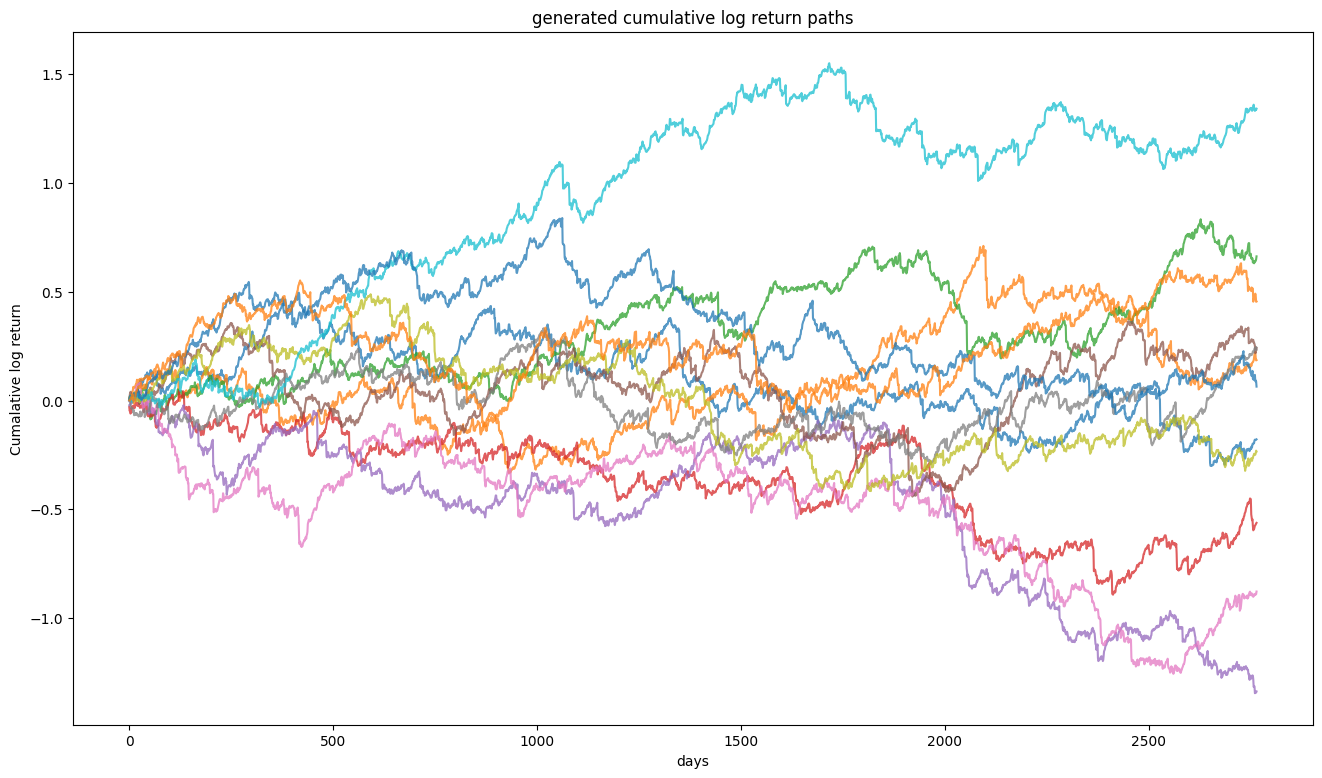

In [35]:
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(np.cumsum(y[0:30], axis=1).T, alpha=0.75)
ax.set_title(f'generated cumulative log return paths'.format(len(y)))
ax.set_xlabel('days')
ax.set_ylabel('Cumalative log return');

### Distributional Metrics

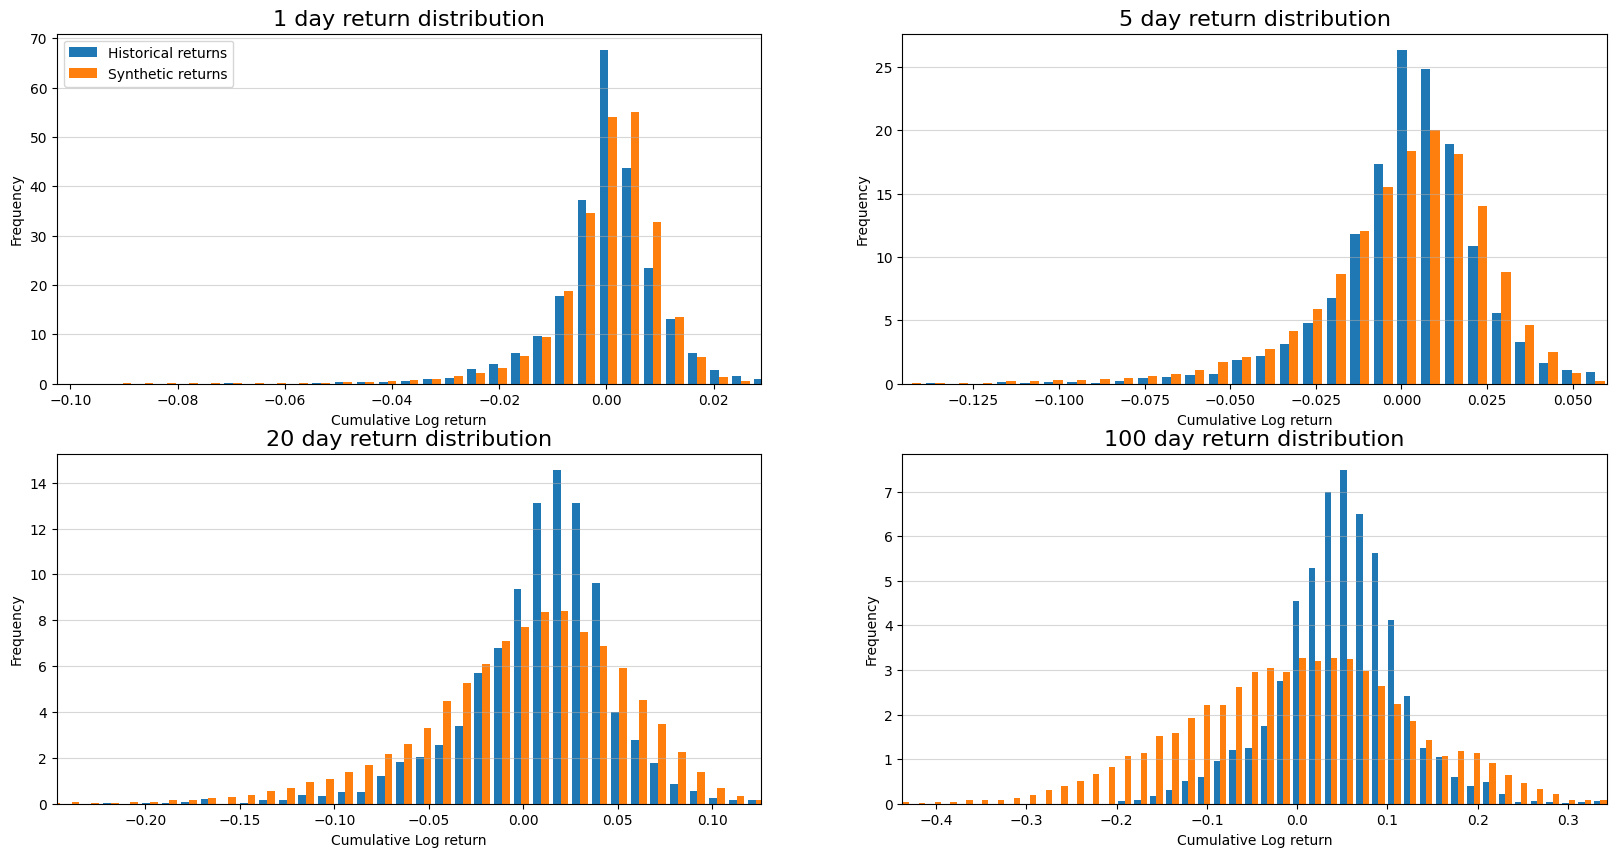

In [36]:
n_bins = 50
windows = [1, 5, 20, 100]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))


for i in range(len(windows)):
    row = min(max(0, i-1), 1)
    col = i % 2
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    axs[row, col].hist(np.array([real_dist, fake_dist], dtype='object'), bins=50, density=True)
    axs[row,col].set_xlim(*np.quantile(fake_dist, [0.001, .999]))

    axs[row,col].set_title('{} day return distribution'.format(windows[i]), size=16)
    axs[row,col].yaxis.grid(True, alpha=0.5)
    axs[row,col].set_xlabel('Cumulative Log return')
    axs[row,col].set_ylabel('Frequency')

axs[0,0].legend(['Historical returns', 'Synthetic returns'])

In [37]:
windows = pd.Series([1, 5, 20, 100], name='window size')
EMDscores = np.zeros(len(windows))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()

    EMDscores[i] = wasserstein_distance(real_dist, fake_dist)
    # print(EMDscores[i])

df_EMD = pd.DataFrame({'Earth Mover Distance' : EMDscores}, index=windows)
df_EMD

,Earth Mover Distance
window size,
1,0.001181
5,0.004113
20,0.015272
100,0.062323


In [38]:
windows = pd.Series([1, 5, 20, 100], name='window size')

# Real
real_array = np.zeros((len(windows), 4))

for i in range(len(windows)):
    real_dist = rolling_window(log_returns, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    real_array[i, 0] = skew(real_dist)
    real_array[i, 1] = skewtest(real_dist).pvalue
    real_array[i, 2] = kurtosis(real_dist)
    real_array[i, 3] = kurtosistest(real_dist).pvalue

real_df = pd.DataFrame(np.round(real_array, 3), columns=['skewness', 'skewness p-value', 'kurtosis', 'kurtosis p-value'], index=windows)


# Synthetic
fake_array = np.zeros((len(windows), 4))

for i in range(len(windows)):
    fake_dist = rolling_window(y.T, windows[i], sparse = not (windows[i] == 1)).sum(axis=0).ravel()
    fake_array[i, 0] = skew(fake_dist)
    fake_array[i, 1] = skewtest(fake_dist).pvalue
    fake_array[i, 2] = kurtosis(fake_dist)
    fake_array[i, 3] = kurtosistest(fake_dist).pvalue

fake_df = pd.DataFrame(np.round(fake_array, 3), columns=['skewness', 'skewness p-value', 'kurtosis', 'kurtosis p-value'], index=windows)

display_side_by_side(real_df,fake_df, titles=['Real','Synthetic'])

,skewness,skewness p-value,kurtosis,kurtosis p-value
window size,,,,
1,-0.350,0.000,5.088,0.0
5,-0.663,0.000,3.829,0.0
20,-0.814,0.000,3.889,0.0
100,-0.014,0.764,1.612,0.0
,skewness,skewness p-value,kurtosis,kurtosis p-value
window size,,,,
1,-3.115,0.0,21.655,0.000
5,-1.480,0.0,4.980,0.000
20,-0.813,0.0,1.361,0.000


### Fat Tails

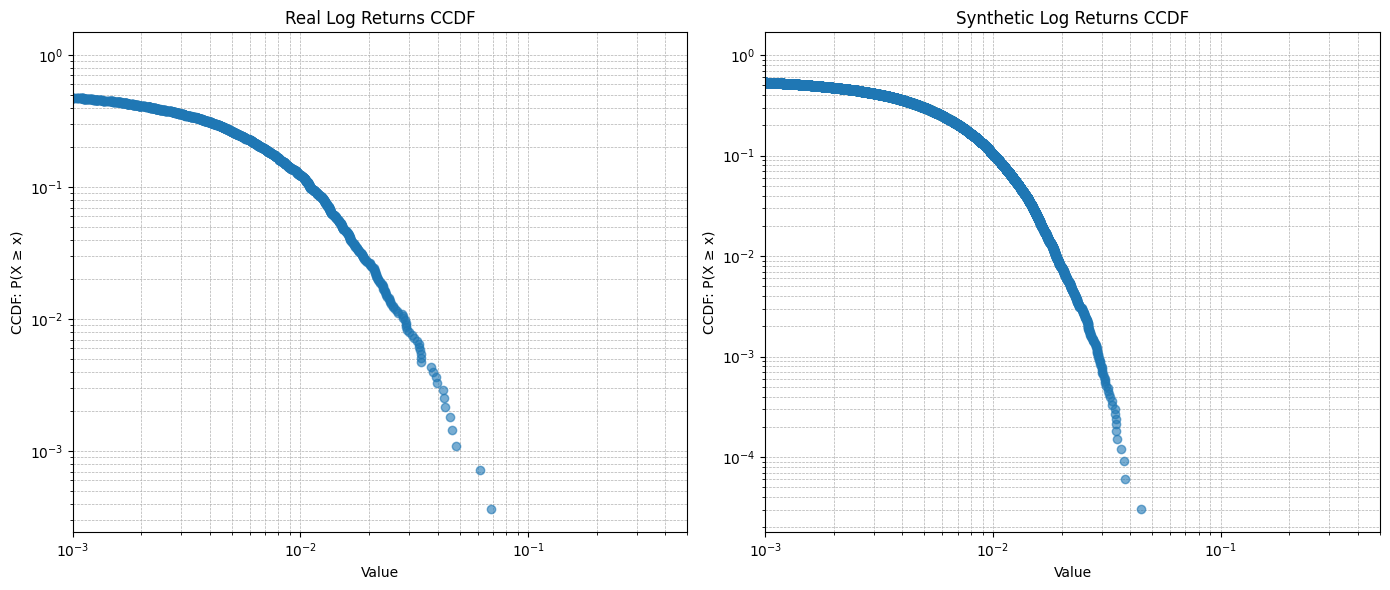

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import powerlaw as powerlaw

def plot_ccdf(data, ax, title):
    """
    Plots the CCDF (Complementary Cumulative Distribution Function) of the data on a log-log scale.

    Parameters:
        data (array-like): The data to be plotted.
        ax (matplotlib.axes.Axes): The subplot axis to plot on.
        title (str): Title of the subplot.
    """
    # Sort the data in descending order
    sorted_data = np.sort(data)[::-1]
    n = len(sorted_data)
    # Compute the CCDF: rank / total number of points
    ccdf = np.arange(1, n+1) / n

    # Plot using log-log scale
    ax.loglog(sorted_data, ccdf, marker='o', linestyle='none', alpha=0.6)
    ax.set_xlim(0.001, 0.5)
    ax.set_xlabel("Value")
    ax.set_ylabel("CCDF: P(X ≥ x)")
    ax.set_title(title)
    ax.grid(True, which='both',  ls='--', lw=0.5)

# Assume real_log_returns and synthetic_log_returns are your datasets.
# If synthetic_log_returns is 2D (e.g., 80 x 2500), we flatten it.
real_data = log_returns.flatten() if log_returns.ndim > 1 else log_returns
synthetic_data = y.flatten() if y.ndim > 1 else y

# Create side-by-side subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
plot_ccdf(real_data, axes[0], "Real Log Returns CCDF")
plot_ccdf(synthetic_data, axes[1], "Synthetic Log Returns CCDF")

plt.tight_layout()
plt.show()

In [40]:
# Real data
fit = powerlaw.Fit(log_returns.flatten(), xmin=0.01)
fit.power_law.alpha

Values less than or equal to 0 in data. Throwing out 0 or negative values


np.float64(3.302494130490744)

In [41]:
# Synthetic/fake data
fit = powerlaw.Fit(y.flatten(), xmin=0.01)
fit.power_law.alpha

np.float64(4.274797003916548)

IndexError: index 50 is out of bounds for axis 0 with size 12

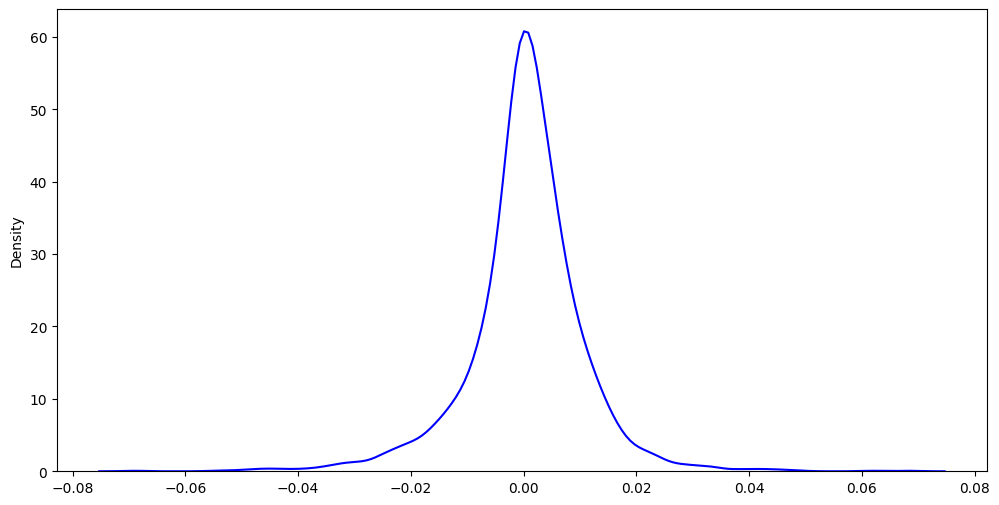

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot histograms
plt.figure(figsize=(12, 6))
sns.kdeplot(log_returns.flatten(), label="S&P500", color="blue")
sns.kdeplot(y[50], label="Synthetic", color="red")

plt.legend()
plt.title("Histogram of Log Returns")
plt.xlabel("Log Returns")
plt.ylabel("Frequency")
plt.show()

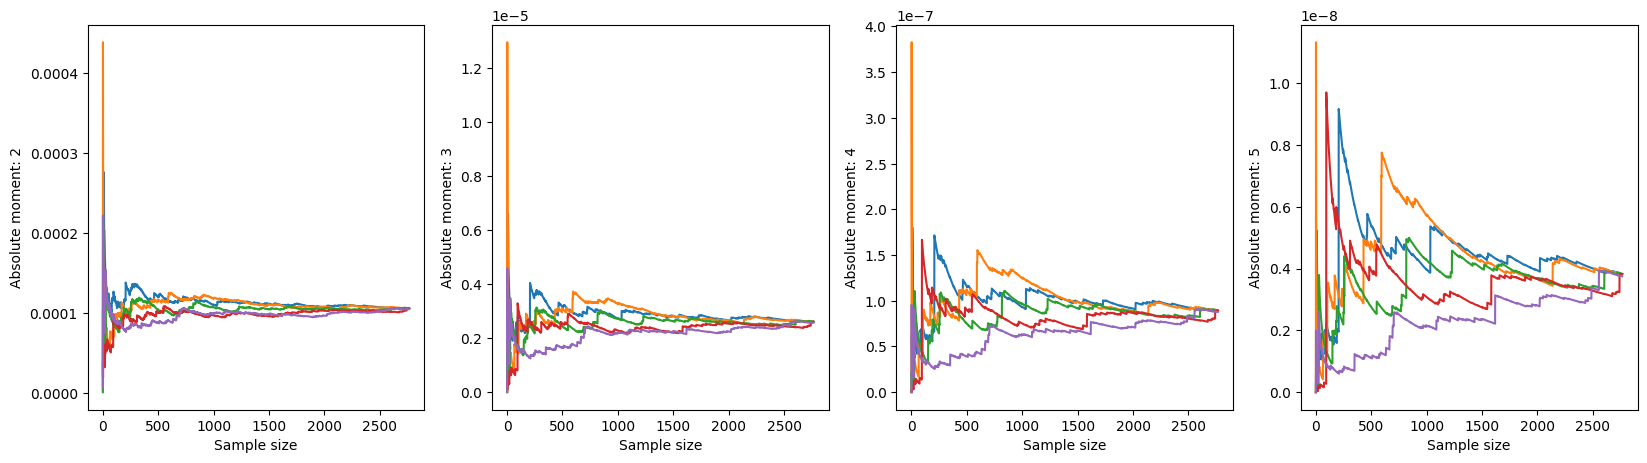

In [43]:
# Real Data
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(20,5), ncols=4)
x_range = range(1, len(log_returns))

for _ in range(5):
    shuffled_array = np.random.permutation(log_returns)

    for j in range(len(absolute_moments)):
        ax[j].plot(x_range, [np.mean(np.abs(shuffled_array[:i])**absolute_moments[j], axis=0) for i in x_range]);

for i in range(len(absolute_moments)):
    ax[i].set_xlabel('Sample size')
    ax[i].set_ylabel('Absolute moment: {}'.format(absolute_moments[i]))

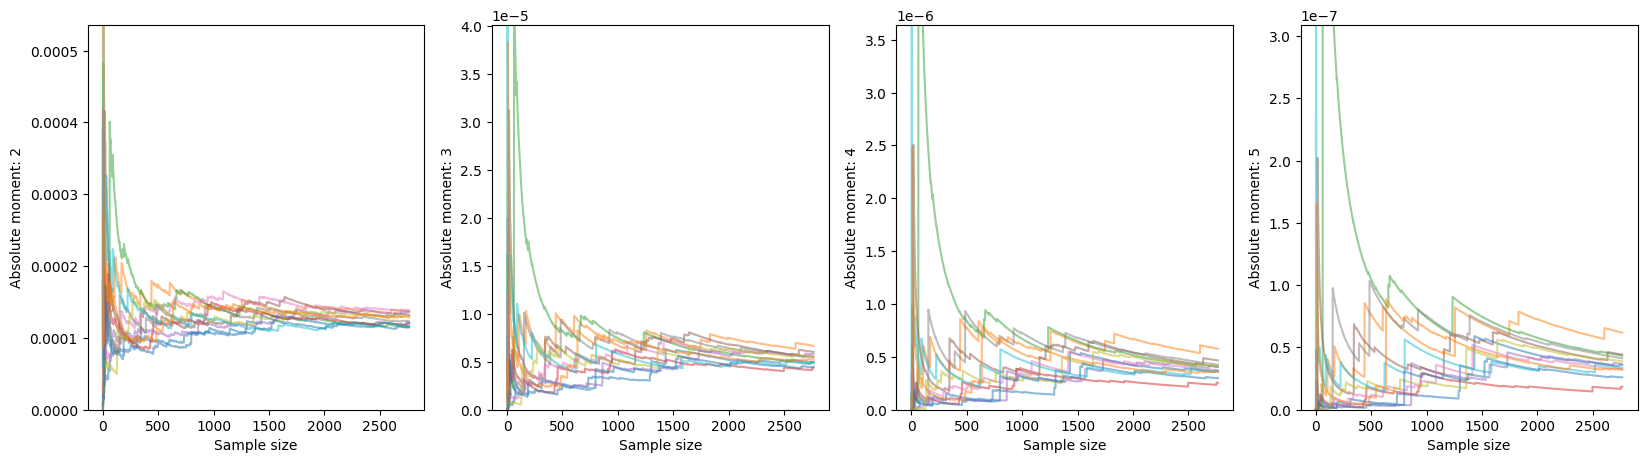

In [44]:
# Synthetic Data
absolute_moments = [2, 3, 4, 5]

fig, ax = plt.subplots(figsize=(5*len(absolute_moments), 5), ncols=len(absolute_moments))
# x_range = range(1, 251)
x_range = range(1, len(log_returns))

# shuffle along first index, so tranpose
shuffled_array = np.random.permutation(y.T)

for j in range(len(absolute_moments)):
    paths = np.array([np.mean(np.abs(shuffled_array[:i, :50])**absolute_moments[j], axis=0) for i in x_range])
    ax[j].plot(x_range, paths, alpha=0.5)
    # ax[j].set_xlim(0, 250)
    ax[j].set_ylim(0, np.quantile(paths.max(axis=0), .85))
    ax[j].set_xlabel('Sample size')
    ax[j].set_ylabel('Absolute moment: {}'.format(absolute_moments[j]))


# Note the underflow warning, i.e. some returns when raised to a high power produce
# values so small that they fall outside of the range of float32,
# this is not a big deal

In [45]:
# Hill Estimator
import numpy as np
import matplotlib.pyplot as plt

def hill_estimator(data, k):
    """
    Compute the Hill estimator for the tail index alpha.

    Parameters:
      data: 1D numpy array of strictly positive values (the tail)
      k: Number of top order statistics (largest values) to use.

    Returns:
      tail_index: Estimated tail exponent alpha.
    """
    # Sort data in descending order
    sorted_data = np.sort(data)[::-1]

    # Ensure k is less than the length of data
    if k >= len(sorted_data):
        raise ValueError("k must be smaller than the number of data points")

    # The (k+1)-th largest value is our threshold
    threshold = sorted_data[k]

    # Compute the Hill estimator statistic
    hill_sum = np.sum(np.log(sorted_data[:k] / threshold))
    hill_stat = hill_sum / k

    # The tail exponent (alpha) is the inverse of the Hill statistic
    tail_index = 1.0 / hill_stat
    return tail_index


# Flatten the data for the Hill estimator (since the tail is assumed identical across series)
synthetic_flat = y.flatten()
real_flat = log_returns.flatten()

# Choose k as, for example, the top 10% of observations
k_synthetic = int(0.05 * len(synthetic_flat))
k_real = int(0.05 * len(real_flat))

# Compute the tail index using the Hill estimator
alpha_synthetic = hill_estimator(synthetic_flat, k_synthetic)
alpha_real = hill_estimator(real_flat, k_real)

print("Estimated tail exponent (alpha) for synthetic data: {:.2f}".format(alpha_synthetic))
print("Estimated tail exponent (alpha) for real data: {:.2f}".format(alpha_real))

Estimated tail exponent (alpha) for synthetic data: 4.23
Estimated tail exponent (alpha) for real data: 2.74


### Volatility Clustering, Autocorrelation & Leverage Effect

In [46]:
df_acf = pd.DataFrame(columns=['2 Day Volatility Score', '5 Day Volatility Score', '20 Day Volatility Score',
                               '100 Day Volatility Score', 'Vanilla ACF Score', 'Squared ACF Score',
                               'Absolute ACF Score', 'Leverage Effect Score', 'Volatility Persistence Score'])

[Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)')]

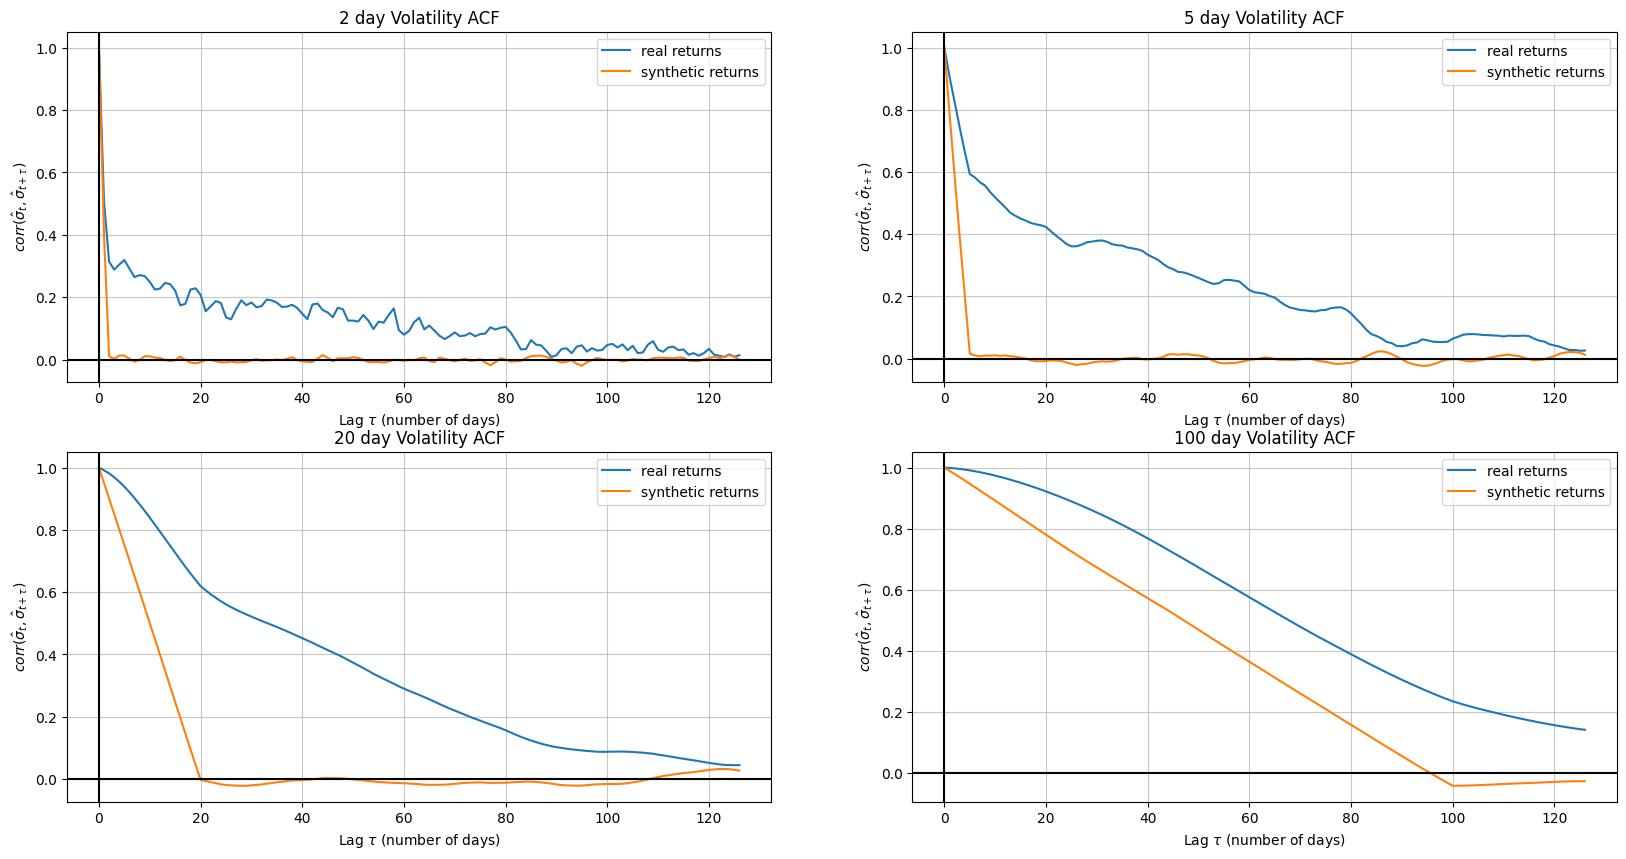

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

T = 127
vol_scores = []

# 1 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 2).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf,1)
real_acf = acf(rolling_window(log_returns, 2).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[0,0].plot(real_acf)
axs[0,0].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[0,0].grid(alpha=0.7)
axs[0,0].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('2 day Volatility ACF')


# 5 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 5).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf, 1)
real_acf = acf(rolling_window(log_returns, 5).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[0,1].plot(real_acf)
axs[0,1].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[0,1].grid(alpha=0.7)
axs[0,1].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[0,1].set_title('5 day Volatility ACF')



# 20 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 20).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf, 1)
real_acf = acf(rolling_window(log_returns, 20).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[1,0].plot(real_acf)
axs[1,0].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[1,0].grid(alpha=0.7)
axs[1,0].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[1,0].set_title('20 day Volatility ACF')


# 100 day
fake_acf = np.zeros(T)
for i in range(0, len(y), 40):
    # each iteration computes mean acf values from lag 1 to T for one batch of 40 time series
    fake_acf = fake_acf + acf(rolling_window(y.T[:, i:i+40], 100).std(axis=0), T).mean(axis=1)
fake_acf = np.expand_dims(fake_acf, 1)
real_acf = acf(rolling_window(log_returns, 100).std(axis=0), T)
vol_scores.append(np.linalg.norm(real_acf - (fake_acf/(len(y)//40 + 1))))
axs[1,1].plot(real_acf)
axs[1,1].plot(fake_acf/(len(y)//40 + 1)) # Mean of acf over 50 batches
axs[1,1].grid(alpha=0.7)
axs[1,1].set_ylabel('$corr(\hat{\sigma}_t,\hat{\sigma}_{t+\\tau})$')
# axs[0,0].set_ylim(-0.1, 0.1)
axs[1,1].set_title('100 day Volatility ACF')


for ax in axs.flat:
  ax.grid(True)
  ax.axhline(y=0, color='k')
  ax.axvline(x=0, color='k')
  ax.legend(['real returns', 'synthetic returns'])
plt.setp(axs, xlabel='Lag $\\tau$ (number of days)')

[Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)'),
 Text(0.5, 0, 'Lag $\\tau$ (number of days)')]

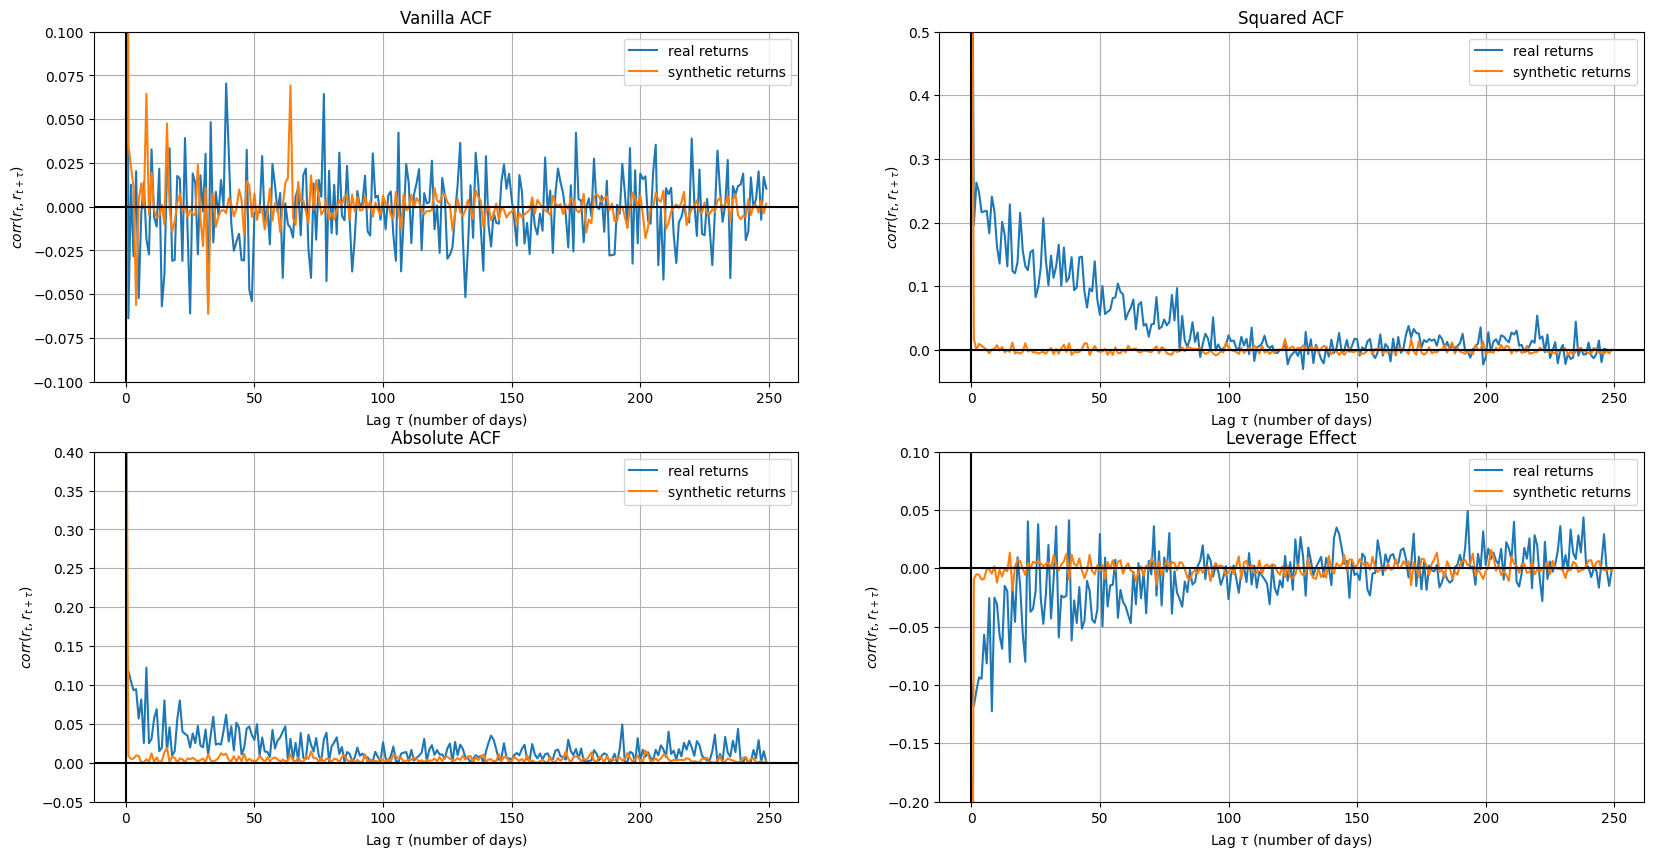

In [48]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))

lags = 250
acf_scores = []

# Vanilla ACF
real_acf = acf(log_returns, lags)
fake_acf = acf(y.T, lags).mean(axis=1, keepdims=True)
axs[0,0].plot(real_acf)
axs[0,0].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[0,0].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[0,0].set_ylim(-0.1, 0.1)
axs[0,0].set_title('Vanilla ACF')


# Squared  ACF
real_acf = acf(log_returns**2, lags)
fake_acf = acf(y.T**2, lags).mean(axis=1, keepdims=True)
axs[0,1].plot(real_acf)
axs[0,1].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[0,1].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[0,1].set_ylim(-0.05, 0.5)
axs[0,1].set_title('Squared ACF')

# Absolute  ACF
real_acf = abs(acf(log_returns, lags, le=True))
fake_acf = abs(acf(y.T, lags, le=True).mean(axis=1, keepdims=True))
axs[1,0].plot(real_acf)
axs[1,0].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[1,0].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[1,0].set_ylim(-0.05, 0.4)
axs[1,0].set_title('Absolute ACF')


# Leverage Effect
real_acf = acf(log_returns, lags, le=True)
fake_acf = acf(y.T, lags, le=True).mean(axis=1, keepdims=True)
axs[1,1].plot(real_acf)
axs[1,1].plot(fake_acf)
acf_scores.append(np.linalg.norm(real_acf - fake_acf))
axs[1,1].set_ylabel('$corr(r_t, r_{t+\\tau})$')
axs[1,1].set_ylim(-0.2, 0.1)
axs[1,1].set_title('Leverage Effect')


for ax in axs.flat:
    ax.grid(True)
    ax.axhline(y=0, color='k')
    ax.axvline(x=0, color='k')
    ax.legend(['real returns', 'synthetic returns'])
plt.setp(axs, xlabel='Lag $\\tau$ (number of days)')

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001054. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001363. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(


Real Data Parameters:
omega: 2.435204357343744e-06, alpha: 0.10116525895820278, beta: 0.878793080389131, alpha + beta: 0.9799583393473337

Synthetic Data Parameters:
omega: 6.815194422621419e-05, alpha: 0.10000004245222777, beta: 0.3999999811691017, alpha + beta: 0.5000000236213294



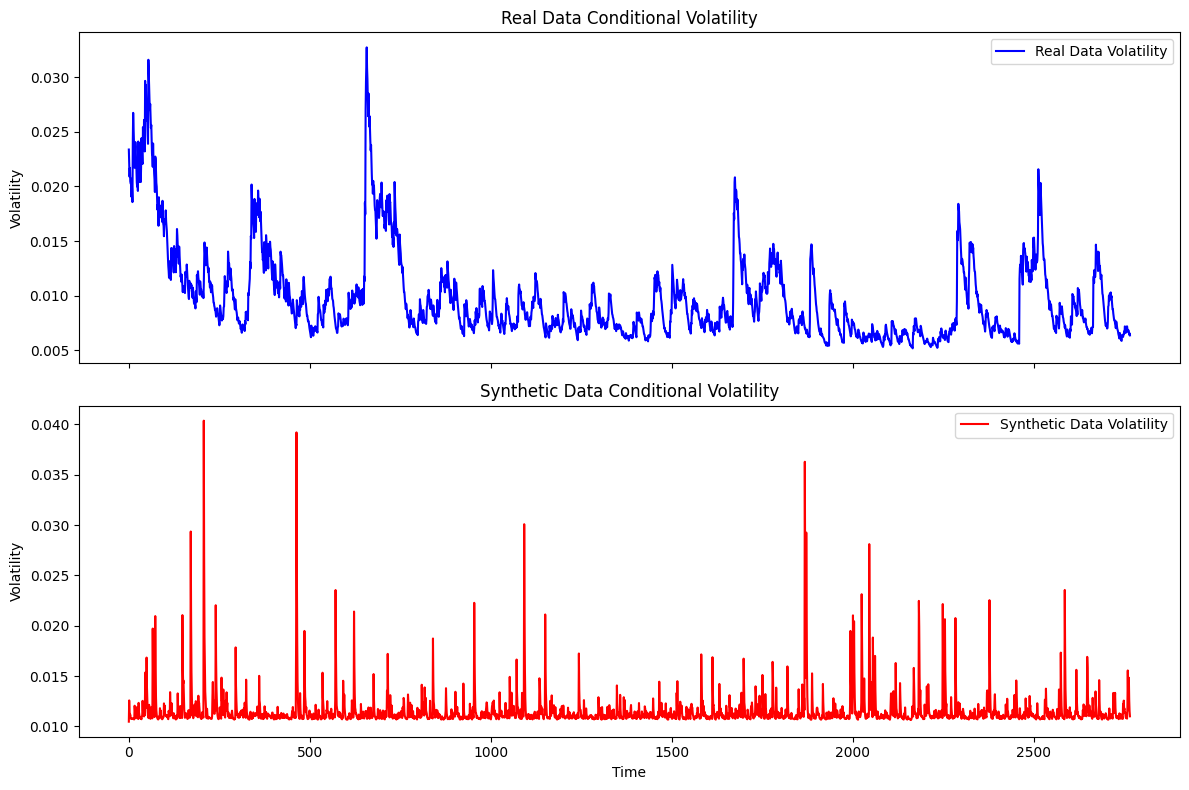

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model

# Assuming 'real_returns' and 'synthetic_returns' are your datasets as pandas Series

# Fit GARCH(1,1) model to real data
garch_real = arch_model(log_returns, vol='Garch', p=1, q=1)
res_real = garch_real.fit(disp='off')
omega_real, alpha_real, beta_real = res_real.params[['omega', 'alpha[1]', 'beta[1]']]

# Fit GARCH(1,1) model to synthetic data
garch_synth = arch_model(y[4], vol='Garch', p=1, q=1)
res_synth = garch_synth.fit(disp='off')
omega_synth, alpha_synth, beta_synth = res_synth.params[['omega', 'alpha[1]', 'beta[1]']]

# Print the estimated parameters
print("Real Data Parameters:")
print(f"omega: {omega_real}, alpha: {alpha_real}, beta: {beta_real}, alpha + beta: {alpha_real + beta_real}\n")

print("Synthetic Data Parameters:")
print(f"omega: {omega_synth}, alpha: {alpha_synth}, beta: {beta_synth}, alpha + beta: {alpha_synth + beta_synth}\n")

# Plotting the conditional volatilities
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Real data volatility
axes[0].plot(res_real.conditional_volatility, color='blue', label='Real Data Volatility')
axes[0].set_title('Real Data Conditional Volatility')
axes[0].set_ylabel('Volatility')
axes[0].legend()

# Synthetic data volatility
axes[1].plot(res_synth.conditional_volatility, color='red', label='Synthetic Data Volatility')
axes[1].set_title('Synthetic Data Conditional Volatility')
axes[1].set_xlabel('Time')
axes[1].set_ylabel('Volatility')
axes[1].legend()

plt.tight_layout()
plt.show()

In [50]:
# We call alpha + beta the volatility persistence score
alphabeta_sum = 0
for i in range(len(y)):
  garch_synth = arch_model(y[i], vol='Garch', p=1, q=1)
  res_synth = garch_synth.fit(disp='off')
  omega_synth, alpha_synth, beta_synth = res_synth.params[['omega', 'alpha[1]', 'beta[1]']]
  alphabeta_sum += alpha_synth + beta_synth

/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.000121. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarning: y is poorly scaled, which may affect convergence of the optimizer when
estimating the model parameters. The scale of y is 0.0001366. Parameter
estimation work better when this value is between 1 and 1000. The recommended
rescaling is 100 * y.

This warning can be disabled by either rescaling y before initializing the
model or by setting rescale=False.

  warnings.warn(
/usr/local/lib/python3.11/dist-packages/arch/univariate/base.py:309: DataScaleWarni

In [51]:
# # Average volatility persistence score for synthetic data
print(alphabeta_sum/len(y))

0.6661300242125594


In [52]:
all_scores = []
all_scores.extend(vol_scores)
all_scores.extend(acf_scores)
all_scores.append(alphabeta_sum/len(y))
df_acf.loc[len(df_acf)] = all_scores
df_acf

,2 Day Volatility Score,5 Day Volatility Score,20 Day Volatility Score,100 Day Volatility Score,Vanilla ACF Score,Squared ACF Score,Absolute ACF Score,Leverage Effect Score,Volatility Persistence Score
0,1.562231,3.058356,3.620286,2.255836,0.398345,1.187106,0.674321,0.704914,0.66613


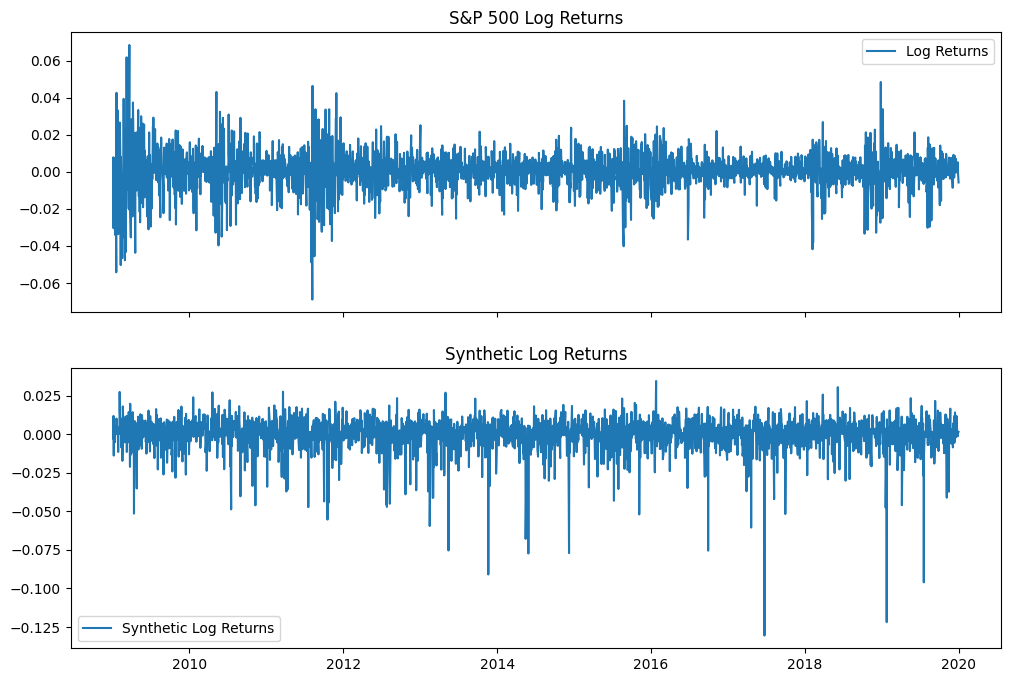

In [53]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)


axes[0].plot(data.index[1:], log_returns, label='Log Returns')
axes[0].set_title('S&P 500 Log Returns')
axes[0].legend()
axes[1].plot(data.index[1:], y[0], label='Synthetic Log Returns')
axes[1].set_title('Synthetic Log Returns')
axes[1].legend()